In [1]:
import os
import time
import math
import numpy as np
import random
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import datetime
now_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [2]:
import pandas as pd
from transformers import AutoModel, AutoTokenizer, AutoConfig
from matplotlib import pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [3]:
label_list = ['UNK',1,2,3,4,5,6,7,8,9,10]

In [4]:
df_train_l=pd.read_csv("../../drugs/subdivided/train_l.csv", index_col="Unnamed: 0")
df_test_l=pd.read_csv("../../drugs/subdivided/test_l.csv", index_col="Unnamed: 0")
df_u=pd.read_csv("../../drugs/subdivided/u.csv", index_col="Unnamed: 0")
# df_train_u=pd.read_csv("../../drugs/assigned/train_u.csv", index_col="Unnamed: 0")#.head(10000)
# df_test_u=pd.read_csv("../../drugs/assigned/test_u.csv", index_col="Unnamed: 0")#.head(5000)
# df_all = pd.concat([df_train_l, df_test_l, df_u, df_train_u, df_test_u])

In [5]:
df_u['0'].size

5000

In [6]:
train_l =  list(df_train_l.to_records(index=False))
test_l = list(df_test_l.to_records(index=False))
u_list = list(df_u.to_records(index=False))
# test_u = list(df_test_u.to_records(index=False))
# train_u = list(df_train_u.to_records(index=False))
# data_all = list(df_all["0"])

In [7]:
#--------------------------------
#  Transformer parameters
#--------------------------------
max_seq_length = 45
batch_size = 64

#--------------------------------
#  GAN-BERT specific parameters
#--------------------------------
# number of hidden layers in the generator, 
# each of the size of the output space
#num_hidden_layers_g = 1; 
# number of hidden layers in the discriminator, 
# each of the size of the input space
num_hidden_layers_d = 1; 
# size of the generator's input noisy vectors
noise_size = 100
# dropout to be applied to discriminator's input vectors
out_dropout_rate = 0.2

# Replicate labeled data to balance poorly represented datasets, 
# e.g., less than 1% of labeled material
apply_balance = True

#--------------------------------
#  Optimization parameters
#--------------------------------
learning_rate_discriminator = 5e-6 #5e-6?
#learning_rate_generator = 5e-5
epsilon = 1e-8
num_train_epochs = 200
multi_gpu = True
# Scheduler
apply_scheduler = False
warmup_proportion = 0.1
# Print
print_each_n_step = 10

#--------------------------------
#  Adopted Tranformer model
#--------------------------------
# Since this version is compatible with Huggingface transformers, you can uncomment
# (or add) transformer models compatible with GAN

model_name = "bert-base-cased"
#model_name = "bert-base-uncased"
#model_name = "roberta-base"
#model_name = "albert-base-v2"
#model_name = "xlm-roberta-base"
#model_name = "amazon/bort"
#model_name="google/electra-large-discriminator"
#model_name="google/electra-small-discriminator"
#model_name="microsoft/deberta-v2-xxlarge"
#model_name="microsoft/deberta-v3-base"
#model_name = "google/electra-base-discriminator" - 0.47 best when only change this line

In [8]:
transformer = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
def generate_data_loader(input_examples, label_masks, label_map, do_shuffle = False, balance_label_examples = False):
  '''
  Generate a Dataloader given the input examples, eventually masked if they are 
  to be considered NOT labeled.
  '''
  examples = []

  # Count the percentage of labeled examples  
  num_labeled_examples = 0
  for label_mask in label_masks:
    if label_mask: 
      num_labeled_examples += 1
  label_mask_rate = num_labeled_examples/len(input_examples)

  # if required it applies the balance
  for index, ex in enumerate(input_examples): 
    if label_mask_rate == 1 or not balance_label_examples:
      examples.append((ex, label_masks[index]))
    else:
      # IT SIMULATE A LABELED EXAMPLE
      if label_masks[index]:
        balance = int(1/label_mask_rate)
        balance = int(math.log(balance,2))
        if balance < 1:
          balance = 1
        for b in range(0, int(balance)):
          examples.append((ex, label_masks[index]))
      else:
        examples.append((ex, label_masks[index]))
  
  #-----------------------------------------------
  # Generate input examples to the Transformer
  #-----------------------------------------------
  input_ids = []
  input_mask_array = []
  label_mask_array = []
  label_id_array = []

  # Tokenization 
  for (text, label_mask) in examples:
    encoded_sent = tokenizer.encode(text[0], add_special_tokens=True, max_length=max_seq_length, padding="max_length", truncation=True)
    input_ids.append(encoded_sent)
    label_id_array.append(label_map[text[1]])
    label_mask_array.append(label_mask)
  
  # Attention to token (to ignore padded input wordpieces)
  for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]                          
    input_mask_array.append(att_mask)
  # Convertion to Tensor
  input_ids = torch.tensor(input_ids) 
  input_mask_array = torch.tensor(input_mask_array)
  label_id_array = torch.tensor(label_id_array, dtype=torch.long)
  label_mask_array = torch.tensor(label_mask_array)

  # Building the TensorDataset
  dataset = TensorDataset(input_ids, input_mask_array, label_id_array, label_mask_array)

  if do_shuffle:
    sampler = RandomSampler
  else:
    sampler = SequentialSampler

  # Building the DataLoader
  return DataLoader(
              dataset,  # The training samples.
              sampler = sampler(dataset), 
              batch_size = batch_size) # Trains with this batch size.

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [10]:
def generate_data_fake(input_examples):
  '''
  Generate a Dataloader given the input examples, eventually masked if they are 
  to be considered NOT labeled.
  '''
  
  #-----------------------------------------------
  # Generate input examples to the Transformer
  #-----------------------------------------------
  input_ids = []
  input_mask_array = []

  # Tokenization 
  for text in input_examples:
    encoded_sent = tokenizer.encode(text, add_special_tokens=True, max_length=max_seq_length, padding="max_length", truncation=True)
    input_ids.append(encoded_sent)
  
  # Attention to token (to ignore padded input wordpieces)
  for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]                          
    input_mask_array.append(att_mask)
  # Convertion to Tensor
  input_ids = torch.tensor(input_ids) 
  input_mask_array = torch.tensor(input_mask_array)

  # Building the DataLoader
  return input_ids, input_mask_array # Trains with this batch size.

In [11]:
#Load the examples
labeled_examples = train_l
unlabeled_examples = u_list
test_examples = test_l

In [12]:
label_map = {}
for (i, label) in enumerate(label_list):
  label_map[label] = i
#------------------------------
#   Load the train dataset
#------------------------------
train_examples = labeled_examples
#The labeled (train) dataset is assigned with a mask set to True
train_label_masks = np.ones(len(labeled_examples), dtype=bool)
#If unlabel examples are available
if unlabeled_examples:
  train_examples = train_examples + unlabeled_examples
  #The unlabeled (train) dataset is assigned with a mask set to False
  tmp_masks = np.zeros(len(unlabeled_examples), dtype=bool)
  train_label_masks = np.concatenate([train_label_masks,tmp_masks])

train_dataloader = generate_data_loader(train_examples, train_label_masks, label_map, do_shuffle = True, balance_label_examples = apply_balance)

#------------------------------
#   Load the test dataset
#------------------------------
#The labeled (test) dataset is assigned with a mask set to True
test_label_masks = np.ones(len(test_examples), dtype=bool)

test_dataloader = generate_data_loader(test_examples, test_label_masks, label_map, do_shuffle = False, balance_label_examples = False)

In [13]:
#------------------------------
#   The Discriminator
#   https://www.aclweb.org/anthology/2020.acl-main.191/
#   https://github.com/crux82/ganbert
#------------------------------
class Discriminator(nn.Module):
    def __init__(self, input_size=512, hidden_sizes=[512], num_labels=2, dropout_rate=0.1):
        super(Discriminator, self).__init__()
        self.input_dropout = nn.Dropout(p=dropout_rate)
        layers = []
        hidden_sizes = [input_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

        self.layers = nn.Sequential(*layers) #per il flatten
        self.logit = nn.Linear(hidden_sizes[-1],num_labels+1) # +1 for the probability of this sample being fake/real.
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input_rep):
        input_rep = self.input_dropout(input_rep)
        last_rep = self.layers(input_rep)
        logits = self.logit(last_rep)
        probs = self.softmax(logits)
        return last_rep, logits, probs

In [14]:
# The config file is required to get the dimension of the vector produced by 
# the underlying transformer
config = AutoConfig.from_pretrained(model_name)
hidden_size = int(config.hidden_size)
# Define the number and width of hidden layers
#hidden_levels_g = [hidden_size for i in range(0, num_hidden_layers_g)]
hidden_levels_d = [hidden_size for i in range(0, num_hidden_layers_d)]

#-------------------------------------------------
#   Instantiate the Generator and Discriminator
#-------------------------------------------------
#generator = Generator(noise_size=noise_size, output_size=hidden_size, hidden_sizes=hidden_levels_g, dropout_rate=out_dropout_rate)
discriminator = Discriminator(input_size=hidden_size, hidden_sizes=hidden_levels_d, num_labels=len(label_list), dropout_rate=out_dropout_rate)

# Put everything in the GPU if available
if torch.cuda.is_available():    
  #generator.cuda()
  discriminator.cuda()
  transformer.cuda()
  if multi_gpu:
    transformer = torch.nn.DataParallel(transformer)

# print(config)

In [15]:
training_stats = []

accuracy_array=[]

# Measure the total training time for the whole run.
total_t0 = time.time()

#models parameters
transformer_vars = [i for i in transformer.parameters()]
d_vars = transformer_vars + [v for v in discriminator.parameters()]
#g_vars = [v for v in generator.parameters()]

#optimizer
dis_optimizer = torch.optim.AdamW(d_vars, lr=learning_rate_discriminator)
#gen_optimizer = torch.optim.AdamW(g_vars, lr=learning_rate_generator) 

#scheduler
if apply_scheduler:
  num_train_examples = len(train_examples)
  num_train_steps = int(num_train_examples / batch_size * num_train_epochs)
  num_warmup_steps = int(num_train_steps * warmup_proportion)

  scheduler_d = get_constant_schedule_with_warmup(dis_optimizer, 
                                           num_warmup_steps = num_warmup_steps)
  scheduler_g = get_constant_schedule_with_warmup(gen_optimizer, 
                                           num_warmup_steps = num_warmup_steps)

In [16]:
#OPTAGAN
from __future__ import absolute_import, division, print_function, unicode_literals
import argparse

import logging
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import numpy as np

from torch.autograd import Variable
from modules.gan import Generator, Critic

import copy
import math
import glob
import os
import pickle
import random

import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler, TensorDataset
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm, trange

from func import GPT2Config, OpenAIGPTConfig, XLNetConfig, TransfoXLConfig, BertConfig
from func import GPT2LMHeadModel, GPT2Tokenizer, GPT2ForLatentConnector, GPT2ForLatentConnectorValueHead
from func import OpenAIGPTLMHeadModel, OpenAIGPTTokenizer
from func import XLNetLMHeadModel, XLNetTokenizer
from func import TransfoXLLMHeadModel, TransfoXLTokenizer
from func import BertForLatentConnector, BertTokenizer

from collections import defaultdict
from utils import (TextDataset_Split, TextDataset_2Tokenizers, BucketingDataLoader)
import pdb
from modules.utils import (calc_blue_parallel_func, pad_seq, rollout, rollout_test)
#from transformers.modeling_utils import top_k_top_p_filtering


MAX_LENGTH = int(10000)  # Hardcoded max length to avoid infinite loop
ALL_MODELS = sum((tuple(conf.pretrained_config_archive_map.keys()) for conf in (GPT2Config, OpenAIGPTConfig, XLNetConfig, TransfoXLConfig)), ())

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

MODEL_CLASSES = {
    'gpt2': (GPT2Config, GPT2ForLatentConnectorValueHead, GPT2Tokenizer),
    'bert': (BertConfig, BertForLatentConnector, BertTokenizer)
}

num_txt = 1

def load_and_cache_examples(args, tokenizer):
    if isinstance(tokenizer, list):
        dataset = TextDataset_2Tokenizers(tokenizer, args, args.train_data_file, block_size=args.block_size)
    else:
        dataset = TextDataset_Split(tokenizer, args, args.train_data_file, block_size=args.block_size)
    return dataset

def build_dataload_and_cache_examples(args, tokenizer, num_txt):
    if isinstance(tokenizer, list):
        args.batch_size = args.per_gpu_train_batch_size * max(1, args.n_gpu)
        if num_txt<=9:
            concatenation="{}_{}{}".format(args.train_data_file, num_txt, ".txt")
            file_path=concatenation
            print("Train file used is number {}".format(num_txt))
            print(concatenation)
            num_txt=num_txt+1
        else:
            num_txt=1
            concatenation="{}_{}{}".format(args.train_data_file, num_txt, ".txt")
            file_path=concatenation
            print("Train file used is number {}".format(num_txt))
        dataloader = BucketingDataLoader(file_path, args.batch_size, args.max_seq_length, tokenizer, args, bucket=100, shuffle=True)
    else:
        pass 
    return dataloader, num_txt

def compute_grad_penalty(critic, real_data, fake_data):
    B = real_data.size(0)
    alpha = torch.FloatTensor(np.random.random((B, 1)))
    if args.cuda:
        alpha = alpha.cuda()
    sample = alpha*real_data + (1-alpha)*fake_data
    sample.requires_grad_(True)
    score = critic(sample)

    outputs = torch.FloatTensor(B, 1).fill_(1.0) #args.latent_size
    outputs.requires_grad_(False)
    if args.cuda:
        outputs = outputs.cuda()
    grads = autograd.grad(
        outputs=score,
        inputs=sample,
        grad_outputs=outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True)[0]
    grad_penalty = ((grads.norm(2, dim=1) - 1.) ** 2).mean()
    return grad_penalty

def train(epoch):
    model_encoder.eval()
    model_decoder.eval()
    generator.train()
    critic.train()
    c_train_loss = 0.
    g_train_loss = 0.
    g_batches = 0
    c_batches = 0
    c_loss_0 = 1
    g_loss_0 = 1
    for i, x in enumerate(train_loader):
        x = x[0]
        if args.cuda:
            x = x.cuda()
        # Generate noise
        B = args.per_gpu_train_batch_size
        noise = torch.from_numpy(np.random.normal(0, 1, (B,
                                 args.latent_size))).float()
        if args.cuda:
            noise = noise.cuda()
        # Get original text latent embeddings
        with torch.no_grad(): 
            pooled_hidden_fea = model_encoder(x, attention_mask=(x > 0).float())[1]
            mean, logvar = model_encoder.linear(pooled_hidden_fea).chunk(2, -1)
            z_real = mean.squeeze(1) 

        # Evaluate and get losses
        z_fake = generator(noise)
        real_score = critic(z_real)
        fake_score = critic(z_fake)
        grad_penalty = compute_grad_penalty(critic, z_real.data, z_fake.data)
        c_loss = -torch.mean(real_score) + torch.mean(fake_score) + \
                 args.gp_lambda*grad_penalty

        fake_score = critic(generator(noise))
        g_loss = -torch.mean(fake_score)
        
        r_g = abs(((g_loss.item() - g_loss_0) / (g_loss_0 + 0.001))) 
        r_c = abs(((c_loss.item() - c_loss_0) / (c_loss_0 + 0.001))) 
        
        # Update critic or generator
        if ((2 + epoch) / epoch) * r_c > r_g:
            c_optimizer.zero_grad()
            c_batches += 1
            c_train_loss += c_loss.item()
            c_loss.backward()
            c_optimizer.step()
        else:
            g_optimizer.zero_grad()
            g_batches += 1
            g_train_loss += g_loss.item()
            g_loss.backward()
            g_optimizer.step()

        c_loss_0 = c_loss.item()
        g_loss_0 = g_loss.item()

        if args.interval > 0 and i % args.interval == 0:
            logger.info('Epoch: {} | Batch: {}/{} ({:.0f}%) | G Loss: {:.6f} | C Loss: {:.6f}'.format(
                epoch, args.batch_size*i, len(train_loader.dataset),
                100.*(args.batch_size*i)/len(train_loader.dataset),
                g_loss.item(), c_loss.item()
            ))
            test_noise = torch.Tensor(np.random.normal(0, 1, (1, args.latent_size))).to(args.device)
            test_new_z = generator(test_noise).data
            # create new sent
            test_z = rollout_test(model_decoder, test_new_z, tokenizer_decoder, args.max_seq_length, 1, 0, 1)
            logger.info("Text: {}".format(test_z))

    c_train_loss /= c_batches + 1
    g_train_loss /= g_batches + 1
    logger.info('* (Train) Epoch: {} | G Loss: {:.4f} | C Loss: {:.4f} | Updates G: {} | Updates C: {}'.format(
        epoch, g_train_loss, c_train_loss, g_batches, c_batches
    ))
    return (g_train_loss, c_train_loss)

[nltk_data] Downloading package punkt to /home/harry/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--seed', type=int, default=0)
    parser.add_argument('--epochs', type=int, default=15)
    parser.add_argument('--lr', type=float, default=1e-4)
    parser.add_argument('--gp_lambda', type=int, default=10)
    parser.add_argument('--n_layers', type=int, default=20, help="Number of layers of generator and critic")
    parser.add_argument('--block_dim', type=int, default=100)
    parser.add_argument('--interval', type=int, default=10, help="Steps before logging output")
    parser.add_argument('--cuda', type=bool, default=torch.cuda.is_available())
    
    # Optimus parameters
    parser.add_argument("--train_data_file", default=None, type=str, required=True,
                        help="The input training data file (a text file).")
    parser.add_argument("--valid_data_file", default=None, type=str, required=True,
                        help="The input validation data file (a text file).")
    parser.add_argument("--checkpoint_dir", default=None, type=str, required=True,
                        help="The directory where checkpoints are saved.")
    parser.add_argument('--generator_dir', default=None, type=str, help="Directory where GAN models are saved")
    parser.add_argument("--output_dir", default=None, type=str, required=True,
                        help="The output directory where the model predictions and checkpoints will be written.")
    parser.add_argument("--dataset", default='Snli', type=str, help="The dataset.")    
    parser.add_argument("--latent_size", default=32, type=int, help="Latent space dimension.")
    ## Encoder options
    parser.add_argument("--encoder_model_type", default="bert", type=str,
                        help="The encoder model architecture to be fine-tuned.")
    parser.add_argument("--encoder_model_name_or_path", default="bert-base-cased", type=str,
                        help="The encoder model checkpoint for weights initialization.")
    parser.add_argument("--encoder_config_name", default="", type=str,
                        help="Optional pretrained config name or path if not the same as model_name_or_path")
    parser.add_argument("--encoder_tokenizer_name", default="", type=str,
                        help="Optional pretrained tokenizer name or path if not the same as model_name_or_path")
    ## Decoder options
    parser.add_argument("--decoder_model_type", default="gpt2", type=str,
                        help="The decoder model architecture to be fine-tuned.")
    parser.add_argument("--decoder_model_name_or_path", default="bert-base-cased", type=str,
                        help="The decoder model checkpoint for weights initialization.")
    parser.add_argument("--decoder_config_name", default="", type=str,
                        help="Optional pretrained config name or path if not the same as model_name_or_path")
    parser.add_argument("--decoder_tokenizer_name", default="", type=str,
                        help="Optional pretrained tokenizer name or path if not the same as model_name_or_path")
    parser.add_argument("--per_gpu_train_batch_size", default=1, type=int,
                        help="Batch size per GPU/CPU for training.")
    parser.add_argument("--max_seq_length", default=512, type=int,
                        help="Optional input sequence length before tokenization. The sequence will be dropped if it is longer the max_seq_length")

    ## Variational auto-encoder(check this)
    parser.add_argument("--prompt", type=str, default="")
    parser.add_argument("--padding_text", type=str, default="")
    parser.add_argument("--length", type=int, default=20)
    parser.add_argument("--block_size", default=-1, type=int,
                        help="Optional input sequence length after tokenization."
                             "The training dataset will be truncated in block of this size for training."
                             "Default to the model max input length for single sentence inputs (take into account special tokens).")
    parser.add_argument("--do_lower_case", action='store_true',
                        help="Set this flag if you are using an uncased model.")
    parser.add_argument("--use_philly", action='store_true',
                        help="Use Philly for computing.")
    parser.add_argument('--gloabl_step_eval', type=int, default=661,
                        help="Evaluate the results at the given global step")
    # Reinforcement learning parameters
    parser.add_argument('--finetune_decoder', type=bool, default=True)
    parser.add_argument('--epochs_rl', type=int, default=1000)
    parser.add_argument('--batch_size_rl', type=int, default=32)
    parser.add_argument('--lr_rl', type=float, default=1e-6)


    # Load a trained Encoder model and vocabulary that you have fine-tuned
    args = parser.parse_args("--dataset EMNLP \
    --checkpoint_dir=output_dir_768_0_unsure_2 \
    --output_dir=output_dir_768_0_unsure_2 \
    --encoder_model_type=bert \
    --encoder_model_name_or_path=bert-base-cased \
    --decoder_model_type=gpt2 \
    --decoder_model_name_or_path=gpt2 \
    --train_data_file=../../drugs/subdivided/train \
    --valid_data_file=../../drugs/subdivided/test.txt \
    --per_gpu_train_batch_size 12 \
    --block_size 100 \
    --max_seq_length 24 \
    --gloabl_step_eval 508523 \
    --latent_size 768 \
    --block_dim 100 \
    --n_layers 10 \
    --interval 50 \
    --epochs 200 \
    --finetune_decoder False \
    --lr_rl 1e-6 \
    --epochs_rl 100 \
    --batch_size_rl 32".split())
    
    print(args)

    global_step = args.gloabl_step_eval

    torch.backends.cudnn.deterministic = True
    #args.device = torch.device("cuda" if args.cuda else "cpu")
    #args.n_gpu = torch.cuda.device_count()
    args.device = torch.device("cuda:0")
    args.n_gpu=1
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)       
    
    args.encoder_model_type = args.encoder_model_type.lower()
    args.decoder_model_type = args.decoder_model_type.lower()

    output_encoder_dir = os.path.join(args.checkpoint_dir, 'checkpoint-encoder-{}'.format(global_step))
    output_decoder_dir = os.path.join(args.checkpoint_dir, 'checkpoint-decoder-{}'.format(global_step)) 
    checkpoints = [ [output_encoder_dir, output_decoder_dir] ]

    # Load a trained Encoder model and vocabulary that you have fine-tuned
    encoder_config_class, encoder_model_class, encoder_tokenizer_class = MODEL_CLASSES[args.encoder_model_type]
    model_encoder = encoder_model_class.from_pretrained(output_encoder_dir, latent_size=args.latent_size)
    tokenizer_encoder = encoder_tokenizer_class.from_pretrained(args.encoder_tokenizer_name if args.encoder_tokenizer_name else args.encoder_model_name_or_path, do_lower_case=args.do_lower_case)

    model_encoder.to(args.device)
    if args.block_size <= 0:
        args.block_size = tokenizer_encoder.max_len_single_sentence  # Our input block size will be the max possible for the model
    args.block_size = min(args.block_size, tokenizer_encoder.max_len_single_sentence)

    # Load a trained Decoder model and vocabulary that you have fine-tuned
    decoder_config_class, decoder_model_class, decoder_tokenizer_class = MODEL_CLASSES[args.decoder_model_type]
    model_decoder = decoder_model_class.from_pretrained(output_decoder_dir, latent_size=args.latent_size)
    tokenizer_decoder = decoder_tokenizer_class.from_pretrained(args.decoder_tokenizer_name if args.decoder_tokenizer_name else args.decoder_model_name_or_path, do_lower_case=args.do_lower_case)
    model_decoder.to(args.device)
    if args.block_size <= 0:
        args.block_size = tokenizer_decoder.max_len_single_sentence  # Our input block size will be the max possible for the model
    args.block_size = min(args.block_size, tokenizer_decoder.max_len_single_sentence)

    # Chunyuan: Add Padding token to GPT2
    special_tokens_dict = {'pad_token': '<PAD>', 'bos_token': '<BOS>', 'eos_token': '<EOS>'}
    num_added_toks = tokenizer_decoder.add_special_tokens(special_tokens_dict)
    logger.info('We have added {} tokens to GPT2'.format(num_added_toks))
    model_decoder.resize_token_embeddings(len(tokenizer_decoder))  # Notice: resize_token_embeddings expect to receive the full size of the new vocabulary, i.e. the length of the tokenizer.
    assert tokenizer_decoder.pad_token == '<PAD>'

    #train_loader, num_txt = build_dataload_and_cache_examples(args, [tokenizer_encoder, tokenizer_decoder], num_txt) 
    generator = Generator(args.n_layers, args.block_dim,args.latent_size)
    critic = Critic(args.n_layers, args.block_dim,args.latent_size)

    if args.generator_dir!=None:
        logger.info("Loading generator and critic")
        generator.load_state_dict(torch.load(args.generator_dir+'/generator_'+str(args.gloabl_step_eval)+'.th'))
        critic.load_state_dict(torch.load(args.generator_dir+'/critic_'+str(args.gloabl_step_eval)+'.th'))

    g_optimizer = optim.Adam(generator.parameters(), lr=args.lr, betas=(0.5, 0.999))
    c_optimizer = optim.Adam(critic.parameters(), lr=args.lr, betas=(0.5, 0.999))
    
    if args.cuda:
        generator = generator.cuda()
        critic = critic.cuda()
    
    logger.info('G Parameters:{}'.format(sum([p.numel() for p in generator.parameters() if \
                                p.requires_grad])))
    logger.info('C Parameters:{}'.format(sum([p.numel() for p in critic.parameters() if \
                                p.requires_grad])))
    
    device = args.device
    
    best_bleu = 0
    reference = list()
    with(open(args.valid_data_file,"r")) as valid:
        for sents in valid:
            reference.append(sents.replace("\n", ""))
            
    for epoch in range(1, args.epochs + 1):
        
        #Insert GAN-BERT Code Here
        
        train_loader, num_txt = build_dataload_and_cache_examples(args, [tokenizer_encoder, tokenizer_decoder], num_txt) 
        
        print("Train classification discriminator")
        # ========================================
        #               Training
        # ========================================
        # Perform one full pass over the training set.
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch, args.epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        tr_g_loss = 0
        tr_d_loss = 0

        # Put the model into training mode.
        transformer.train() 
        #generator.train()
        discriminator.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Progress update every print_each_n_step batches.
            if step % print_each_n_step == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)

                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # Unpack this training batch from our dataloader. 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            b_label_mask = batch[3].to(device)

            real_batch_size = b_input_ids.shape[0]

            # Encode real data in the Transformer
            model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
            hidden_states = model_outputs.last_hidden_state[:,0,:] 
            #hidden_states = model_outputs[-1]
            #print("  Number of real sentences (labelled and unlabelled): {}".format(len(hidden_states)))
            
            # Generate fake data that should have the same distribution of the ones
            # encoded by the transformer. 
            # First noisy input are used in input to the Generator
            fixed_noise = torch.Tensor(np.random.normal(0, 1, (real_batch_size, args.latent_size))).to(args.device)
            test_z_gb = generator(fixed_noise).data
            fake_sentences = rollout_test(model_decoder, test_z_gb, tokenizer_decoder, args.max_seq_length, real_batch_size, 0, 1)
            #print("  Number of generated sentences: {}".format(len(fake_sentences)))

            b_input_ids_fake, b_input_mask_fake = generate_data_fake(fake_sentences)
            model_outputs_fake = transformer(b_input_ids_fake, attention_mask=b_input_mask_fake)
            hidden_states_fake = model_outputs_fake.last_hidden_state[:,0,:] 
            #hidden_states_fake = model_outputs_fake[-1]

            #noise = torch.zeros(real_batch_size, noise_size, device=device).uniform_(0, 1)
            # Gnerate Fake data
            #gen_rep = generator(noise)
            #print("Length of generator output {}".format(len(gen_rep)))
            #print("Length of single generator output {}".format(len(gen_rep[0])))

            # Generate the output of the Discriminator for real and fake data.
            # First, we put together the output of the tranformer and the generator
            disciminator_input = torch.cat([hidden_states, hidden_states_fake], dim=0)
            # Then, we select the output of the disciminator
            features, logits, probs = discriminator(disciminator_input)

            # Finally, we separate the discriminator's output for the real and fake
            # data
            features_list = torch.split(features, real_batch_size)
            D_real_features = features_list[0]
            D_fake_features = features_list[1]

            logits_list = torch.split(logits, real_batch_size)
            D_real_logits = logits_list[0]
            D_fake_logits = logits_list[1]

            probs_list = torch.split(probs, real_batch_size)
            D_real_probs = probs_list[0]
            D_fake_probs = probs_list[1]

            #---------------------------------
            #  LOSS evaluation
            #---------------------------------
            # Generator's LOSS estimation
            g_loss_d = -1 * torch.mean(torch.log(1 - D_fake_probs[:,-1] + epsilon))
            g_feat_reg = torch.mean(torch.pow(torch.mean(D_real_features, dim=0) - torch.mean(D_fake_features, dim=0), 2))
            g_loss = g_loss_d + g_feat_reg

            # Disciminator's LOSS estimation
            logits = D_real_logits[:,0:-1]
            log_probs = F.log_softmax(logits, dim=-1)
            # The discriminator provides an output for labeled and unlabeled real data
            # so the loss evaluated for unlabeled data is ignored (masked)
            label2one_hot = torch.nn.functional.one_hot(b_labels, len(label_list))
            per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1)
            per_example_loss = torch.masked_select(per_example_loss, b_label_mask.to(device))
            labeled_example_count = per_example_loss.type(torch.float32).numel()

            # It may be the case that a batch does not contain labeled examples, 
            # so the "supervised loss" in this case is not evaluated
            if labeled_example_count == 0:
              D_L_Supervised = 0
            else:
              D_L_Supervised = torch.div(torch.sum(per_example_loss.to(device)), labeled_example_count)

            D_L_unsupervised1U = -1 * torch.mean(torch.log(1 - D_real_probs[:, -1] + epsilon))
            D_L_unsupervised2U = -1 * torch.mean(torch.log(D_fake_probs[:, -1] + epsilon))
            d_loss = D_L_Supervised + D_L_unsupervised1U + D_L_unsupervised2U

            #---------------------------------
            #  OPTIMIZATION
            #---------------------------------
            # Avoid gradient accumulation
            #gen_optimizer.zero_grad()
            dis_optimizer.zero_grad()

            # Calculate weigth updates
            # retain_graph=True is required since the underlying graph will be deleted after backward
            g_loss.backward(retain_graph=True)
            d_loss.backward() 

            # Apply modifications
            #gen_optimizer.step()
            dis_optimizer.step()

            # A detail log of the individual losses
            #print("{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".
            #      format(D_L_Supervised, D_L_unsupervised1U, D_L_unsupervised2U,
            #             g_loss_d, g_feat_reg))

            # Save the losses to print them later
            tr_g_loss += g_loss.item()
            tr_d_loss += d_loss.item()

            # Update the learning rate with the scheduler
            if apply_scheduler:
              scheduler_d.step()
              #scheduler_g.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss_g = tr_g_loss / len(train_dataloader)
        avg_train_loss_d = tr_d_loss / len(train_dataloader)             

        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss generetor: {0:.3f}".format(avg_train_loss_g))
        print("  Average training loss discriminator: {0:.3f}".format(avg_train_loss_d))
        print("  Training epcoh took: {:}".format(training_time))

        # ========================================
        #     TEST ON THE EVALUATION DATASET
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our test set.
        print("")
        print("Running Test...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        transformer.eval() #maybe redundant
        discriminator.eval()
        #generator.eval()

        # Tracking variables 
        total_test_accuracy = 0

        total_test_loss = 0
        nb_test_steps = 0

        all_preds = []
        all_labels_ids = []

        #loss
        nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)

        # Evaluate data for one epoch
        for batch in test_dataloader:

            # Unpack this training batch from our dataloader. 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():        
                model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
                hidden_states = model_outputs.last_hidden_state[:,0,:] 
                #hidden_states = model_outputs[-1]
                _, logits, probs = discriminator(hidden_states)
                ###log_probs = F.log_softmax(probs[:,1:], dim=-1)
                filtered_logits = logits[:,0:-1]
                # Accumulate the test loss.
                total_test_loss += nll_loss(filtered_logits, b_labels)

            # Accumulate the predictions and the input labels
            _, preds = torch.max(filtered_logits, 1)
            all_preds += preds.detach().cpu()
            all_labels_ids += b_labels.detach().cpu()

        # Report the final accuracy for this validation run.
        all_preds = torch.stack(all_preds).numpy()
        all_labels_ids = torch.stack(all_labels_ids).numpy()
        test_accuracy = np.sum(all_preds == all_labels_ids) / len(all_preds)
        print("  Accuracy: {0:.3f}".format(test_accuracy))

        # Calculate the average loss over all of the batches.
        avg_test_loss = total_test_loss / len(test_dataloader)
        avg_test_loss = avg_test_loss.item()

        # Measure how long the validation run took.
        test_time = format_time(time.time() - t0)

        print("  Test Loss: {0:.3f}".format(avg_test_loss))
        print("  Test took: {:}".format(test_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch + 1,
                'Training Loss generator': avg_train_loss_g,
                'Training Loss discriminator': avg_train_loss_d,
                'Valid. Loss': avg_test_loss,
                'Valid. Accur.': test_accuracy,
                'Training Time': training_time,
                'Test Time': test_time
            }
        )

        accuracy_array.append(test_accuracy)
        
        #OPTAGAN Code
        
        g_loss, c_loss = train(epoch)

        data_test = list()
        for i in range(2):
            test_noise = torch.Tensor(np.random.normal(0, 1, (250, args.latent_size))).to(args.device)
            test_z = generator(test_noise).data
            new_sent = rollout_test(model_decoder, test_z, tokenizer_decoder, args.max_seq_length, 250, 0, 1)
            data_test.extend(new_sent)

        p_reference = random.sample(reference, 500)
        bleu = calc_blue_parallel_func(p_reference, data_test, 2, 500)
        b_bleu = calc_blue_parallel_func(data_test, p_reference, 2, 500)
        logger.info("Bleu-2:{:0.3f} | B-Bleu-2:{:0.3f}".format(bleu, b_bleu))
        
        print(bleu+b_bleu)
        if (bleu+b_bleu) > best_bleu:
            best_bleu = bleu + b_bleu
            logger.info('* Saving. Best Score:{:0.3f} | Bleu-2:{:0.3f} | B-Bleu-2:{:0.3f}'.format(best_bleu, bleu, b_bleu))
            torch.save(generator.state_dict(), args.output_dir+'/generator_'+str(args.gloabl_step_eval)+'.th')
            torch.save(critic.state_dict(), args.output_dir+'/critic_'+str(args.gloabl_step_eval)+'.th')

07/06/2022 11:56:21 - INFO - func.configuration_utils -   loading configuration file output_dir_768_0_unsure_2/checkpoint-encoder-508523/config.json
07/06/2022 11:56:21 - INFO - func.configuration_utils -   Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 28996
}

07/06/2022 11:56:21 - INFO - func.modeling_utils -   loading weights file output_dir_768_0_unsure_2/checkpoint-encoder-508523/pytorch_model.bin


Namespace(batch_size_rl=32, block_dim=100, block_size=100, checkpoint_dir='output_dir_768_0_unsure_2', cuda=True, dataset='EMNLP', decoder_config_name='', decoder_model_name_or_path='gpt2', decoder_model_type='gpt2', decoder_tokenizer_name='', do_lower_case=False, encoder_config_name='', encoder_model_name_or_path='bert-base-cased', encoder_model_type='bert', encoder_tokenizer_name='', epochs=200, epochs_rl=100, finetune_decoder=True, generator_dir=None, gloabl_step_eval=508523, gp_lambda=10, interval=50, latent_size=768, length=20, lr=0.0001, lr_rl=1e-06, max_seq_length=24, n_layers=10, output_dir='output_dir_768_0_unsure_2', padding_text='', per_gpu_train_batch_size=12, prompt='', seed=0, train_data_file='../../drugs/subdivided/train', use_philly=False, valid_data_file='../../drugs/subdivided/test.txt')


07/06/2022 11:56:24 - INFO - func.tokenization_utils -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt from cache at /home/harry/.cache/torch/pytorch_transformers/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1
07/06/2022 11:56:24 - INFO - func.configuration_utils -   loading configuration file output_dir_768_0_unsure_2/checkpoint-decoder-508523/config.json
07/06/2022 11:56:24 - INFO - func.configuration_utils -   Model config {
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "embd_pdrop": 0.1,
  "finetuning_task": null,
  "initializer_range": 0.02,
  "latent_size": 768,
  "layer_norm_epsilon": 1e-05,
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_layer": 12,
  "n_positions": 1024,
  "num_labels": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "pruned_heads": {},
  "resid_pdrop": 0.1,
  "summary_activation": n

Train file used is number 1
../../drugs/subdivided/train_1.txt
Train classification discriminator

======== Epoch 1 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:12.
  Batch    20  of     91.    Elapsed: 0:00:24.
  Batch    30  of     91.    Elapsed: 0:00:34.
  Batch    40  of     91.    Elapsed: 0:00:47.
  Batch    50  of     91.    Elapsed: 0:00:57.
  Batch    60  of     91.    Elapsed: 0:01:08.
  Batch    70  of     91.    Elapsed: 0:01:18.
  Batch    80  of     91.    Elapsed: 0:01:31.
  Batch    90  of     91.    Elapsed: 0:01:42.

  Average training loss generetor: 0.578
  Average training loss discriminator: 3.537
  Training epcoh took: 0:01:43

Running Test...


07/06/2022 11:58:13 - INFO - __main__ -   Epoch: 1 | Batch: 0/4473 (0%) | G Loss: 0.143998 | C Loss: 2.106655
07/06/2022 11:58:13 - INFO - __main__ -   Text: ['']


  Accuracy: 0.122
  Test Loss: 2.363
  Test took: 0:00:00


07/06/2022 11:58:16 - INFO - __main__ -   Epoch: 1 | Batch: 600/4473 (13%) | G Loss: 140.450867 | C Loss: -90.006653
07/06/2022 11:58:16 - INFO - __main__ -   Text: ['']
07/06/2022 11:58:18 - INFO - __main__ -   Epoch: 1 | Batch: 1200/4473 (27%) | G Loss: 138.968994 | C Loss: -92.040695
07/06/2022 11:58:18 - INFO - __main__ -   Text: ['']
07/06/2022 11:58:20 - INFO - __main__ -   Epoch: 1 | Batch: 1800/4473 (40%) | G Loss: 108.917297 | C Loss: -74.575439
07/06/2022 11:58:20 - INFO - __main__ -   Text: ['']
07/06/2022 11:58:22 - INFO - __main__ -   Epoch: 1 | Batch: 2400/4473 (54%) | G Loss: 65.285095 | C Loss: -46.023949
07/06/2022 11:58:22 - INFO - __main__ -   Text: ['']
07/06/2022 11:58:24 - INFO - __main__ -   Epoch: 1 | Batch: 3000/4473 (67%) | G Loss: 61.069958 | C Loss: -45.126663
07/06/2022 11:58:24 - INFO - __main__ -   Text: ['property H Traffic Bio Pa ( Fl. Eliq. Satana. in others. For. Dominican.']
07/06/2022 11:58:26 - INFO - __main__ -   Epoch: 1 | Batch: 3600/4473 (80%) 

0.35873896975354685
Train file used is number 2
../../drugs/subdivided/train_2.txt
Train classification discriminator

======== Epoch 2 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:32.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:37.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:26.

  Average training loss generetor: 0.640
  Average training loss discriminator: 3.272
  Training epcoh took: 0:02:27

Running Test...


07/06/2022 12:01:10 - INFO - __main__ -   Epoch: 2 | Batch: 0/4327 (0%) | G Loss: 43.014771 | C Loss: -31.842443
07/06/2022 12:01:10 - INFO - __main__ -   Text: ['French Com On Prou Dis Public H0 Partner Lift']


  Accuracy: 0.133
  Test Loss: 2.318
  Test took: 0:00:00


07/06/2022 12:01:12 - INFO - __main__ -   Epoch: 2 | Batch: 600/4327 (14%) | G Loss: 39.095104 | C Loss: -29.921501
07/06/2022 12:01:12 - INFO - __main__ -   Text: ['Street.". Imperialulate V. two.,, toeight. Object. Sang. on. Buffalo.']
07/06/2022 12:01:14 - INFO - __main__ -   Epoch: 2 | Batch: 1200/4327 (28%) | G Loss: 33.127010 | C Loss: -25.961527
07/06/2022 12:01:14 - INFO - __main__ -   Text: ['Abd and......." Kreq. and which).*']
07/06/2022 12:01:16 - INFO - __main__ -   Epoch: 2 | Batch: 1800/4327 (42%) | G Loss: 26.858595 | C Loss: -22.323219
07/06/2022 12:01:16 - INFO - __main__ -   Text: ['']
07/06/2022 12:01:18 - INFO - __main__ -   Epoch: 2 | Batch: 2400/4327 (55%) | G Loss: 27.721952 | C Loss: -23.120628
07/06/2022 12:01:18 - INFO - __main__ -   Text: ['And.']
07/06/2022 12:01:20 - INFO - __main__ -   Epoch: 2 | Batch: 3000/4327 (69%) | G Loss: 21.628948 | C Loss: -18.313736
07/06/2022 12:01:20 - INFO - __main__ -   Text: ['it\'s To Mass conversion Group Blizzard U. and 

0.4865607456962568
Train file used is number 3
../../drugs/subdivided/train_3.txt
Train classification discriminator

======== Epoch 3 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:32.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:37.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:26.

  Average training loss generetor: 0.694
  Average training loss discriminator: 2.950
  Training epcoh took: 0:02:27

Running Test...


07/06/2022 12:04:07 - INFO - __main__ -   Epoch: 3 | Batch: 0/4417 (0%) | G Loss: 15.372740 | C Loss: -13.916681


  Accuracy: 0.158
  Test Loss: 2.277
  Test took: 0:00:00


07/06/2022 12:04:07 - INFO - __main__ -   Text: ['Man Bud Off Friday Mark Off Bu NFL Ground Jim Strong The Bed Star - Batman Major Below The Dis Nom, Super']
07/06/2022 12:04:09 - INFO - __main__ -   Epoch: 3 | Batch: 600/4417 (14%) | G Loss: 12.935278 | C Loss: -12.053637
07/06/2022 12:04:09 - INFO - __main__ -   Text: ['The It The growing before care ren strip being even was revokeding did Tao strip entering and Internet Menu.']
07/06/2022 12:04:11 - INFO - __main__ -   Epoch: 3 | Batch: 1200/4417 (27%) | G Loss: 11.396201 | C Loss: -11.268661
07/06/2022 12:04:11 - INFO - __main__ -   Text: ['On Police Safety Ref Am Swe Only & Cam in Spolenla ski tours life, Smith. to']
07/06/2022 12:04:13 - INFO - __main__ -   Epoch: 3 | Batch: 1800/4417 (41%) | G Loss: 9.888249 | C Loss: -9.915992
07/06/2022 12:04:13 - INFO - __main__ -   Text: ['Disc For started The B Special could Destroy , Right ( Do Special + Right A No Seen Dis, Spive']
07/06/2022 12:04:15 - INFO - __main__ -   Epoch: 3 | Batc

0.5829394012691473
Train file used is number 4
../../drugs/subdivided/train_4.txt
Train classification discriminator

======== Epoch 4 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:32.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:37.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:26.

  Average training loss generetor: 0.695
  Average training loss discriminator: 2.664
  Training epcoh took: 0:02:27

Running Test...


07/06/2022 12:07:04 - INFO - __main__ -   Epoch: 4 | Batch: 0/4322 (0%) | G Loss: 5.480330 | C Loss: -5.846866


  Accuracy: 0.193
  Test Loss: 2.237
  Test took: 0:00:00


07/06/2022 12:07:04 - INFO - __main__ -   Text: ['4 Odds later has once had four successful failed / 5 Low blood count by Biopops just (race']
07/06/2022 12:07:06 - INFO - __main__ -   Epoch: 4 | Batch: 600/4322 (14%) | G Loss: 4.567106 | C Loss: -4.859366
07/06/2022 12:07:06 - INFO - __main__ -   Text: ['Posagh has been employed by the network-CCTP a number of times, since 2004 and has done extensive reviews']
07/06/2022 12:07:08 - INFO - __main__ -   Epoch: 4 | Batch: 1200/4322 (28%) | G Loss: 3.204555 | C Loss: -3.537360
07/06/2022 12:07:09 - INFO - __main__ -   Text: ['"" wrote on a Don autoredy who believed the advertised doesn\'t go away and the label """" revealed']
07/06/2022 12:07:11 - INFO - __main__ -   Epoch: 4 | Batch: 1800/4322 (42%) | G Loss: 3.544371 | C Loss: -3.528652
07/06/2022 12:07:11 - INFO - __main__ -   Text: ['The goal meters the 48 hutes and the Run Recovery and then the 50 hutes that took the 51 hutes']
07/06/2022 12:07:13 - INFO - __main__ -   Epoch: 4 | Bat

0.6274116224633793
Train file used is number 5
../../drugs/subdivided/train_5.txt
Train classification discriminator

======== Epoch 5 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:32.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:37.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:26.

  Average training loss generetor: 0.700
  Average training loss discriminator: 2.295
  Training epcoh took: 0:02:27

Running Test...


07/06/2022 12:10:01 - INFO - __main__ -   Epoch: 5 | Batch: 0/4527 (0%) | G Loss: 4.213312 | C Loss: -3.481590


  Accuracy: 0.207
  Test Loss: 2.210
  Test took: 0:00:00


07/06/2022 12:10:01 - INFO - __main__ -   Text: ['Sheep \' Complete \' Botulations Really Beat ng Thro Que changing Pulse ongoing regular " Piggy + Not']
07/06/2022 12:10:03 - INFO - __main__ -   Epoch: 5 | Batch: 600/4527 (13%) | G Loss: 4.456403 | C Loss: -3.316022
07/06/2022 12:10:04 - INFO - __main__ -   Text: ['She records the opening time at 6:1 with daily from 7:1, then songs exclusively at 6:1']
07/06/2022 12:10:05 - INFO - __main__ -   Epoch: 5 | Batch: 1200/4527 (27%) | G Loss: 4.877418 | C Loss: -3.704350
07/06/2022 12:10:06 - INFO - __main__ -   Text: ["Oklahoma oil can't do this job for many caused among believed in the stun amount his person will start next around single"]
07/06/2022 12:10:08 - INFO - __main__ -   Epoch: 5 | Batch: 1800/4527 (40%) | G Loss: 4.225913 | C Loss: -3.574392
07/06/2022 12:10:08 - INFO - __main__ -   Text: ['gain letter (" pump blood grain ... pump) cr inf protest share " bucket ... thy still spite can suff']
07/06/2022 12:10:10 - INFO - __main_

0.68482195673446
Train file used is number 6
../../drugs/subdivided/train_6.txt
Train classification discriminator

======== Epoch 6 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:32.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:37.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:26.

  Average training loss generetor: 0.709
  Average training loss discriminator: 1.913
  Training epcoh took: 0:02:27

Running Test...


07/06/2022 12:12:59 - INFO - __main__ -   Epoch: 6 | Batch: 0/4467 (0%) | G Loss: 4.693820 | C Loss: -3.754760


  Accuracy: 0.207
  Test Loss: 2.225
  Test took: 0:00:01


07/06/2022 12:12:59 - INFO - __main__ -   Text: ['Dream Lik strips are always checked rather then they usually leave messages, claims and controlled effects must be checked long after']
07/06/2022 12:13:01 - INFO - __main__ -   Epoch: 6 | Batch: 600/4467 (13%) | G Loss: 4.936628 | C Loss: -3.836319
07/06/2022 12:13:02 - INFO - __main__ -   Text: ['Limited to a $226 fee, Christina applied on a $450 price, 27 hits, Jon shows like']
07/06/2022 12:13:03 - INFO - __main__ -   Epoch: 6 | Batch: 1200/4467 (27%) | G Loss: 4.750345 | C Loss: -4.332338
07/06/2022 12:13:04 - INFO - __main__ -   Text: ['Animal memory is but one of the many horrible illusions, switched or deeply broken ones that can occur in the Vatican of']
07/06/2022 12:13:06 - INFO - __main__ -   Epoch: 6 | Batch: 1800/4467 (40%) | G Loss: 4.714523 | C Loss: -3.889759
07/06/2022 12:13:06 - INFO - __main__ -   Text: ['Karma is always troubled, due to not actually vocalised illness from feeling another ecloped offerlets but will p

0.6937237470386718
Train file used is number 7
../../drugs/subdivided/train_7.txt
Train classification discriminator

======== Epoch 7 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:32.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:37.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:26.

  Average training loss generetor: 0.712
  Average training loss discriminator: 1.576
  Training epcoh took: 0:02:27

Running Test...


07/06/2022 12:15:57 - INFO - __main__ -   Epoch: 7 | Batch: 0/4364 (0%) | G Loss: 4.644175 | C Loss: -4.099543


  Accuracy: 0.210
  Test Loss: 2.279
  Test took: 0:00:00


07/06/2022 12:15:57 - INFO - __main__ -   Text: ["Qualysnai has also partnered an avocado 1:auri round on the phone that's full of information that he has"]
07/06/2022 12:15:59 - INFO - __main__ -   Epoch: 7 | Batch: 600/4364 (14%) | G Loss: 4.982431 | C Loss: -4.311100
07/06/2022 12:16:00 - INFO - __main__ -   Text: ['Thij alert according, "His girlfriend has lying sent her a fortnight of letters: \'He is seeking, sent']
07/06/2022 12:16:02 - INFO - __main__ -   Epoch: 7 | Batch: 1200/4364 (27%) | G Loss: 4.413657 | C Loss: -3.926299
07/06/2022 12:16:02 - INFO - __main__ -   Text: ['Worilti then drops it; Nasal claims that it can cause comedhons (talks my beard every']
07/06/2022 12:16:04 - INFO - __main__ -   Epoch: 7 | Batch: 1800/4364 (41%) | G Loss: 5.031369 | C Loss: -3.862780
07/06/2022 12:16:04 - INFO - __main__ -   Text: ['Record ó asleep, and pain is impossible, just dropping the "Execute" button for a fortnight as']
07/06/2022 12:16:06 - INFO - __main__ -   Epoch: 7 | Batch:

0.6968129378831389
Train file used is number 8
../../drugs/subdivided/train_8.txt
Train classification discriminator

======== Epoch 8 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:37.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:26.

  Average training loss generetor: 0.715
  Average training loss discriminator: 1.299
  Training epcoh took: 0:02:27

Running Test...


07/06/2022 12:18:55 - INFO - __main__ -   Epoch: 8 | Batch: 0/4330 (0%) | G Loss: 4.651422 | C Loss: -4.020066


  Accuracy: 0.220
  Test Loss: 2.350
  Test took: 0:00:00


07/06/2022 12:18:55 - INFO - __main__ -   Text: ['If an adult will have strokes as she was ruled diabetic at age 63, there are risks of ICV and']
07/06/2022 12:18:57 - INFO - __main__ -   Epoch: 8 | Batch: 600/4330 (14%) | G Loss: 4.654204 | C Loss: -4.268357
07/06/2022 12:18:57 - INFO - __main__ -   Text: ['ABF and 1/99/10 must practice each second after each descent,even if needing 12 breathe per']
07/06/2022 12:19:00 - INFO - __main__ -   Epoch: 8 | Batch: 1200/4330 (28%) | G Loss: 4.702381 | C Loss: -3.878986
07/06/2022 12:19:00 - INFO - __main__ -   Text: ['Short is down due to a daily performance deficiency shared via: memory is lower due to a weight loss shared caused by']
07/06/2022 12:19:02 - INFO - __main__ -   Epoch: 8 | Batch: 1800/4330 (42%) | G Loss: 4.574953 | C Loss: -3.931801
07/06/2022 12:19:02 - INFO - __main__ -   Text: ['Painfully, he insistedently makes recorded records while doxing, making use of constant exercises such as chicken –']
07/06/2022 12:19:04 - INFO -

0.7256970348562447
Train file used is number 9
../../drugs/subdivided/train_9.txt
Train classification discriminator

======== Epoch 9 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:32.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:26.

  Average training loss generetor: 0.716
  Average training loss discriminator: 1.116
  Training epcoh took: 0:02:27

Running Test...


07/06/2022 12:21:53 - INFO - __main__ -   Epoch: 9 | Batch: 0/4372 (0%) | G Loss: 4.403572 | C Loss: -3.714888


  Accuracy: 0.205
  Test Loss: 2.454
  Test took: 0:00:00


07/06/2022 12:21:53 - INFO - __main__ -   Text: ['Encapted none for junk and 1ptor for spam; and 1ptone shall above 120.5",']
07/06/2022 12:21:55 - INFO - __main__ -   Epoch: 9 | Batch: 600/4372 (14%) | G Loss: 4.349333 | C Loss: -3.927914
07/06/2022 12:21:55 - INFO - __main__ -   Text: ['Babu discontinued these two endless rounds with hundreds or even thousands of these, all being forgotten after inflation of two century']
07/06/2022 12:21:57 - INFO - __main__ -   Epoch: 9 | Batch: 1200/4372 (27%) | G Loss: 4.913548 | C Loss: -3.307684
07/06/2022 12:21:57 - INFO - __main__ -   Text: ['Casiano is also able to forget to discard his emotions, and does not miss any music from every day till']
07/06/2022 12:21:59 - INFO - __main__ -   Epoch: 9 | Batch: 1800/4372 (41%) | G Loss: 4.480857 | C Loss: -3.966952
07/06/2022 12:21:59 - INFO - __main__ -   Text: ['Feeling Stop Then p may initially feel depressed and ask then which will result in sudden discomfort in response to this or that']
07/06

0.702208488642454
Train file used is number 1
Train classification discriminator

======== Epoch 10 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:32.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:26.

  Average training loss generetor: 0.717
  Average training loss discriminator: 0.993
  Training epcoh took: 0:02:27

Running Test...


07/06/2022 12:24:50 - INFO - __main__ -   Epoch: 10 | Batch: 0/4473 (0%) | G Loss: 4.433750 | C Loss: -3.766413


  Accuracy: 0.210
  Test Loss: 2.532
  Test took: 0:00:00


07/06/2022 12:24:50 - INFO - __main__ -   Text: ['Instead of clamping her feet, she lifts the cup and licks ductempo to the same rhythm by']
07/06/2022 12:24:52 - INFO - __main__ -   Epoch: 10 | Batch: 600/4473 (13%) | G Loss: 4.457379 | C Loss: -3.843458
07/06/2022 12:24:52 - INFO - __main__ -   Text: ['His lips were actually frozen as he was under an iron spell, rumours were that Christopher was under an iron cookie as']
07/06/2022 12:24:54 - INFO - __main__ -   Epoch: 10 | Batch: 1200/4473 (27%) | G Loss: 4.839889 | C Loss: -3.660856
07/06/2022 12:24:54 - INFO - __main__ -   Text: ['However’s internet is mostly online as he struggles with eating and is unable to exercise regularly, according to his']
07/06/2022 12:24:56 - INFO - __main__ -   Epoch: 10 | Batch: 1800/4473 (40%) | G Loss: 4.695998 | C Loss: -4.041117
07/06/2022 12:24:56 - INFO - __main__ -   Text: ['If you put a flywheel on it, it will spin to a low rate while being slowed, indefinitely, or']
07/06/2022 12:24:59 - INFO

0.7086126510348036
Train file used is number 1
../../drugs/subdivided/train_1.txt
Train classification discriminator

======== Epoch 11 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:32.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:37.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:26.

  Average training loss generetor: 0.717
  Average training loss discriminator: 0.926
  Training epcoh took: 0:02:27

Running Test...


07/06/2022 12:27:48 - INFO - __main__ -   Epoch: 11 | Batch: 0/4473 (0%) | G Loss: 4.234250 | C Loss: -3.593594


  Accuracy: 0.220
  Test Loss: 2.610
  Test took: 0:00:00


07/06/2022 12:27:48 - INFO - __main__ -   Text: ['(He does not even joke when talk shows >CART> or <Ginet>) issued in this Spring']
07/06/2022 12:27:50 - INFO - __main__ -   Epoch: 11 | Batch: 600/4473 (13%) | G Loss: 4.185150 | C Loss: -3.576699
07/06/2022 12:27:50 - INFO - __main__ -   Text: ['Whites may not possess much caffeine, but that is not the last feeling: Beedoff makes the same connection when']
07/06/2022 12:27:52 - INFO - __main__ -   Epoch: 11 | Batch: 1200/4473 (27%) | G Loss: 4.352085 | C Loss: -3.451308
07/06/2022 12:27:53 - INFO - __main__ -   Text: ['As Tetris, his expression has gained a little bit of roving, and his maul muscle has become']
07/06/2022 12:27:54 - INFO - __main__ -   Epoch: 11 | Batch: 1800/4473 (40%) | G Loss: 4.125967 | C Loss: -3.405948
07/06/2022 12:27:55 - INFO - __main__ -   Text: ['Since, this is how the NKNDG settership becomes to all the bullies that roll on.']
07/06/2022 12:27:57 - INFO - __main__ -   Epoch: 11 | Batch: 2400/4473 (54%) | G 

0.7066546878235199
Train file used is number 2
../../drugs/subdivided/train_2.txt
Train classification discriminator

======== Epoch 12 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:26.

  Average training loss generetor: 0.717
  Average training loss discriminator: 0.876
  Training epcoh took: 0:02:27

Running Test...


07/06/2022 12:30:46 - INFO - __main__ -   Epoch: 12 | Batch: 0/4327 (0%) | G Loss: 3.843779 | C Loss: -3.335376


  Accuracy: 0.210
  Test Loss: 2.688
  Test took: 0:00:00


07/06/2022 12:30:46 - INFO - __main__ -   Text: ['"BT is hardly free of stress... he needs to regain his sources of energy and his bike rate when he sleeps']
07/06/2022 12:30:48 - INFO - __main__ -   Epoch: 12 | Batch: 600/4327 (14%) | G Loss: 4.262588 | C Loss: -3.469727
07/06/2022 12:30:48 - INFO - __main__ -   Text: ['A typical adult has around 10 to 15 minutes of sleep, at which point the child has to take bath or wear']
07/06/2022 12:30:50 - INFO - __main__ -   Epoch: 12 | Batch: 1200/4327 (28%) | G Loss: 4.283244 | C Loss: -3.383583
07/06/2022 12:30:51 - INFO - __main__ -   Text: ['It also performs better with newer phones (65%) than plasma, sometimes mixing up the performance with arefools']
07/06/2022 12:30:53 - INFO - __main__ -   Epoch: 12 | Batch: 1800/4327 (42%) | G Loss: 3.832066 | C Loss: -2.570826
07/06/2022 12:30:53 - INFO - __main__ -   Text: ['After dieting food, inexpluitantly, it contains adhering to sainthood: "A']
07/06/2022 12:30:55 - INFO - __main__ -   Epoch: 1

0.7513949758582849
Train file used is number 3
../../drugs/subdivided/train_3.txt
Train classification discriminator

======== Epoch 13 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:26.

  Average training loss generetor: 0.716
  Average training loss discriminator: 0.845
  Training epcoh took: 0:02:27

Running Test...


07/06/2022 12:33:44 - INFO - __main__ -   Epoch: 13 | Batch: 0/4417 (0%) | G Loss: 3.334579 | C Loss: -2.490713


  Accuracy: 0.225
  Test Loss: 2.788
  Test took: 0:00:00


07/06/2022 12:33:44 - INFO - __main__ -   Text: ['Marian and her partner (both self booked)" were spotted on his desk at the end of the song, and shown']
07/06/2022 12:33:46 - INFO - __main__ -   Epoch: 13 | Batch: 600/4417 (14%) | G Loss: 3.506152 | C Loss: -2.947740
07/06/2022 12:33:46 - INFO - __main__ -   Text: ["The dentist won, by Alzheimer's diagnosis, in the interim, £3.99/day () and a"]
07/06/2022 12:33:48 - INFO - __main__ -   Epoch: 13 | Batch: 1200/4417 (27%) | G Loss: 3.828966 | C Loss: -3.273105
07/06/2022 12:33:48 - INFO - __main__ -   Text: ['Electrical bit breaks took place to save his life while leaving nothing to hear of pain rays, as it had been with']
07/06/2022 12:33:50 - INFO - __main__ -   Epoch: 13 | Batch: 1800/4417 (41%) | G Loss: 3.372278 | C Loss: -2.922885
07/06/2022 12:33:50 - INFO - __main__ -   Text: ['The test results showed that in the beginning year students cannot coming in normally, and therefore without fresh inhalation and contact']
07/06/2022 12

0.7417840615874605
Train file used is number 4
../../drugs/subdivided/train_4.txt
Train classification discriminator

======== Epoch 14 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:32.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:26.

  Average training loss generetor: 0.714
  Average training loss discriminator: 0.826
  Training epcoh took: 0:02:27

Running Test...


07/06/2022 12:36:42 - INFO - __main__ -   Epoch: 14 | Batch: 0/4322 (0%) | G Loss: 3.807409 | C Loss: -3.045511


  Accuracy: 0.228
  Test Loss: 2.837
  Test took: 0:00:00


07/06/2022 12:36:42 - INFO - __main__ -   Text: ['"dognately liquids or water") didn\'t leave a significant amount of blood as it was "before 4']
07/06/2022 12:36:44 - INFO - __main__ -   Epoch: 14 | Batch: 600/4322 (14%) | G Loss: 4.122451 | C Loss: -3.216952
07/06/2022 12:36:44 - INFO - __main__ -   Text: ['In the past, he was able to see himself after performing various routines and tend to bouts of rage members have been']
07/06/2022 12:36:46 - INFO - __main__ -   Epoch: 14 | Batch: 1200/4322 (28%) | G Loss: 3.432137 | C Loss: -2.949182
07/06/2022 12:36:46 - INFO - __main__ -   Text: ['Indeed, Jones lost all blood in his blood series to cancer and can barely control his own blood and sing happens weekly']
07/06/2022 12:36:48 - INFO - __main__ -   Epoch: 14 | Batch: 1800/4322 (42%) | G Loss: 3.431871 | C Loss: -2.986839
07/06/2022 12:36:48 - INFO - __main__ -   Text: ['Bye now, in life you didn\'t put yourself in danger, so you delayed your meals for two hours", -']
07/06/2022 12:36

0.7314945378229917
Train file used is number 5
../../drugs/subdivided/train_5.txt
Train classification discriminator

======== Epoch 15 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:32.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:37.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:26.

  Average training loss generetor: 0.714
  Average training loss discriminator: 0.811
  Training epcoh took: 0:02:27

Running Test...


07/06/2022 12:39:39 - INFO - __main__ -   Epoch: 15 | Batch: 0/4527 (0%) | G Loss: 3.118749 | C Loss: -2.864873


  Accuracy: 0.223
  Test Loss: 2.901
  Test took: 0:00:00


07/06/2022 12:39:40 - INFO - __main__ -   Text: ['Gains are measured after routine physical exercise including walking for 2 minutes per day for 6 months, followed by walk for']
07/06/2022 12:39:42 - INFO - __main__ -   Epoch: 15 | Batch: 600/4527 (13%) | G Loss: 3.187122 | C Loss: -2.868501
07/06/2022 12:39:42 - INFO - __main__ -   Text: ['Following protracted labor, and even called scolding progress on Facebook during which time it was given 0.25sec;']
07/06/2022 12:39:44 - INFO - __main__ -   Epoch: 15 | Batch: 1200/4527 (27%) | G Loss: 3.327927 | C Loss: -2.725847
07/06/2022 12:39:44 - INFO - __main__ -   Text: ['After everything, pirates will drive to seek companionship and the rear end drives to search for waves of converts (in']
07/06/2022 12:39:46 - INFO - __main__ -   Epoch: 15 | Batch: 1800/4527 (40%) | G Loss: 3.535399 | C Loss: -2.900480
07/06/2022 12:39:46 - INFO - __main__ -   Text: ['AWeller () often exhibits relief two to three times before he laps says he damages when 

0.7285386253417337
Train file used is number 6
../../drugs/subdivided/train_6.txt
Train classification discriminator

======== Epoch 16 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:26.

  Average training loss generetor: 0.714
  Average training loss discriminator: 0.796
  Training epcoh took: 0:02:27

Running Test...


07/06/2022 12:42:37 - INFO - __main__ -   Epoch: 16 | Batch: 0/4467 (0%) | G Loss: 3.255506 | C Loss: -2.582583


  Accuracy: 0.220
  Test Loss: 2.948
  Test took: 0:00:00


07/06/2022 12:42:38 - INFO - __main__ -   Text: ['After applying the filters (womens and women) on its temperature record on overnight radio, it achieved - office']
07/06/2022 12:42:39 - INFO - __main__ -   Epoch: 16 | Batch: 600/4467 (13%) | G Loss: 3.505203 | C Loss: -2.878113
07/06/2022 12:42:40 - INFO - __main__ -   Text: ['In addition, the only medication that most potential candidates in this treatment have used is to pack their blood into a small']
07/06/2022 12:42:42 - INFO - __main__ -   Epoch: 16 | Batch: 1200/4467 (27%) | G Loss: 3.331317 | C Loss: -2.701888
07/06/2022 12:42:42 - INFO - __main__ -   Text: ['Poisonis was quick to forget, and presented texts that used a daring phrase: Extollunging pills cross']
07/06/2022 12:42:44 - INFO - __main__ -   Epoch: 16 | Batch: 1800/4467 (40%) | G Loss: 3.380989 | C Loss: -2.912809
07/06/2022 12:42:44 - INFO - __main__ -   Text: ['Then another girl called "Kongchan" started a ramification of the Mindless story, but it wasn\'t']
07/06

0.7273262818696787
Train file used is number 7
../../drugs/subdivided/train_7.txt
Train classification discriminator

======== Epoch 17 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:26.

  Average training loss generetor: 0.712
  Average training loss discriminator: 0.791
  Training epcoh took: 0:02:27

Running Test...


07/06/2022 12:45:35 - INFO - __main__ -   Epoch: 17 | Batch: 0/4364 (0%) | G Loss: 2.679245 | C Loss: -2.463805


  Accuracy: 0.223
  Test Loss: 2.996
  Test took: 0:00:00


07/06/2022 12:45:36 - INFO - __main__ -   Text: ['It takes me about 4 to 5 hours to recycle every piece that I look at in this cartridge, the only one']
07/06/2022 12:45:38 - INFO - __main__ -   Epoch: 17 | Batch: 600/4364 (14%) | G Loss: 3.059042 | C Loss: -2.575530
07/06/2022 12:45:38 - INFO - __main__ -   Text: ["While the RFID captures volume, recording the duo's operation at the same level as their standard HMV @"]
07/06/2022 12:45:40 - INFO - __main__ -   Epoch: 17 | Batch: 1200/4364 (27%) | G Loss: 2.988751 | C Loss: -2.856853
07/06/2022 12:45:40 - INFO - __main__ -   Text: ['For example, the probiotics induced novelty for about 25 on their survey and returned when asked if they can eat a']
07/06/2022 12:45:42 - INFO - __main__ -   Epoch: 17 | Batch: 1800/4364 (41%) | G Loss: 3.097707 | C Loss: -2.699998
07/06/2022 12:45:42 - INFO - __main__ -   Text: ["Colasco's confusion comes through and Curry collapses every two seconds, conflicting her praise and rightness and all that"]
07

0.7614634221471188
Train file used is number 8
../../drugs/subdivided/train_8.txt
Train classification discriminator

======== Epoch 18 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:26.

  Average training loss generetor: 0.712
  Average training loss discriminator: 0.784
  Training epcoh took: 0:02:27

Running Test...


07/06/2022 12:48:33 - INFO - __main__ -   Epoch: 18 | Batch: 0/4330 (0%) | G Loss: 2.860883 | C Loss: -2.531332


  Accuracy: 0.220
  Test Loss: 3.074
  Test took: 0:00:00


07/06/2022 12:48:33 - INFO - __main__ -   Text: ['Then two years later they found out that the Revise dose left acid on the tooth surface and the yellowish polar']
07/06/2022 12:48:35 - INFO - __main__ -   Epoch: 18 | Batch: 600/4330 (14%) | G Loss: 2.966841 | C Loss: -2.538414
07/06/2022 12:48:35 - INFO - __main__ -   Text: ['Exabarther, especially after being told in Dhaesa that he has just 2 meals for 15 days,']
07/06/2022 12:48:37 - INFO - __main__ -   Epoch: 18 | Batch: 1200/4330 (28%) | G Loss: 2.921577 | C Loss: -2.457111
07/06/2022 12:48:38 - INFO - __main__ -   Text: ['Vistarius gave the inside track of how she climbed faster, moved her pegs, took concentration, and that']
07/06/2022 12:48:40 - INFO - __main__ -   Epoch: 18 | Batch: 1800/4330 (42%) | G Loss: 3.287549 | C Loss: -2.574350
07/06/2022 12:48:40 - INFO - __main__ -   Text: ['When increase in life stress is aggravated by a meal, sulleone triggers LH2 setup| takes SRSI']
07/06/2022 12:48:42 - INFO - __main__ -   Epoch

0.7516544710151462
Train file used is number 9
../../drugs/subdivided/train_9.txt
Train classification discriminator

======== Epoch 19 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:26.

  Average training loss generetor: 0.712
  Average training loss discriminator: 0.773
  Training epcoh took: 0:02:27

Running Test...


07/06/2022 12:51:31 - INFO - __main__ -   Epoch: 19 | Batch: 0/4372 (0%) | G Loss: 2.900609 | C Loss: -2.288184


  Accuracy: 0.223
  Test Loss: 3.147
  Test took: 0:00:00


07/06/2022 12:51:31 - INFO - __main__ -   Text: ['File credits include: "This scene is a large part of my childhood story since I tried you before if you gave']
07/06/2022 12:51:33 - INFO - __main__ -   Epoch: 19 | Batch: 600/4372 (14%) | G Loss: 2.964895 | C Loss: -2.418423
07/06/2022 12:51:33 - INFO - __main__ -   Text: ['The severity with which Katie might recover is 8-12 x weeks (2 weeks dorm/grows lifestyle']
07/06/2022 12:51:35 - INFO - __main__ -   Epoch: 19 | Batch: 1200/4372 (27%) | G Loss: 2.718499 | C Loss: -2.399642
07/06/2022 12:51:35 - INFO - __main__ -   Text: ['This is a poor visual deficiency lifer, your only competition with PBJ is your wrist, but after this,']
07/06/2022 12:51:37 - INFO - __main__ -   Epoch: 19 | Batch: 1800/4372 (41%) | G Loss: 2.989300 | C Loss: -2.469932
07/06/2022 12:51:37 - INFO - __main__ -   Text: ['He writes "`dromed recover too much but now nothing seems to give us anything except a tough reprieve']
07/06/2022 12:51:39 - INFO - __main__ -   

0.7844855812357372
Train file used is number 1
Train classification discriminator

======== Epoch 20 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:26.

  Average training loss generetor: 0.711
  Average training loss discriminator: 0.767
  Training epcoh took: 0:02:27

Running Test...


07/06/2022 12:54:29 - INFO - __main__ -   Epoch: 20 | Batch: 0/4473 (0%) | G Loss: 2.684272 | C Loss: -2.260749


  Accuracy: 0.217
  Test Loss: 3.159
  Test took: 0:00:00


07/06/2022 12:54:29 - INFO - __main__ -   Text: ['Such was the previous "Storyboard Car Pro challenge", however, the "Uncle Teresa" featured suffered a suffering']
07/06/2022 12:54:31 - INFO - __main__ -   Epoch: 20 | Batch: 600/4473 (13%) | G Loss: 2.500075 | C Loss: -2.107624
07/06/2022 12:54:31 - INFO - __main__ -   Text: ['She tells "lescha is good and sex free because the scales are too small for 3 x 6 cups and']
07/06/2022 12:54:33 - INFO - __main__ -   Epoch: 20 | Batch: 1200/4473 (27%) | G Loss: 2.524208 | C Loss: -1.597547
07/06/2022 12:54:33 - INFO - __main__ -   Text: ['The variation of the breath osmogram shows outward split (with most streaks getting smaller and the latter times being slower']
07/06/2022 12:54:35 - INFO - __main__ -   Epoch: 20 | Batch: 1800/4473 (40%) | G Loss: 2.643621 | C Loss: -2.203085
07/06/2022 12:54:36 - INFO - __main__ -   Text: ['O Wait till your nose pops off and eat Chips*, but The customer can wake up later if you pour water and']
07/06/2022 1

0.735155481753722
Train file used is number 1
../../drugs/subdivided/train_1.txt
Train classification discriminator

======== Epoch 21 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:26.

  Average training loss generetor: 0.711
  Average training loss discriminator: 0.760
  Training epcoh took: 0:02:27

Running Test...


07/06/2022 12:57:27 - INFO - __main__ -   Epoch: 21 | Batch: 0/4473 (0%) | G Loss: 2.398891 | C Loss: -2.104546


  Accuracy: 0.223
  Test Loss: 3.267
  Test took: 0:00:00


07/06/2022 12:57:27 - INFO - __main__ -   Text: ['Even slow songs are "broken" again upon re-use by a UK publication record, which occurs in 600']
07/06/2022 12:57:29 - INFO - __main__ -   Epoch: 21 | Batch: 600/4473 (13%) | G Loss: 2.498688 | C Loss: -1.793019
07/06/2022 12:57:29 - INFO - __main__ -   Text: ['Cardinal Lucifer searches regularly for evidence of overweight and has actually found it in his urine, and after that is at his']
07/06/2022 12:57:31 - INFO - __main__ -   Epoch: 21 | Batch: 1200/4473 (27%) | G Loss: 2.309263 | C Loss: -1.564005
07/06/2022 12:57:31 - INFO - __main__ -   Text: ['The response of many women has been to externalise the condition and treat it as if it was a']
07/06/2022 12:57:33 - INFO - __main__ -   Epoch: 21 | Batch: 1800/4473 (40%) | G Loss: 2.536156 | C Loss: -2.010446
07/06/2022 12:57:34 - INFO - __main__ -   Text: ['Of the 6-15 kittens, 2 have received 30mg or higher over the course of a short hasty test']
07/06/2022 12:57:36 - INFO - __main__ -

0.7610182962373772
Train file used is number 2
../../drugs/subdivided/train_2.txt
Train classification discriminator

======== Epoch 22 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:26.

  Average training loss generetor: 0.711
  Average training loss discriminator: 0.755
  Training epcoh took: 0:02:27

Running Test...


07/06/2022 13:00:25 - INFO - __main__ -   Epoch: 22 | Batch: 0/4327 (0%) | G Loss: 2.275298 | C Loss: -2.174949


  Accuracy: 0.210
  Test Loss: 3.341
  Test took: 0:00:00


07/06/2022 13:00:25 - INFO - __main__ -   Text: ['This is absolutely necessary to achieve death due to reduced strength in bronchus anterior, which scared her when she had']
07/06/2022 13:00:27 - INFO - __main__ -   Epoch: 22 | Batch: 600/4327 (14%) | G Loss: 2.621772 | C Loss: -2.056711
07/06/2022 13:00:27 - INFO - __main__ -   Text: ['A review by GDC garnered noted negative results, citing poor results, as claimed that he is too tired to even']
07/06/2022 13:00:29 - INFO - __main__ -   Epoch: 22 | Batch: 1200/4327 (28%) | G Loss: 2.253884 | C Loss: -1.855059
07/06/2022 13:00:30 - INFO - __main__ -   Text: ['Tufto withdrew as a result of a homophobic collision in 9 takes between references, and linear fear discourse posts presumably']
07/06/2022 13:00:32 - INFO - __main__ -   Epoch: 22 | Batch: 1800/4327 (42%) | G Loss: 2.168698 | C Loss: -2.064907
07/06/2022 13:00:32 - INFO - __main__ -   Text: ['Martens made her debut in 2003 at a local food court by performing 12 hours of active si

0.7726765302351903
Train file used is number 3
../../drugs/subdivided/train_3.txt
Train classification discriminator

======== Epoch 23 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:26.

  Average training loss generetor: 0.709
  Average training loss discriminator: 0.755
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 13:03:23 - INFO - __main__ -   Epoch: 23 | Batch: 0/4417 (0%) | G Loss: 2.466806 | C Loss: -2.117209


  Accuracy: 0.225
  Test Loss: 3.392
  Test took: 0:00:00


07/06/2022 13:03:23 - INFO - __main__ -   Text: ['Some specialists also suggest that this verification applies to check footwear serials, saying that Fydoricides ppiculus']
07/06/2022 13:03:25 - INFO - __main__ -   Epoch: 23 | Batch: 600/4417 (14%) | G Loss: 2.250032 | C Loss: -1.772376
07/06/2022 13:03:25 - INFO - __main__ -   Text: ['Fingers feeling weird after having gone through phone ringing, watching some writers in the beating of the song must have burst']
07/06/2022 13:03:27 - INFO - __main__ -   Epoch: 23 | Batch: 1200/4417 (27%) | G Loss: 2.356784 | C Loss: -1.838099
07/06/2022 13:03:27 - INFO - __main__ -   Text: ['The consumers receive the flu shot and catch up to 30 minutes in the pills against daily regimen of treatment and safe']
07/06/2022 13:03:29 - INFO - __main__ -   Epoch: 23 | Batch: 1800/4417 (41%) | G Loss: 2.148157 | C Loss: -1.857443
07/06/2022 13:03:30 - INFO - __main__ -   Text: ['Man-1213 also confused his two two babies and it became known to him that Katak

0.7801213543195429
Train file used is number 4
../../drugs/subdivided/train_4.txt
Train classification discriminator

======== Epoch 24 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:32.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:26.

  Average training loss generetor: 0.709
  Average training loss discriminator: 0.751
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 13:06:21 - INFO - __main__ -   Epoch: 24 | Batch: 0/4322 (0%) | G Loss: 1.782685 | C Loss: -1.705930


  Accuracy: 0.205
  Test Loss: 3.398
  Test took: 0:00:00


07/06/2022 13:06:21 - INFO - __main__ -   Text: ['As NCRIT can report, the cases have affected young children easily, and Elaine Joy Koal) was subjected']
07/06/2022 13:06:23 - INFO - __main__ -   Epoch: 24 | Batch: 600/4322 (14%) | G Loss: 2.250035 | C Loss: -1.972025
07/06/2022 13:06:23 - INFO - __main__ -   Text: ['After a while, people begin remembering weak feelings from non-entertaining sexual experiences (something with which they were']
07/06/2022 13:06:25 - INFO - __main__ -   Epoch: 24 | Batch: 1200/4322 (28%) | G Loss: 2.430206 | C Loss: -1.789992
07/06/2022 13:06:25 - INFO - __main__ -   Text: ['In 2010, the medication was on a tear at 5; 100 mg, over half. viruses have been identified']
07/06/2022 13:06:27 - INFO - __main__ -   Epoch: 24 | Batch: 1800/4322 (42%) | G Loss: 2.044086 | C Loss: -1.600974
07/06/2022 13:06:27 - INFO - __main__ -   Text: ['Lofting an iPad conversely, over this time the damage can be perceptible, but I only restrict what']
07/06/2022 13:06:29 - IN

0.7767982549947559
Train file used is number 5
../../drugs/subdivided/train_5.txt
Train classification discriminator

======== Epoch 25 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:26.

  Average training loss generetor: 0.709
  Average training loss discriminator: 0.752
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 13:09:19 - INFO - __main__ -   Epoch: 25 | Batch: 0/4527 (0%) | G Loss: 2.445608 | C Loss: -1.806598


  Accuracy: 0.223
  Test Loss: 3.586
  Test took: 0:00:00


07/06/2022 13:09:19 - INFO - __main__ -   Text: ['1962-82 was lunar time, fluctuating yellow when latter was headed for the Cape to catch colder for a']
07/06/2022 13:09:21 - INFO - __main__ -   Epoch: 25 | Batch: 600/4527 (13%) | G Loss: 2.184920 | C Loss: -1.785661
07/06/2022 13:09:21 - INFO - __main__ -   Text: ["It breaks 6-hours before the appointments begin and burns me forever if I don't eat, formula to do that"]
07/06/2022 13:09:23 - INFO - __main__ -   Epoch: 25 | Batch: 1200/4527 (27%) | G Loss: 2.061088 | C Loss: -1.588786
07/06/2022 13:09:24 - INFO - __main__ -   Text: ['Alcohol makes his badly strained jeans and his speech are damaged more often and he estimates that it costs less than']
07/06/2022 13:09:26 - INFO - __main__ -   Epoch: 25 | Batch: 1800/4527 (40%) | G Loss: 2.145858 | C Loss: -1.743650
07/06/2022 13:09:26 - INFO - __main__ -   Text: ["Hiroshi Hronozhou won't have the interest, despite the show being over for weeks, a short time"]
07/06/2022 13:09:28 - INFO 

0.781685449202953
Train file used is number 6
../../drugs/subdivided/train_6.txt
Train classification discriminator

======== Epoch 26 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:26.

  Average training loss generetor: 0.707
  Average training loss discriminator: 0.746
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 13:12:17 - INFO - __main__ -   Epoch: 26 | Batch: 0/4467 (0%) | G Loss: 2.170540 | C Loss: -1.811784


  Accuracy: 0.225
  Test Loss: 3.605
  Test took: 0:00:00


07/06/2022 13:12:18 - INFO - __main__ -   Text: ["In Welling's first girl diary, she told the journal that she was having trouble paying rent, in order to"]
07/06/2022 13:12:20 - INFO - __main__ -   Epoch: 26 | Batch: 600/4467 (13%) | G Loss: 1.849235 | C Loss: -1.576230
07/06/2022 13:12:20 - INFO - __main__ -   Text: ['Not only is it hot, it is not health affecting, but dieting without it, parental checking from i take']
07/06/2022 13:12:22 - INFO - __main__ -   Epoch: 26 | Batch: 1200/4467 (27%) | G Loss: 1.926575 | C Loss: -1.525423
07/06/2022 13:12:22 - INFO - __main__ -   Text: ['Only do a few days of walking mean that the slopes in Diarossa last for months until there is a']
07/06/2022 13:12:24 - INFO - __main__ -   Epoch: 26 | Batch: 1800/4467 (40%) | G Loss: 2.120661 | C Loss: -1.610748
07/06/2022 13:12:24 - INFO - __main__ -   Text: ['He wrote about the checkpoint being "Heavy" mentally aggravated,java-edib, little beans and days shortened,']
07/06/2022 13:12:26 - INFO - __mai

0.7953105487358911
Train file used is number 7
../../drugs/subdivided/train_7.txt
Train classification discriminator

======== Epoch 27 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.707
  Average training loss discriminator: 0.742
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 13:15:16 - INFO - __main__ -   Epoch: 27 | Batch: 0/4364 (0%) | G Loss: 2.051396 | C Loss: -1.737223


  Accuracy: 0.212
  Test Loss: 3.557
  Test took: 0:00:00


07/06/2022 13:15:16 - INFO - __main__ -   Text: ['The unprecedentedly long recurrence of high blood pressure and anxiety is attributed to an unidentified medication, the']
07/06/2022 13:15:18 - INFO - __main__ -   Epoch: 27 | Batch: 600/4364 (14%) | G Loss: 1.906416 | C Loss: -1.549960
07/06/2022 13:15:18 - INFO - __main__ -   Text: ['There\'s no shortcut for a "dark beast" (毀斁, google translate']
07/06/2022 13:15:20 - INFO - __main__ -   Epoch: 27 | Batch: 1200/4364 (27%) | G Loss: 1.912089 | C Loss: -1.469011
07/06/2022 13:15:20 - INFO - __main__ -   Text: ['The medication costs an annual $250 plus $0.00/month before andafter the birth we have to kill']
07/06/2022 13:15:22 - INFO - __main__ -   Epoch: 27 | Batch: 1800/4364 (41%) | G Loss: 2.081886 | C Loss: -1.615349
07/06/2022 13:15:22 - INFO - __main__ -   Text: ['The lain was giving up having a piece of LSD for once, but could commit suicide in onaysitting']
07/06/2022 13:15:24 - INFO - __main__ -   Epoch: 27 | Batch: 2400/4364 (5

0.7299403363720447
Train file used is number 8
../../drugs/subdivided/train_8.txt
Train classification discriminator

======== Epoch 28 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.707
  Average training loss discriminator: 0.740
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 13:18:14 - INFO - __main__ -   Epoch: 28 | Batch: 0/4330 (0%) | G Loss: 1.907243 | C Loss: -1.459273


  Accuracy: 0.220
  Test Loss: 3.653
  Test took: 0:00:00


07/06/2022 13:18:14 - INFO - __main__ -   Text: ["According to publishing website Mobilejadits, Todd's arm suffering instantly after coming off a meal is said to be"]
07/06/2022 13:18:16 - INFO - __main__ -   Epoch: 28 | Batch: 600/4330 (14%) | G Loss: 1.919089 | C Loss: -1.628877
07/06/2022 13:18:16 - INFO - __main__ -   Text: ['When faced with simple emergencies with breathing stairway infection or a lung infection announced in dull passages of']
07/06/2022 13:18:18 - INFO - __main__ -   Epoch: 28 | Batch: 1200/4330 (28%) | G Loss: 1.760453 | C Loss: -1.416060
07/06/2022 13:18:19 - INFO - __main__ -   Text: ['She typically lasts longer than 10 days on 07/09/2018 when she does not control a fungus, but is']
07/06/2022 13:18:20 - INFO - __main__ -   Epoch: 28 | Batch: 1800/4330 (42%) | G Loss: 1.774844 | C Loss: -1.389286
07/06/2022 13:18:21 - INFO - __main__ -   Text: ['The loss of potassium belly problem, which sometimes caused marked flares of urine, partially disappears more freque

0.7672358950787611
Train file used is number 9
../../drugs/subdivided/train_9.txt
Train classification discriminator

======== Epoch 29 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.706
  Average training loss discriminator: 0.738
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 13:21:11 - INFO - __main__ -   Epoch: 29 | Batch: 0/4372 (0%) | G Loss: 1.984366 | C Loss: -1.511843


  Accuracy: 0.212
  Test Loss: 3.692
  Test took: 0:00:00


07/06/2022 13:21:12 - INFO - __main__ -   Text: ['Those who have him, they are always next; The ability to endure pain has helped them become more docile than']
07/06/2022 13:21:14 - INFO - __main__ -   Epoch: 29 | Batch: 600/4372 (14%) | G Loss: 2.036132 | C Loss: -1.435042
07/06/2022 13:21:14 - INFO - __main__ -   Text: ['The cure involves cooking salt for 24 hours a day for three months at around 5:30am per day;']
07/06/2022 13:21:16 - INFO - __main__ -   Epoch: 29 | Batch: 1200/4372 (27%) | G Loss: 1.837611 | C Loss: -1.361844
07/06/2022 13:21:16 - INFO - __main__ -   Text: ['The trial commenced after 4 days of meds, which took 1 hour and 43 minutes, and this appears']
07/06/2022 13:21:18 - INFO - __main__ -   Epoch: 29 | Batch: 1800/4372 (41%) | G Loss: 1.847690 | C Loss: -1.425212
07/06/2022 13:21:18 - INFO - __main__ -   Text: ['By this point, scale makes no sense when choosing romanoids, belts and numbers are too tricky to gauge until']
07/06/2022 13:21:20 - INFO - __main__ -  

0.821018062987366
Train file used is number 1
Train classification discriminator

======== Epoch 30 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.704
  Average training loss discriminator: 0.741
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 13:24:10 - INFO - __main__ -   Epoch: 30 | Batch: 0/4473 (0%) | G Loss: 1.883499 | C Loss: -1.462739


  Accuracy: 0.220
  Test Loss: 3.848
  Test took: 0:00:00


07/06/2022 13:24:10 - INFO - __main__ -   Text: ['Generally speaking, athletics is a bad idea and even if he lifts enough to break the The Best Frequently -']
07/06/2022 13:24:12 - INFO - __main__ -   Epoch: 30 | Batch: 600/4473 (13%) | G Loss: 1.619774 | C Loss: -1.277801
07/06/2022 13:24:12 - INFO - __main__ -   Text: ['The evidence shows that only girls aged 12–15 add an expiry more often on cocaine and get more enjoyment out']
07/06/2022 13:24:14 - INFO - __main__ -   Epoch: 30 | Batch: 1200/4473 (27%) | G Loss: 1.610419 | C Loss: -1.296679
07/06/2022 13:24:15 - INFO - __main__ -   Text: ['The strawberry in the castaways is the filling of anones stomach, so it may have the same effect as a']
07/06/2022 13:24:17 - INFO - __main__ -   Epoch: 30 | Batch: 1800/4473 (40%) | G Loss: 1.567511 | C Loss: -1.248695
07/06/2022 13:24:17 - INFO - __main__ -   Text: ['On another, when he cups more milk first, it is noteworthy that he also barely consumes his SKK rac']
07/06/2022 13:24:19 - INFO 

0.7801267910893921
Train file used is number 1
../../drugs/subdivided/train_1.txt
Train classification discriminator

======== Epoch 31 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.705
  Average training loss discriminator: 0.735
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 13:27:09 - INFO - __main__ -   Epoch: 31 | Batch: 0/4473 (0%) | G Loss: 1.833442 | C Loss: -1.457840


  Accuracy: 0.203
  Test Loss: 3.805
  Test took: 0:00:00


07/06/2022 13:27:09 - INFO - __main__ -   Text: ['Combined with the myriad of billboards that day, her removal had caused mis-sold cattle, twice becoming lost and the']
07/06/2022 13:27:11 - INFO - __main__ -   Epoch: 31 | Batch: 600/4473 (13%) | G Loss: 1.808627 | C Loss: -1.219357
07/06/2022 13:27:11 - INFO - __main__ -   Text: ["Artoria sings her version often due to two reasons:by means of a load equivalent of a person's saliva,"]
07/06/2022 13:27:13 - INFO - __main__ -   Epoch: 31 | Batch: 1200/4473 (27%) | G Loss: 1.637771 | C Loss: -0.907406
07/06/2022 13:27:13 - INFO - __main__ -   Text: ['1/2 of his bed time is fried many times a day and due to this he always sleepsay until']
07/06/2022 13:27:15 - INFO - __main__ -   Epoch: 31 | Batch: 1800/4473 (40%) | G Loss: 1.677908 | C Loss: -0.997049
07/06/2022 13:27:15 - INFO - __main__ -   Text: ['The severity of the medication is minimal, causes pain "which amount of time and attention it takes to complete other ones']
07/06/2022 13:2

0.777186642664214
Train file used is number 2
../../drugs/subdivided/train_2.txt
Train classification discriminator

======== Epoch 32 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.705
  Average training loss discriminator: 0.731
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 13:30:07 - INFO - __main__ -   Epoch: 32 | Batch: 0/4327 (0%) | G Loss: 1.928782 | C Loss: -1.455946


  Accuracy: 0.203
  Test Loss: 3.880
  Test took: 0:00:00


07/06/2022 13:30:07 - INFO - __main__ -   Text: ['That "dunk the fuck out of me" and its first medication was a caffeine-free artificial cramp so']
07/06/2022 13:30:09 - INFO - __main__ -   Epoch: 32 | Batch: 600/4327 (14%) | G Loss: 1.536306 | C Loss: -1.091498
07/06/2022 13:30:09 - INFO - __main__ -   Text: ['Suk and Pimp perform occasional lapses on their personal diet unhealthy foods, but they too are steep and crash']
07/06/2022 13:30:11 - INFO - __main__ -   Epoch: 32 | Batch: 1200/4327 (28%) | G Loss: 1.323838 | C Loss: -0.950837
07/06/2022 13:30:11 - INFO - __main__ -   Text: ['After working for a bit about 12 hours a day, KNEW Meat is now posting weekly unusually long texts for 91']
07/06/2022 13:30:13 - INFO - __main__ -   Epoch: 32 | Batch: 1800/4327 (42%) | G Loss: 1.598094 | C Loss: -1.308143
07/06/2022 13:30:13 - INFO - __main__ -   Text: ['After two weeks (it is often so easy to try to eat this on others), "I", I believe,']
07/06/2022 13:30:15 - INFO - __main__ -   Epoch

0.791465514040449
Train file used is number 3
../../drugs/subdivided/train_3.txt
Train classification discriminator

======== Epoch 33 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.704
  Average training loss discriminator: 0.730
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 13:33:05 - INFO - __main__ -   Epoch: 33 | Batch: 0/4417 (0%) | G Loss: 1.305494 | C Loss: -0.925460


  Accuracy: 0.207
  Test Loss: 3.862
  Test took: 0:00:00


07/06/2022 13:33:05 - INFO - __main__ -   Text: ["Gerganok has Takong have to do more to earn Titimus' certification for Tanaga awareness purposes), but"]
07/06/2022 13:33:07 - INFO - __main__ -   Epoch: 33 | Batch: 600/4417 (14%) | G Loss: 1.424802 | C Loss: -1.128925
07/06/2022 13:33:07 - INFO - __main__ -   Text: ['Early in their careers he began giving doses of RxLoc acid ("Kro", "Pull Up My Eyes, Wake']
07/06/2022 13:33:09 - INFO - __main__ -   Epoch: 33 | Batch: 1200/4417 (27%) | G Loss: 1.428476 | C Loss: -1.016477
07/06/2022 13:33:09 - INFO - __main__ -   Text: ['Jen "Shouwoken" only refers to jokes, but her complaining tweet speaks volumes about her experience and she']
07/06/2022 13:33:11 - INFO - __main__ -   Epoch: 33 | Batch: 1800/4417 (41%) | G Loss: 1.500132 | C Loss: -1.190892
07/06/2022 13:33:12 - INFO - __main__ -   Text: ["A bullet cannot decide between the Arcade Boy Honey or his feathered wife's patient's meals or the"]
07/06/2022 13:33:14 - INFO - __main__ -   Epo

0.7580429599176577
Train file used is number 4
../../drugs/subdivided/train_4.txt
Train classification discriminator

======== Epoch 34 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.705
  Average training loss discriminator: 0.726
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 13:36:03 - INFO - __main__ -   Epoch: 34 | Batch: 0/4322 (0%) | G Loss: 1.536529 | C Loss: -1.072091


  Accuracy: 0.212
  Test Loss: 4.002
  Test took: 0:00:00


07/06/2022 13:36:04 - INFO - __main__ -   Text: ['Soaks) caring about their independence results in a better fitness-curve in 2 years increasing in the daily success']
07/06/2022 13:36:06 - INFO - __main__ -   Epoch: 34 | Batch: 600/4322 (14%) | G Loss: 1.335697 | C Loss: -0.994748
07/06/2022 13:36:06 - INFO - __main__ -   Text: ['Ten days later, Slahi said that he would not eat an uneaten bird of prey, instead, he']
07/06/2022 13:36:08 - INFO - __main__ -   Epoch: 34 | Batch: 1200/4322 (28%) | G Loss: 1.617128 | C Loss: -1.212006
07/06/2022 13:36:08 - INFO - __main__ -   Text: ['Strict obey to the doctor (initially in a control room), it takes 4 minutes, 2 of which leave']
07/06/2022 13:36:10 - INFO - __main__ -   Epoch: 34 | Batch: 1800/4322 (42%) | G Loss: 1.373325 | C Loss: -0.972151


  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.703
  Average training loss discriminator: 0.728
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 13:39:01 - INFO - __main__ -   Epoch: 35 | Batch: 0/4527 (0%) | G Loss: 1.459817 | C Loss: -1.064185


  Accuracy: 0.205
  Test Loss: 3.913
  Test took: 0:00:00


07/06/2022 13:39:02 - INFO - __main__ -   Text: ["Scientific evidence shows it's an oiler, but because it takes on oil and oxidizes it, a"]
07/06/2022 13:39:04 - INFO - __main__ -   Epoch: 35 | Batch: 600/4527 (13%) | G Loss: 1.486048 | C Loss: -1.163888
07/06/2022 13:39:04 - INFO - __main__ -   Text: ['In another episode, when I hit 80, you repeat it at 80, when I manage to do that normally,']
07/06/2022 13:39:06 - INFO - __main__ -   Epoch: 35 | Batch: 1200/4527 (27%) | G Loss: 1.297993 | C Loss: -1.012188
07/06/2022 13:39:06 - INFO - __main__ -   Text: ['For example, his presentation went through several hours of shouting, screaming and twitching and lost the weight during the night']
07/06/2022 13:39:08 - INFO - __main__ -   Epoch: 35 | Batch: 1800/4527 (40%) | G Loss: 1.350899 | C Loss: -1.081240
07/06/2022 13:39:08 - INFO - __main__ -   Text: ['He uses the Shadow Leaves live and repeated tests the next day, which proves he has a severe reluctance to tell anyone']
07/06/2022 13:39

0.8022407761745882
Train file used is number 6
../../drugs/subdivided/train_6.txt
Train classification discriminator

======== Epoch 36 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.704
  Average training loss discriminator: 0.733
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 13:42:00 - INFO - __main__ -   Epoch: 36 | Batch: 0/4467 (0%) | G Loss: 1.144214 | C Loss: -0.781548


  Accuracy: 0.207
  Test Loss: 3.937
  Test took: 0:00:00


07/06/2022 13:42:00 - INFO - __main__ -   Text: ['Trement in her journeys is a feeling of loss and lack of access to cooking; however diary dependent, sleep']
07/06/2022 13:42:02 - INFO - __main__ -   Epoch: 36 | Batch: 600/4467 (13%) | G Loss: 1.377851 | C Loss: -1.033310
07/06/2022 13:42:02 - INFO - __main__ -   Text: ['Queidi says "There is nothing to treat him, now, he has an inferior day and he eats out only']
07/06/2022 13:42:04 - INFO - __main__ -   Epoch: 36 | Batch: 1200/4467 (27%) | G Loss: 1.273943 | C Loss: -0.839641
07/06/2022 13:42:04 - INFO - __main__ -   Text: ['Over the years I have castoning twice a day to get the lightening sensation and have trained myself to say']
07/06/2022 13:42:06 - INFO - __main__ -   Epoch: 36 | Batch: 1800/4467 (40%) | G Loss: 1.175363 | C Loss: -0.776545
07/06/2022 13:42:06 - INFO - __main__ -   Text: ['While this video does not include delivery for roughly 10 minutes, it implies that people can be entertained without']
07/06/2022 13:42:08 -

0.7877691323936927
Train file used is number 7
../../drugs/subdivided/train_7.txt
Train classification discriminator

======== Epoch 37 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.704
  Average training loss discriminator: 0.724
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 13:44:58 - INFO - __main__ -   Epoch: 37 | Batch: 0/4364 (0%) | G Loss: 1.200207 | C Loss: -0.889592


  Accuracy: 0.210
  Test Loss: 4.056
  Test took: 0:00:00


07/06/2022 13:44:58 - INFO - __main__ -   Text: ['From entering a school bed all day long and sleeping on the floor of a cupboard to skulking through the']
07/06/2022 13:45:00 - INFO - __main__ -   Epoch: 37 | Batch: 600/4364 (14%) | G Loss: 1.159814 | C Loss: -0.806361
07/06/2022 13:45:00 - INFO - __main__ -   Text: ['Despite being fed up with slang, it has essentially ceased to be funny, amusing on weekends, meals spent on the']
07/06/2022 13:45:02 - INFO - __main__ -   Epoch: 37 | Batch: 1200/4364 (27%) | G Loss: 1.300657 | C Loss: -0.948512
07/06/2022 13:45:02 - INFO - __main__ -   Text: ['Preparations for the foredose (and therefore long-term use) were opaque in the late 1950s, but']
07/06/2022 13:45:04 - INFO - __main__ -   Epoch: 37 | Batch: 1800/4364 (41%) | G Loss: 1.289812 | C Loss: -0.778589
07/06/2022 13:45:04 - INFO - __main__ -   Text: ['When you wake up, your sensitivity level will increase until you wake up with a or someone else in the treatment regimen']
07/06/2022 13

0.7990812789406758
Train file used is number 8
../../drugs/subdivided/train_8.txt
Train classification discriminator

======== Epoch 38 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.703
  Average training loss discriminator: 0.724
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 13:47:56 - INFO - __main__ -   Epoch: 38 | Batch: 0/4330 (0%) | G Loss: 1.207272 | C Loss: -0.883078


  Accuracy: 0.198
  Test Loss: 4.119
  Test took: 0:00:00


07/06/2022 13:47:56 - INFO - __main__ -   Text: ["But lately I miss hearing [singing],'Jik lifts legs sometimes, I have kind of haptic"]
07/06/2022 13:47:58 - INFO - __main__ -   Epoch: 38 | Batch: 600/4330 (14%) | G Loss: 1.153338 | C Loss: -0.719473
07/06/2022 13:47:58 - INFO - __main__ -   Text: ['Another series of books touch induction, such that No. NoDo can now recall hollering in halls,']
07/06/2022 13:48:00 - INFO - __main__ -   Epoch: 38 | Batch: 1200/4330 (28%) | G Loss: 1.304773 | C Loss: -0.889499
07/06/2022 13:48:01 - INFO - __main__ -   Text: ['The runner could study over various months with the beta gentle slap method and still see progress, but because of going in']
07/06/2022 13:48:03 - INFO - __main__ -   Epoch: 38 | Batch: 1800/4330 (42%) | G Loss: 1.287977 | C Loss: -0.925839
07/06/2022 13:48:03 - INFO - __main__ -   Text: ["It certainly seems so easy, and the first time I took her for sampleable recipes because I have a doctor's"]
07/06/2022 13:48:05 - INFO - __mai

0.8030717832125502
Train file used is number 9
../../drugs/subdivided/train_9.txt
Train classification discriminator

======== Epoch 39 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.702
  Average training loss discriminator: 0.721
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 13:50:53 - INFO - __main__ -   Epoch: 39 | Batch: 0/4372 (0%) | G Loss: 1.161026 | C Loss: -0.800986


  Accuracy: 0.205
  Test Loss: 4.108
  Test took: 0:00:00


07/06/2022 13:50:53 - INFO - __main__ -   Text: ['The exam showed that he kept this to at least 5 hours, rarely speaking while fasting for 10 meals a day for']
07/06/2022 13:50:55 - INFO - __main__ -   Epoch: 39 | Batch: 600/4372 (14%) | G Loss: 1.183602 | C Loss: -0.928914
07/06/2022 13:50:56 - INFO - __main__ -   Text: ['Prior to this episode you may witness powder in the glass or just a deep breath, but it is too late before']
07/06/2022 13:50:58 - INFO - __main__ -   Epoch: 39 | Batch: 1200/4372 (27%) | G Loss: 1.273319 | C Loss: -0.883839
07/06/2022 13:50:58 - INFO - __main__ -   Text: ['Overall rated the cup "pink tasting" for a fifth-generation snacker, a "pink']
07/06/2022 13:51:00 - INFO - __main__ -   Epoch: 39 | Batch: 1800/4372 (41%) | G Loss: 1.181909 | C Loss: -0.814435
07/06/2022 13:51:00 - INFO - __main__ -   Text: ['Allophinone is said to have made some significant improvement as well as increasing body temperature and false heat, as']
07/06/2022 13:51:02 - INFO - __ma

0.7816591491675338
Train file used is number 1
Train classification discriminator

======== Epoch 40 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.703
  Average training loss discriminator: 0.723
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 13:53:51 - INFO - __main__ -   Epoch: 40 | Batch: 0/4473 (0%) | G Loss: 1.315436 | C Loss: -1.062217


  Accuracy: 0.200
  Test Loss: 4.174
  Test took: 0:00:00


07/06/2022 13:53:51 - INFO - __main__ -   Text: ['It is now known that she has suffered from nervous side side disorders that eventually caused her to sweat blood, suppressed']
07/06/2022 13:53:54 - INFO - __main__ -   Epoch: 40 | Batch: 600/4473 (13%) | G Loss: 1.166265 | C Loss: -0.827534
07/06/2022 13:53:54 - INFO - __main__ -   Text: ['A nursing stitch causes pain when hard labour is painful enough/ painful enough that she must consistently spend at least 5']
07/06/2022 13:53:56 - INFO - __main__ -   Epoch: 40 | Batch: 1200/4473 (27%) | G Loss: 0.838044 | C Loss: -0.616698
07/06/2022 13:53:56 - INFO - __main__ -   Text: ['They use a variation of goatseed oil ("so, soak" to suck, this would mix oil and mineral']
07/06/2022 13:53:58 - INFO - __main__ -   Epoch: 40 | Batch: 1800/4473 (40%) | G Loss: 1.387625 | C Loss: -1.056647
07/06/2022 13:53:58 - INFO - __main__ -   Text: ['This dose, according to the guy, seems to increase his push control and contracted pneumonia, which would hav

0.786380353244254
Train file used is number 1
../../drugs/subdivided/train_1.txt
Train classification discriminator

======== Epoch 41 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.702
  Average training loss discriminator: 0.720
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 13:56:50 - INFO - __main__ -   Epoch: 41 | Batch: 0/4473 (0%) | G Loss: 1.263091 | C Loss: -0.860076


  Accuracy: 0.195
  Test Loss: 4.265
  Test took: 0:00:00


07/06/2022 13:56:50 - INFO - __main__ -   Text: ['The poor cream test results in a bout of bad breath allowing the patient to sit idly for 2–3 hours']
07/06/2022 13:56:52 - INFO - __main__ -   Epoch: 41 | Batch: 600/4473 (13%) | G Loss: 1.330331 | C Loss: -0.942698
07/06/2022 13:56:52 - INFO - __main__ -   Text: ['Today butts continue to crash throughout the year, making it difficult after 6s crashing to sleep all winter long and']
07/06/2022 13:56:54 - INFO - __main__ -   Epoch: 41 | Batch: 1200/4473 (27%) | G Loss: 0.755466 | C Loss: -0.362264
07/06/2022 13:56:54 - INFO - __main__ -   Text: ['At another station, Triggersey expressed frustration that there is only one amount which she is able to fully reproduce for all']
07/06/2022 13:56:56 - INFO - __main__ -   Epoch: 41 | Batch: 1800/4473 (40%) | G Loss: 1.281137 | C Loss: -0.988766
07/06/2022 13:56:56 - INFO - __main__ -   Text: ['The tablet warns of a delayed probability of infant and child, but in January 2017 a dose of']
07/06/2

0.7644010375402446
Train file used is number 2
../../drugs/subdivided/train_2.txt
Train classification discriminator

======== Epoch 42 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.702
  Average training loss discriminator: 0.719
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 13:59:48 - INFO - __main__ -   Epoch: 42 | Batch: 0/4327 (0%) | G Loss: 0.793143 | C Loss: -0.563437


  Accuracy: 0.215
  Test Loss: 4.306
  Test took: 0:00:00


07/06/2022 13:59:48 - INFO - __main__ -   Text: ['However, the condition quickly dropped completely and the maid soon drops the motivating note to phone 75 out of 5, then']
07/06/2022 13:59:50 - INFO - __main__ -   Epoch: 42 | Batch: 600/4327 (14%) | G Loss: 1.640004 | C Loss: -1.197482
07/06/2022 13:59:51 - INFO - __main__ -   Text: ['Though he has been carrying on knowing things that have happened since till now, Fanbukiang Pistol, which appears']
07/06/2022 13:59:53 - INFO - __main__ -   Epoch: 42 | Batch: 1200/4327 (28%) | G Loss: 1.710250 | C Loss: -1.409445
07/06/2022 13:59:53 - INFO - __main__ -   Text: ['In this case, it was recommended that he emulate the Linux theme "TITANDF inherited a dark']
07/06/2022 13:59:55 - INFO - __main__ -   Epoch: 42 | Batch: 1800/4327 (42%) | G Loss: 0.628648 | C Loss: -0.416514
07/06/2022 13:59:55 - INFO - __main__ -   Text: ['According to some sources, he underwent 300 kd in a day only six months ago, and his daily daily']
07/06/2022 13:59:57 - 

0.7721617904331772
Train file used is number 3
../../drugs/subdivided/train_3.txt
Train classification discriminator

======== Epoch 43 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.704
  Average training loss discriminator: 0.719
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 14:02:46 - INFO - __main__ -   Epoch: 43 | Batch: 0/4417 (0%) | G Loss: 0.844955 | C Loss: -0.615300


  Accuracy: 0.182
  Test Loss: 4.089
  Test took: 0:00:00


07/06/2022 14:02:47 - INFO - __main__ -   Text: ['Analyze the amount of hydrogen per flame or plasma burnt to get more useful nano-info, "usual" on']
07/06/2022 14:02:49 - INFO - __main__ -   Epoch: 43 | Batch: 600/4417 (14%) | G Loss: 1.148167 | C Loss: -0.128576
07/06/2022 14:02:49 - INFO - __main__ -   Text: ['As well as being an oral pro-life barrier spray, it sells for approximately £600 (another £400 if']
07/06/2022 14:02:51 - INFO - __main__ -   Epoch: 43 | Batch: 1200/4417 (27%) | G Loss: 1.226329 | C Loss: -0.911665
07/06/2022 14:02:51 - INFO - __main__ -   Text: ["Originally, and as I reported after the 'amazing' award-presenting and during the 'pretty delays'"]
07/06/2022 14:02:53 - INFO - __main__ -   Epoch: 43 | Batch: 1800/4417 (41%) | G Loss: 1.040705 | C Loss: -0.720995
07/06/2022 14:02:53 - INFO - __main__ -   Text: ['Today when we love a plastic toy, Sleepy explains about 5 times more about otome compared to the last day']
07/06/2022 14:02:55 - INFO - __main__ -   Epo

0.7931025579131973
Train file used is number 4
../../drugs/subdivided/train_4.txt
Train classification discriminator

======== Epoch 44 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.703
  Average training loss discriminator: 0.720
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 14:05:45 - INFO - __main__ -   Epoch: 44 | Batch: 0/4322 (0%) | G Loss: 1.069571 | C Loss: -0.551252


  Accuracy: 0.215
  Test Loss: 4.238
  Test took: 0:00:00


07/06/2022 14:05:45 - INFO - __main__ -   Text: ['Tackling My Pain Daily has a negative view on the pain, resulting in him sometimes being hammered on channel 2']
07/06/2022 14:05:47 - INFO - __main__ -   Epoch: 44 | Batch: 600/4322 (14%) | G Loss: 0.941217 | C Loss: -0.507630
07/06/2022 14:05:47 - INFO - __main__ -   Text: ['These events keep him hot and dry for a while, gradually increasing in dosage as he gains strength subtly and slowly through']
07/06/2022 14:05:49 - INFO - __main__ -   Epoch: 44 | Batch: 1200/4322 (28%) | G Loss: 1.295343 | C Loss: -0.816299
07/06/2022 14:05:49 - INFO - __main__ -   Text: ['Newbies can control the juice for 15 minutes (or 5hrhas) and once the product is healthy enough to']
07/06/2022 14:05:51 - INFO - __main__ -   Epoch: 44 | Batch: 1800/4322 (42%) | G Loss: 0.979981 | C Loss: -0.677910
07/06/2022 14:05:51 - INFO - __main__ -   Text: ['Oscar is occasionally at work, but is completely underweight for all their time, and while she is very']
07/06/2

0.7951052839712128
Train file used is number 5
../../drugs/subdivided/train_5.txt
Train classification discriminator

======== Epoch 45 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.712
  Average training loss discriminator: 0.723
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 14:08:43 - INFO - __main__ -   Epoch: 45 | Batch: 0/4527 (0%) | G Loss: 0.904853 | C Loss: -0.494182


  Accuracy: 0.215
  Test Loss: 4.163
  Test took: 0:00:00


07/06/2022 14:08:43 - INFO - __main__ -   Text: ['It is quite funny that YT should still be on its arm out there as more pain meds than Hajil']
07/06/2022 14:08:45 - INFO - __main__ -   Epoch: 45 | Batch: 600/4527 (13%) | G Loss: 1.004946 | C Loss: -0.540976
07/06/2022 14:08:45 - INFO - __main__ -   Text: ['In the process of writing "Kimbo" most of the list consists of losing 500 kimbo in']
07/06/2022 14:08:47 - INFO - __main__ -   Epoch: 45 | Batch: 1200/4527 (27%) | G Loss: 0.874918 | C Loss: -0.592078
07/06/2022 14:08:47 - INFO - __main__ -   Text: ['This was changed in 2007 to put 0.5% pupil wants for free, "" Hindu", which is unremarkable']
07/06/2022 14:08:49 - INFO - __main__ -   Epoch: 45 | Batch: 1800/4527 (40%) | G Loss: 1.047134 | C Loss: -0.631366
07/06/2022 14:08:49 - INFO - __main__ -   Text: ['None of the sputtering or metabolites Mr. Brusso gave him, however, did wonderful, and took us to']
07/06/2022 14:08:51 - INFO - __main__ -   Epoch: 45 | Batch: 2400/4527 (53%) | G

0.8070322673709323
Train file used is number 6
../../drugs/subdivided/train_6.txt
Train classification discriminator

======== Epoch 46 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.702
  Average training loss discriminator: 0.716
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 14:14:39 - INFO - __main__ -   Epoch: 47 | Batch: 0/4364 (0%) | G Loss: 0.931939 | C Loss: -0.554102


  Accuracy: 0.205
  Test Loss: 4.298
  Test took: 0:00:00


07/06/2022 14:14:39 - INFO - __main__ -   Text: ['The video was filmed unofficially and without noting it, due to guttural low sperm count,']
07/06/2022 14:14:41 - INFO - __main__ -   Epoch: 47 | Batch: 600/4364 (14%) | G Loss: 1.087789 | C Loss: -0.640214
07/06/2022 14:14:41 - INFO - __main__ -   Text: ['The response to this has been glowing and confusion ("Gphig"), and why has it been so long since he']
07/06/2022 14:14:43 - INFO - __main__ -   Epoch: 47 | Batch: 1200/4364 (27%) | G Loss: 0.793737 | C Loss: -0.305671
07/06/2022 14:14:43 - INFO - __main__ -   Text: ['Coming with a higher risk of serious kidney problems in addition to being prescribed Vasoprenvil twice, but shortly after']
07/06/2022 14:14:45 - INFO - __main__ -   Epoch: 47 | Batch: 1800/4364 (41%) | G Loss: 1.075624 | C Loss: -0.680379
07/06/2022 14:14:46 - INFO - __main__ -   Text: ['This void is the more beneficial given evening spent not performing tasks which will dampen joy with a pill that attached comes']
07/06

0.7895341481162715
Train file used is number 8
../../drugs/subdivided/train_8.txt
Train classification discriminator

======== Epoch 48 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.702
  Average training loss discriminator: 0.715
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 14:17:37 - INFO - __main__ -   Epoch: 48 | Batch: 0/4330 (0%) | G Loss: 0.928698 | C Loss: -0.615062


  Accuracy: 0.205
  Test Loss: 4.326
  Test took: 0:00:00


07/06/2022 14:17:37 - INFO - __main__ -   Text: ['From this point onward he was monitored for his danger level, clean breath, epilepsy, diabetes, and diet; he']
07/06/2022 14:17:39 - INFO - __main__ -   Epoch: 48 | Batch: 600/4330 (14%) | G Loss: 1.196284 | C Loss: -0.640551
07/06/2022 14:17:40 - INFO - __main__ -   Text: ['Generally produced with vibrating frequency, one can make a 60 seconds but continuously <3?']
07/06/2022 14:17:42 - INFO - __main__ -   Epoch: 48 | Batch: 1200/4330 (28%) | G Loss: 0.832627 | C Loss: -0.521044
07/06/2022 14:17:42 - INFO - __main__ -   Text: ['Deutsch said that when cooking at a temperature above 110,000 apo, washing with coffee is hard because it']
07/06/2022 14:17:44 - INFO - __main__ -   Epoch: 48 | Batch: 1800/4330 (42%) | G Loss: 1.037184 | C Loss: -0.605551
07/06/2022 14:17:44 - INFO - __main__ -   Text: ['iPhone issue is that there is very little of difference between the sim card and the follow up, and now this is']
07/06/2022 14:17:46 - INFO

0.7342696341939132
Train file used is number 9
../../drugs/subdivided/train_9.txt
Train classification discriminator

======== Epoch 49 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.701
  Average training loss discriminator: 0.713
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 14:20:35 - INFO - __main__ -   Epoch: 49 | Batch: 0/4372 (0%) | G Loss: 0.946364 | C Loss: -0.521934


  Accuracy: 0.215
  Test Loss: 4.418
  Test took: 0:00:00


07/06/2022 14:20:35 - INFO - __main__ -   Text: ['Anthropologist anthropologist Michael Edwards $YMMH\'s this week says organic food is definitely topping as "well']
07/06/2022 14:20:37 - INFO - __main__ -   Epoch: 49 | Batch: 600/4372 (14%) | G Loss: 0.884448 | C Loss: -0.672250
07/06/2022 14:20:38 - INFO - __main__ -   Text: ['On a decision scale, the average annual acne (which, by itself, is less than a week)']
07/06/2022 14:20:39 - INFO - __main__ -   Epoch: 49 | Batch: 1200/4372 (27%) | G Loss: 0.752609 | C Loss: -0.383551
07/06/2022 14:20:40 - INFO - __main__ -   Text: ['"Suuha" thought about the potential of the phone being smuggled into her child\'s arms through the pouch,']
07/06/2022 14:20:41 - INFO - __main__ -   Epoch: 49 | Batch: 1800/4372 (41%) | G Loss: 0.809140 | C Loss: -0.582536
07/06/2022 14:20:42 - INFO - __main__ -   Text: ['This is becoming increasingly evident when Fibates user Vervegul who is typically sick is benchmarked out twice the']
07/06/2022 14:20:44 - IN

0.7891087159236221
Train file used is number 1
Train classification discriminator

======== Epoch 50 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.701
  Average training loss discriminator: 0.715
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 14:23:33 - INFO - __main__ -   Epoch: 50 | Batch: 0/4473 (0%) | G Loss: 0.697576 | C Loss: -0.485269


  Accuracy: 0.212
  Test Loss: 4.542
  Test took: 0:00:00


07/06/2022 14:23:33 - INFO - __main__ -   Text: ['The problems were also alleviated when the diet was restricted to a 3600% fat diet for three to five days']
07/06/2022 14:23:35 - INFO - __main__ -   Epoch: 50 | Batch: 600/4473 (13%) | G Loss: 0.754188 | C Loss: -0.301415
07/06/2022 14:23:36 - INFO - __main__ -   Text: ['Often, when preparing for a flip of “Michigan“ and a']
07/06/2022 14:23:38 - INFO - __main__ -   Epoch: 50 | Batch: 1200/4473 (27%) | G Loss: 0.895941 | C Loss: -0.514387
07/06/2022 14:23:38 - INFO - __main__ -   Text: ['That means they talk for seven minutes, take out the suspension pill, enjoy three gold platelets, bang on the']
07/06/2022 14:23:40 - INFO - __main__ -   Epoch: 50 | Batch: 1800/4473 (40%) | G Loss: 0.688830 | C Loss: -0.419844
07/06/2022 14:23:40 - INFO - __main__ -   Text: ['Three weeks after their first pregnancy and they seem spontaneously gone then, they make a "I\'d go barefoot again']
07/06/2022 14:23:42 - INFO - __main__ -   Epoch: 50 | Batch: 

0.7624536373613395
Train file used is number 1
../../drugs/subdivided/train_1.txt
Train classification discriminator

======== Epoch 51 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.702
  Average training loss discriminator: 0.713
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 14:26:32 - INFO - __main__ -   Epoch: 51 | Batch: 0/4473 (0%) | G Loss: 1.407984 | C Loss: -0.549492


  Accuracy: 0.215
  Test Loss: 4.591
  Test took: 0:00:01


07/06/2022 14:26:32 - INFO - __main__ -   Text: ['Jisdorf taught him his routines, which call for exercise, more of it, less meddling,']
07/06/2022 14:26:34 - INFO - __main__ -   Epoch: 51 | Batch: 600/4473 (13%) | G Loss: 0.719807 | C Loss: -0.413894
07/06/2022 14:26:35 - INFO - __main__ -   Text: ["Malira's condition has changed dramatically, by the time she left the clinic the blood levels in the clinically indicative blood"]
07/06/2022 14:26:37 - INFO - __main__ -   Epoch: 51 | Batch: 1200/4473 (27%) | G Loss: 0.643517 | C Loss: -0.401486
07/06/2022 14:26:37 - INFO - __main__ -   Text: ['"I don\'t know anymore than twenty hours after quitting to get it, so no doubt I suffer from liver']
07/06/2022 14:26:39 - INFO - __main__ -   Epoch: 51 | Batch: 1800/4473 (40%) | G Loss: 1.036509 | C Loss: -0.626495
07/06/2022 14:26:39 - INFO - __main__ -   Text: ['The formulaic liquid increased by about 10% each day when I measured it at "at glucose" levels in the']
07/06/2022 14:26:41 - INFO - _

0.7655183322607293
Train file used is number 2
../../drugs/subdivided/train_2.txt
Train classification discriminator

======== Epoch 52 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.701
  Average training loss discriminator: 0.712
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 14:29:31 - INFO - __main__ -   Epoch: 52 | Batch: 0/4327 (0%) | G Loss: 0.756869 | C Loss: -0.458763


  Accuracy: 0.212
  Test Loss: 4.540
  Test took: 0:00:00


07/06/2022 14:29:31 - INFO - __main__ -   Text: ['If the fungus makes more snipes the dosage will decrease (with starter) from one to two a day (meaning']
07/06/2022 14:29:33 - INFO - __main__ -   Epoch: 52 | Batch: 600/4327 (14%) | G Loss: 1.010409 | C Loss: -0.546596
07/06/2022 14:29:34 - INFO - __main__ -   Text: ['In 2018, they tested me twice just as well — one with a metabolic analysis which shows both diet and caffeine sale']
07/06/2022 14:29:36 - INFO - __main__ -   Epoch: 52 | Batch: 1200/4327 (28%) | G Loss: 0.761370 | C Loss: -0.555956
07/06/2022 14:29:36 - INFO - __main__ -   Text: ['Mr Taula tells me that its daily dose is 6mg, while daily dose is 40mg, in order']
07/06/2022 14:29:38 - INFO - __main__ -   Epoch: 52 | Batch: 1800/4327 (42%) | G Loss: 0.695727 | C Loss: -0.407554
07/06/2022 14:29:38 - INFO - __main__ -   Text: ['This puts a lot of strain on my memory and my long lasting memory; with these drugs I sometimes forget a few']
07/06/2022 14:29:40 - INFO - __main__

0.7473806141910628
Train file used is number 3
../../drugs/subdivided/train_3.txt
Train classification discriminator

======== Epoch 53 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.701
  Average training loss discriminator: 0.711
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 14:32:29 - INFO - __main__ -   Epoch: 53 | Batch: 0/4417 (0%) | G Loss: 0.696844 | C Loss: -0.344639


  Accuracy: 0.217
  Test Loss: 4.605
  Test took: 0:00:00


07/06/2022 14:32:29 - INFO - __main__ -   Text: ['He stated: "In the broadcast seat, it was 10 litres of beer for two seconds per day until your breast']
07/06/2022 14:32:31 - INFO - __main__ -   Epoch: 53 | Batch: 600/4417 (14%) | G Loss: 0.724914 | C Loss: -0.444394
07/06/2022 14:32:31 - INFO - __main__ -   Text: ['This process is aptly described by David Crollperk in his Amazon: "In our break-out year,']
07/06/2022 14:32:33 - INFO - __main__ -   Epoch: 53 | Batch: 1200/4417 (27%) | G Loss: 0.952011 | C Loss: -0.514626
07/06/2022 14:32:34 - INFO - __main__ -   Text: ['All the medications and make up to three pills per day are absorbed together ( the']
07/06/2022 14:32:36 - INFO - __main__ -   Epoch: 53 | Batch: 1800/4417 (41%) | G Loss: 0.976298 | C Loss: -0.646753
07/06/2022 14:32:36 - INFO - __main__ -   Text: ["Even with the amateurs on the brush, advice from a colleague shows that his 'soft-to-touch'"]
07/06/2022 14:32:38 - INFO - __main__ -   Epoch: 53 | Batch: 2400/4417 (54%) |

0.8096444961500073
Train file used is number 4
../../drugs/subdivided/train_4.txt
Train classification discriminator

======== Epoch 54 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.701
  Average training loss discriminator: 0.712
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 14:35:28 - INFO - __main__ -   Epoch: 54 | Batch: 0/4322 (0%) | G Loss: 0.708934 | C Loss: -0.399136


  Accuracy: 0.203
  Test Loss: 4.519
  Test took: 0:00:00


07/06/2022 14:35:28 - INFO - __main__ -   Text: ['When it comes to mouth pressure, Miyushima uses no herbs, hypnosis, pleasant breath, vitamins and breastfeeding but']
07/06/2022 14:35:30 - INFO - __main__ -   Epoch: 54 | Batch: 600/4322 (14%) | G Loss: 0.813628 | C Loss: -0.531456
07/06/2022 14:35:30 - INFO - __main__ -   Text: ['In Drag Bar and Drag Bar 2, you will periodically click buttons on the poker bar but on "PC" display']
07/06/2022 14:35:33 - INFO - __main__ -   Epoch: 54 | Batch: 1200/4322 (28%) | G Loss: 0.701847 | C Loss: -0.544595
07/06/2022 14:35:33 - INFO - __main__ -   Text: ["In December 2012, Sarah bragged that she obtained four month's worth of EDM and this was a number that"]
07/06/2022 14:35:35 - INFO - __main__ -   Epoch: 54 | Batch: 1800/4322 (42%) | G Loss: 0.538051 | C Loss: -0.364058
07/06/2022 14:35:35 - INFO - __main__ -   Text: ['The problem extends to emphasis medication for other babies, however, Dogbo has already had an allergic reaction at the beginni

0.7622408789933286
Train file used is number 5
../../drugs/subdivided/train_5.txt
Train classification discriminator

======== Epoch 55 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.701
  Average training loss discriminator: 0.710
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 14:38:26 - INFO - __main__ -   Epoch: 55 | Batch: 0/4527 (0%) | G Loss: 0.837372 | C Loss: -0.393702


  Accuracy: 0.203
  Test Loss: 4.687
  Test took: 0:00:00


07/06/2022 14:38:26 - INFO - __main__ -   Text: ['In the flu T2 flu episode, the female “ベ� т�” will repeat']
07/06/2022 14:38:28 - INFO - __main__ -   Epoch: 55 | Batch: 600/4527 (13%) | G Loss: 0.581884 | C Loss: -0.357654
07/06/2022 14:38:28 - INFO - __main__ -   Text: ['Pre-exposure to the drugs increases the risk of bladder cancer, kidney thinning, bittorrent gas']
07/06/2022 14:38:30 - INFO - __main__ -   Epoch: 55 | Batch: 1200/4527 (27%) | G Loss: 0.730774 | C Loss: -0.396378
07/06/2022 14:38:30 - INFO - __main__ -   Text: ['Topstoppers If you feel like wanting to overdose new pills please send email to']
07/06/2022 14:38:32 - INFO - __main__ -   Epoch: 55 | Batch: 1800/4527 (40%) | G Loss: 1.077063 | C Loss: -0.764798
07/06/2022 14:38:32 - INFO - __main__ -   Text: ['It is considered that MEGA is the most dangerous substance given in shortutes and sprints the HR 400 for just']
07/06/2022 14:38:35 - INFO - __main__ -   Epoch: 55 | Batch: 2400/4527 (53%) | G Loss: 0.810302 | C L

0.7702264255060167
Train file used is number 6
../../drugs/subdivided/train_6.txt
Train classification discriminator

======== Epoch 56 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.702
  Average training loss discriminator: 0.710
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 14:41:25 - INFO - __main__ -   Epoch: 56 | Batch: 0/4467 (0%) | G Loss: 0.813784 | C Loss: -0.405476


  Accuracy: 0.198
  Test Loss: 4.716
  Test took: 0:00:00


07/06/2022 14:41:25 - INFO - __main__ -   Text: ['Orihana said:~ "When you start to drink content up because it becomes easier to take, many people']
07/06/2022 14:41:27 - INFO - __main__ -   Epoch: 56 | Batch: 600/4467 (13%) | G Loss: 0.713699 | C Loss: -0.408255
07/06/2022 14:41:27 - INFO - __main__ -   Text: ['Individuals have trouble getting help after eating a day or twice a week, or after taking medicines such as Vicodin']
07/06/2022 14:41:29 - INFO - __main__ -   Epoch: 56 | Batch: 1200/4467 (27%) | G Loss: 0.754153 | C Loss: -0.503441
07/06/2022 14:41:29 - INFO - __main__ -   Text: ['It is important to stay hydrated with sun since this helps energy levels to improve, and also gives positive feedback in']
07/06/2022 14:41:31 - INFO - __main__ -   Epoch: 56 | Batch: 1800/4467 (40%) | G Loss: 0.599412 | C Loss: -0.243301
07/06/2022 14:41:31 - INFO - __main__ -   Text: ['The demons go years, and after 1 month she went througha week class of weaned pills and PAH therapy']
07/06/2022

0.784335787092049
Train file used is number 7
../../drugs/subdivided/train_7.txt
Train classification discriminator

======== Epoch 57 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.700
  Average training loss discriminator: 0.710
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 14:44:23 - INFO - __main__ -   Epoch: 57 | Batch: 0/4364 (0%) | G Loss: 0.528817 | C Loss: -0.304714


  Accuracy: 0.205
  Test Loss: 4.782
  Test took: 0:00:00


07/06/2022 14:44:23 - INFO - __main__ -   Text: ['As well as avoiding the post-set caffeine pill, producing a mild headache for one hour, anorexia for']
07/06/2022 14:44:25 - INFO - __main__ -   Epoch: 57 | Batch: 600/4364 (14%) | G Loss: 0.463305 | C Loss: -0.222823
07/06/2022 14:44:25 - INFO - __main__ -   Text: ['Pillows']
07/06/2022 14:44:27 - INFO - __main__ -   Epoch: 57 | Batch: 1200/4364 (27%) | G Loss: 0.670841 | C Loss: -0.439551
07/06/2022 14:44:27 - INFO - __main__ -   Text: ['The drug does harm if the apparent likelihood of withdrawal is less than 30% (1/100th),']
07/06/2022 14:44:29 - INFO - __main__ -   Epoch: 57 | Batch: 1800/4364 (41%) | G Loss: 0.619141 | C Loss: -0.310949
07/06/2022 14:44:29 - INFO - __main__ -   Text: ["Other tests noted, Carharta doesn't have any pain, and doesn't feel like walking anchor indoors with a"]
07/06/2022 14:44:31 - INFO - __main__ -   Epoch: 57 | Batch: 2400/4364 (55%) | G Loss: 0.870338 | C Loss: -0.505382
07/06/2022 14:44:31 - INFO - 

0.7934249181894688
Train file used is number 8
../../drugs/subdivided/train_8.txt
Train classification discriminator

======== Epoch 58 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.700
  Average training loss discriminator: 0.709
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 14:47:21 - INFO - __main__ -   Epoch: 58 | Batch: 0/4330 (0%) | G Loss: 0.600536 | C Loss: -0.319264


  Accuracy: 0.207
  Test Loss: 4.703
  Test took: 0:00:00


07/06/2022 14:47:21 - INFO - __main__ -   Text: ['"Judah" has already enrolled at "talk\'s" website at the core of her powers more than once,']
07/06/2022 14:47:23 - INFO - __main__ -   Epoch: 58 | Batch: 600/4330 (14%) | G Loss: 0.606247 | C Loss: -0.336691
07/06/2022 14:47:24 - INFO - __main__ -   Text: ['Unable to meet his minimum daily goal, he used electrodes which boosted libido and gained weight by changing the caffeine and']
07/06/2022 14:47:25 - INFO - __main__ -   Epoch: 58 | Batch: 1200/4330 (28%) | G Loss: 0.551888 | C Loss: -0.257958
07/06/2022 14:47:26 - INFO - __main__ -   Text: ['They also display a limp (or possibly no limp) target on this Raycrest listed product where they display']
07/06/2022 14:47:28 - INFO - __main__ -   Epoch: 58 | Batch: 1800/4330 (42%) | G Loss: 0.847242 | C Loss: -0.505403
07/06/2022 14:47:28 - INFO - __main__ -   Text: ['He seems jolted by the sudden temper in his missionary dance and considers it too much time since he is equipped']
07/06/202

0.7899551923617422
Train file used is number 9
../../drugs/subdivided/train_9.txt
Train classification discriminator

======== Epoch 59 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.700
  Average training loss discriminator: 0.709
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 14:50:19 - INFO - __main__ -   Epoch: 59 | Batch: 0/4372 (0%) | G Loss: 0.733607 | C Loss: -0.288753


  Accuracy: 0.195
  Test Loss: 4.704
  Test took: 0:00:00


07/06/2022 14:50:19 - INFO - __main__ -   Text: ['When Leary says "ug water" and "oop love" turns pablack, he is doing OK']
07/06/2022 14:50:21 - INFO - __main__ -   Epoch: 59 | Batch: 600/4372 (14%) | G Loss: 0.617437 | C Loss: -0.236331
07/06/2022 14:50:21 - INFO - __main__ -   Text: ['when I meet you, you are forever thankful, your hangover cure ate away your memory, and I think I']
07/06/2022 14:50:23 - INFO - __main__ -   Epoch: 59 | Batch: 1200/4372 (27%) | G Loss: 0.658057 | C Loss: -0.347120
07/06/2022 14:50:24 - INFO - __main__ -   Text: ["It's usual to have a little 'ego', and it slows its appetite greatly (although it can twice a"]
07/06/2022 14:50:25 - INFO - __main__ -   Epoch: 59 | Batch: 1800/4372 (41%) | G Loss: 0.445619 | C Loss: -0.215516
07/06/2022 14:50:26 - INFO - __main__ -   Text: ["Without it, I'm just not ready for the vision, have websites crunched and I must make diaries"]
07/06/2022 14:50:28 - INFO - __main__ -   Epoch: 59 | Batch: 2400/4372 (55%) | G Loss: 

0.7970977633307423
Train file used is number 1
Train classification discriminator

======== Epoch 60 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.701
  Average training loss discriminator: 0.707
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 14:53:17 - INFO - __main__ -   Epoch: 60 | Batch: 0/4473 (0%) | G Loss: 0.632265 | C Loss: -0.310466


  Accuracy: 0.203
  Test Loss: 4.875
  Test took: 0:00:00


07/06/2022 14:53:18 - INFO - __main__ -   Text: ['Subsequently, Antlord slows DrG on her PC significantly whichupon the vanilla goes off two weeks later, prompting']
07/06/2022 14:53:19 - INFO - __main__ -   Epoch: 60 | Batch: 600/4473 (13%) | G Loss: 0.486968 | C Loss: -0.287756
07/06/2022 14:53:20 - INFO - __main__ -   Text: ['He has regularly managed to leave all the butter in his bowels in the tariffs but NEVER forgot to make it']
07/06/2022 14:53:22 - INFO - __main__ -   Epoch: 60 | Batch: 1200/4473 (27%) | G Loss: 0.637024 | C Loss: -0.139968
07/06/2022 14:53:22 - INFO - __main__ -   Text: ['Booming in popularity is a move in "Mondays"\'s ballsop: "Drink a lot,']
07/06/2022 14:53:24 - INFO - __main__ -   Epoch: 60 | Batch: 1800/4473 (40%) | G Loss: 0.773301 | C Loss: -0.255806
07/06/2022 14:53:24 - INFO - __main__ -   Text: ['It turns out intensive physical therapy for such diseases is not the only method – the real cure is managed therapy, types']
07/06/2022 14:53:26 - INFO - __

0.7768488054758127
Train file used is number 1
../../drugs/subdivided/train_1.txt
Train classification discriminator

======== Epoch 61 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:26.

  Average training loss generetor: 0.701
  Average training loss discriminator: 0.708
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 14:56:16 - INFO - __main__ -   Epoch: 61 | Batch: 0/4473 (0%) | G Loss: 0.687456 | C Loss: -0.369087


  Accuracy: 0.205
  Test Loss: 4.831
  Test took: 0:00:00


07/06/2022 14:56:16 - INFO - __main__ -   Text: ['A "voluntary vitamin" diet takes up to 4 days on and of course can keep’s body']
07/06/2022 14:56:18 - INFO - __main__ -   Epoch: 61 | Batch: 600/4473 (13%) | G Loss: 0.643819 | C Loss: -0.267820
07/06/2022 14:56:18 - INFO - __main__ -   Text: ['It has become controversial hobbyistically after learning Iidol for date, kills slowes, strokes, and is given']
07/06/2022 14:56:20 - INFO - __main__ -   Epoch: 61 | Batch: 1200/4473 (27%) | G Loss: 0.585212 | C Loss: -0.279370
07/06/2022 14:56:20 - INFO - __main__ -   Text: ['It has a distinct habit of being an absolute pleasure for me, for example if I make any methamphetamine at all on']
07/06/2022 14:56:22 - INFO - __main__ -   Epoch: 61 | Batch: 1800/4473 (40%) | G Loss: 0.615898 | C Loss: -0.271225
07/06/2022 14:56:23 - INFO - __main__ -   Text: ['When she first started doing the shoot, he reduced her exercise to 8oz a meal then dried her breath before']
07/06/2022 14:56:24 - INFO - __main

0.7806007638844064
Train file used is number 2
../../drugs/subdivided/train_2.txt
Train classification discriminator

======== Epoch 62 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.700
  Average training loss discriminator: 0.710
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 14:59:14 - INFO - __main__ -   Epoch: 62 | Batch: 0/4327 (0%) | G Loss: 0.599243 | C Loss: -0.345724


  Accuracy: 0.203
  Test Loss: 5.162
  Test took: 0:00:00


07/06/2022 14:59:14 - INFO - __main__ -   Text: ["Anorexic tenderness fairly quickly runs out after 200mg (thinking I'd fainting) and is"]
07/06/2022 14:59:17 - INFO - __main__ -   Epoch: 62 | Batch: 600/4327 (14%) | G Loss: 0.482078 | C Loss: -0.223427
07/06/2022 14:59:17 - INFO - __main__ -   Text: ['The cinnamon drug that started the Cadaverne obsession was the nootropic medication the kids were taking, which made']
07/06/2022 14:59:19 - INFO - __main__ -   Epoch: 62 | Batch: 1200/4327 (28%) | G Loss: 0.655519 | C Loss: -0.161592
07/06/2022 14:59:19 - INFO - __main__ -   Text: ['Osorio airway permanently denied the treatment to the two barely flocked in the device, and was never satisfied with']
07/06/2022 14:59:21 - INFO - __main__ -   Epoch: 62 | Batch: 1800/4327 (42%) | G Loss: 0.564767 | C Loss: -0.239393
07/06/2022 14:59:21 - INFO - __main__ -   Text: ["A single dose of radiation hits right into one's stomach, is always taken, and is only a little less effective"]
07/06/2022 14

0.7834779386821195
Train file used is number 3
../../drugs/subdivided/train_3.txt
Train classification discriminator

======== Epoch 63 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:26.

  Average training loss generetor: 0.702
  Average training loss discriminator: 0.706
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 15:02:13 - INFO - __main__ -   Epoch: 63 | Batch: 0/4417 (0%) | G Loss: 1.103036 | C Loss: -0.468241


  Accuracy: 0.205
  Test Loss: 4.916
  Test took: 0:00:00


07/06/2022 15:02:13 - INFO - __main__ -   Text: ['In reality, only 10% of the stress hormones in pregnancy can cause people to mix and stop when it is your']
07/06/2022 15:02:15 - INFO - __main__ -   Epoch: 63 | Batch: 600/4417 (14%) | G Loss: 0.449627 | C Loss: -0.246141
07/06/2022 15:02:15 - INFO - __main__ -   Text: ['Although the acanthine and steady, higher doses of caffeine and norethisterone have contributed to his knees']
07/06/2022 15:02:17 - INFO - __main__ -   Epoch: 63 | Batch: 1200/4417 (27%) | G Loss: 0.658794 | C Loss: -0.216635
07/06/2022 15:02:18 - INFO - __main__ -   Text: ['Before the first week of December, CBC teacher Lesa is actually vomiting painkiller and told that because his painkiller']
07/06/2022 15:02:19 - INFO - __main__ -   Epoch: 63 | Batch: 1800/4417 (41%) | G Loss: 0.467123 | C Loss: -0.193290
07/06/2022 15:02:20 - INFO - __main__ -   Text: ["With At this stage, I'm already feeling very energetic and am going for at least five hours a day and doing"]
0

0.8122875875621657
Train file used is number 4
../../drugs/subdivided/train_4.txt
Train classification discriminator

======== Epoch 64 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.701
  Average training loss discriminator: 0.706
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 15:05:11 - INFO - __main__ -   Epoch: 64 | Batch: 0/4322 (0%) | G Loss: 0.670444 | C Loss: -0.343840


  Accuracy: 0.207
  Test Loss: 4.882
  Test took: 0:00:01


07/06/2022 15:05:11 - INFO - __main__ -   Text: ['The amount increase of 45 per day for 267 mg mg oral tar for 24 days has been described']
07/06/2022 15:05:13 - INFO - __main__ -   Epoch: 64 | Batch: 600/4322 (14%) | G Loss: 0.697525 | C Loss: -0.377938
07/06/2022 15:05:13 - INFO - __main__ -   Text: ['Their pain is great, barely finishing scores on the "Drink Your Blood Through the Hot Depths" quiz given during']
07/06/2022 15:05:15 - INFO - __main__ -   Epoch: 64 | Batch: 1200/4322 (28%) | G Loss: 0.448418 | C Loss: 0.071151
07/06/2022 15:05:15 - INFO - __main__ -   Text: ['While an edition of the song has yet to reach Wi-Fi-free rating, however a confessional told me']
07/06/2022 15:05:17 - INFO - __main__ -   Epoch: 64 | Batch: 1800/4322 (42%) | G Loss: 0.582382 | C Loss: -0.251971
07/06/2022 15:05:18 - INFO - __main__ -   Text: ['Whereas in more recent years, Nevis peppers her taken capsules with computers to solve her to stop her crying, since']
07/06/2022 15:05:20 - INFO - __ma

0.8201930774399437
Train file used is number 5
../../drugs/subdivided/train_5.txt
Train classification discriminator

======== Epoch 65 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.701
  Average training loss discriminator: 0.706
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 15:08:09 - INFO - __main__ -   Epoch: 65 | Batch: 0/4527 (0%) | G Loss: 0.496725 | C Loss: -0.177847


  Accuracy: 0.207
  Test Loss: 4.914
  Test took: 0:00:00


07/06/2022 15:08:09 - INFO - __main__ -   Text: ['Ya said more about it in her "TV" "Superstar Kagoshino\'s domination eases her']
07/06/2022 15:08:11 - INFO - __main__ -   Epoch: 65 | Batch: 600/4527 (13%) | G Loss: 0.608795 | C Loss: -0.214812
07/06/2022 15:08:11 - INFO - __main__ -   Text: ['Every week I try to track and reduce the drop of zinc in my milk via normal means as a means of']
07/06/2022 15:08:13 - INFO - __main__ -   Epoch: 65 | Batch: 1200/4527 (27%) | G Loss: 0.823874 | C Loss: -0.406056
07/06/2022 15:08:13 - INFO - __main__ -   Text: ["Bullies totally hate meat and honey, which can't begin to make them a part of his life, but soon"]
07/06/2022 15:08:15 - INFO - __main__ -   Epoch: 65 | Batch: 1800/4527 (40%) | G Loss: 0.846358 | C Loss: -0.526194
07/06/2022 15:08:16 - INFO - __main__ -   Text: ['Smith and his training partner, Prof. Eliza Mauboy whom Iymaddock would date, has testified that']
07/06/2022 15:08:18 - INFO - __main__ -   Epoch: 65 | Batch: 2400/4527 (53%)

0.7931674146769182
Train file used is number 6
../../drugs/subdivided/train_6.txt
Train classification discriminator

======== Epoch 66 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.700
  Average training loss discriminator: 0.705
  Training epcoh took: 0:02:28

Running Test.

07/06/2022 15:14:06 - INFO - __main__ -   Epoch: 67 | Batch: 0/4364 (0%) | G Loss: 0.553206 | C Loss: -0.292629


  Accuracy: 0.210
  Test Loss: 5.015
  Test took: 0:00:00


07/06/2022 15:14:06 - INFO - __main__ -   Text: ['They have a history of gambling through Poker Fix, where it starts polling their bank account over the age of three,']
07/06/2022 15:14:08 - INFO - __main__ -   Epoch: 67 | Batch: 600/4364 (14%) | G Loss: 0.415396 | C Loss: -0.190484
07/06/2022 15:14:08 - INFO - __main__ -   Text: ['In the course of 2 short months Jessica and Tommy go off drinking, but Jessica tries to keep things simple, and']
07/06/2022 15:14:10 - INFO - __main__ -   Epoch: 67 | Batch: 1200/4364 (27%) | G Loss: 0.739495 | C Loss: -0.198135
07/06/2022 15:14:11 - INFO - __main__ -   Text: ['Going back and forth I think it is easy to try it with Moodings migraines (shaking legs and']
07/06/2022 15:14:13 - INFO - __main__ -   Epoch: 67 | Batch: 1800/4364 (41%) | G Loss: 0.470374 | C Loss: -0.211234
07/06/2022 15:14:13 - INFO - __main__ -   Text: ['This drug is perceived as being the best that could come from treating lipologic problems, because physically CFS Obama does']

0.8099100750731566
Train file used is number 8
../../drugs/subdivided/train_8.txt
Train classification discriminator

======== Epoch 68 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.700
  Average training loss discriminator: 0.706
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 15:17:04 - INFO - __main__ -   Epoch: 68 | Batch: 0/4330 (0%) | G Loss: 0.320593 | C Loss: -0.090638


  Accuracy: 0.212
  Test Loss: 5.284
  Test took: 0:00:00


07/06/2022 15:17:05 - INFO - __main__ -   Text: ['After "Zok"\'s second application he calms down and realizes that invading pettiness is not an important']
07/06/2022 15:17:06 - INFO - __main__ -   Epoch: 68 | Batch: 600/4330 (14%) | G Loss: 1.121756 | C Loss: -0.473553
07/06/2022 15:17:07 - INFO - __main__ -   Text: ['The reduced budget would was making it harder for me to lift weights much, when I also had twins on']
07/06/2022 15:17:09 - INFO - __main__ -   Epoch: 68 | Batch: 1200/4330 (28%) | G Loss: 0.472201 | C Loss: 0.043637
07/06/2022 15:17:09 - INFO - __main__ -   Text: ['It can drop to either half hitting for two strikes to recover, or as close to miss as possible (around twice']
07/06/2022 15:17:11 - INFO - __main__ -   Epoch: 68 | Batch: 1800/4330 (42%) | G Loss: 1.123911 | C Loss: -0.563170
07/06/2022 15:17:11 - INFO - __main__ -   Text: ['In the spirit of proportion, the results of juicesanalysis sessions are listed as ISO 1509’s range,']
07/06/2022 15:17:13 - INFO - __m

0.7756096132759105
Train file used is number 9
../../drugs/subdivided/train_9.txt
Train classification discriminator

======== Epoch 69 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.701
  Average training loss discriminator: 0.705
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 15:20:02 - INFO - __main__ -   Epoch: 69 | Batch: 0/4372 (0%) | G Loss: 3.270056 | C Loss: -0.230898


  Accuracy: 0.212
  Test Loss: 5.150
  Test took: 0:00:00


07/06/2022 15:20:02 - INFO - __main__ -   Text: ['In one case, girls who have been diagnosed with a cytochrome cotransferase deficiency have experienced severe']
07/06/2022 15:20:04 - INFO - __main__ -   Epoch: 69 | Batch: 600/4372 (14%) | G Loss: 2.254050 | C Loss: 0.062929
07/06/2022 15:20:05 - INFO - __main__ -   Text: ['This definitely didn\'t take long; "Himeka Moo Hitka" ended up having a record of']
07/06/2022 15:20:07 - INFO - __main__ -   Epoch: 69 | Batch: 1200/4372 (27%) | G Loss: 2.362900 | C Loss: -0.035857
07/06/2022 15:20:07 - INFO - __main__ -   Text: ['One hundred fifty years of practice is due to the aches that follow having rolled up a shirt without a constant']
07/06/2022 15:20:09 - INFO - __main__ -   Epoch: 69 | Batch: 1800/4372 (41%) | G Loss: 2.987033 | C Loss: -0.147814
07/06/2022 15:20:09 - INFO - __main__ -   Text: ['The whole surgery went on for a while and eventually it went on for about 5 days, and drank some toxic saliva']
07/06/2022 15:20:11 - INFO - __m

0.795355468735057
Train file used is number 1
Train classification discriminator

======== Epoch 70 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.700
  Average training loss discriminator: 0.705
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 15:23:01 - INFO - __main__ -   Epoch: 70 | Batch: 0/4473 (0%) | G Loss: 4.001608 | C Loss: -0.783401


  Accuracy: 0.207
  Test Loss: 5.334
  Test took: 0:00:00


07/06/2022 15:23:01 - INFO - __main__ -   Text: ["In a video interview with ABS-CBN US, Satuar's words were evoked by the treatment,"]
07/06/2022 15:23:03 - INFO - __main__ -   Epoch: 70 | Batch: 600/4473 (13%) | G Loss: 4.459523 | C Loss: -0.443218
07/06/2022 15:23:03 - INFO - __main__ -   Text: ["Yes, we hear various far superior voices, this time around and unfortunately no one interviews Muslims as well so it's"]
07/06/2022 15:23:05 - INFO - __main__ -   Epoch: 70 | Batch: 1200/4473 (27%) | G Loss: 4.827307 | C Loss: -0.736705
07/06/2022 15:23:05 - INFO - __main__ -   Text: ['Alex, 3 of 5 asks to stay away from alcohol and caffeine, and the reality besides, it seems, that']
07/06/2022 15:23:07 - INFO - __main__ -   Epoch: 70 | Batch: 1800/4473 (40%) | G Loss: 4.535682 | C Loss: -1.247027
07/06/2022 15:23:07 - INFO - __main__ -   Text: ['The two-week evaluation regimen of shadow crows directly into the weeks after hatching such as: -~ =']
07/06/2022 15:23:09 - INFO - __main__ -   Ep

0.7529853590998687
Train file used is number 1
../../drugs/subdivided/train_1.txt
Train classification discriminator

======== Epoch 71 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.701
  Average training loss discriminator: 0.703
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 15:26:00 - INFO - __main__ -   Epoch: 71 | Batch: 0/4473 (0%) | G Loss: 4.826777 | C Loss: -0.529417


  Accuracy: 0.212
  Test Loss: 5.337
  Test took: 0:00:01


07/06/2022 15:26:00 - INFO - __main__ -   Text: ['He is also able to handle eating the edible folate in the course of a few days (size one soy in']
07/06/2022 15:26:02 - INFO - __main__ -   Epoch: 71 | Batch: 600/4473 (13%) | G Loss: 5.591020 | C Loss: -3.878907
07/06/2022 15:26:02 - INFO - __main__ -   Text: ['"Mandraji was always scary when you get done with him, with nothing to say except that you can jump']
07/06/2022 15:26:04 - INFO - __main__ -   Epoch: 71 | Batch: 1200/4473 (27%) | G Loss: 5.287543 | C Loss: 0.194541
07/06/2022 15:26:04 - INFO - __main__ -   Text: ['The temperature on that night was a low of 3 deg C... for 2 weeks, and Rex did an']
07/06/2022 15:26:06 - INFO - __main__ -   Epoch: 71 | Batch: 1800/4473 (40%) | G Loss: 3.742684 | C Loss: -0.181088
07/06/2022 15:26:06 - INFO - __main__ -   Text: ['This is not a new experience, it was the first time in many years that it seemed like Belles had negative']
07/06/2022 15:26:08 - INFO - __main__ -   Epoch: 71 | Batch: 2

0.7835570703018256
Train file used is number 2
../../drugs/subdivided/train_2.txt
Train classification discriminator

======== Epoch 72 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.700
  Average training loss discriminator: 0.704
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 15:28:59 - INFO - __main__ -   Epoch: 72 | Batch: 0/4327 (0%) | G Loss: 4.593650 | C Loss: -0.820684


  Accuracy: 0.210
  Test Loss: 5.314
  Test took: 0:00:00


07/06/2022 15:28:59 - INFO - __main__ -   Text: ['(look for $ drifting ) is the process in which magician brushes out glancing machines which reward the hard work done']
07/06/2022 15:29:01 - INFO - __main__ -   Epoch: 72 | Batch: 600/4327 (14%) | G Loss: 5.541378 | C Loss: -0.474287
07/06/2022 15:29:01 - INFO - __main__ -   Text: ['Pin points no longer mention that he experiences similar sensations with another man and is cautious about taking his energy drinks daily,']
07/06/2022 15:29:03 - INFO - __main__ -   Epoch: 72 | Batch: 1200/4327 (28%) | G Loss: 5.428973 | C Loss: -2.963559
07/06/2022 15:29:03 - INFO - __main__ -   Text: ['This demonstrates that the dartsin also causes a stronger reduction in blood and saliva, and does not appear to cause']
07/06/2022 15:29:05 - INFO - __main__ -   Epoch: 72 | Batch: 1800/4327 (42%) | G Loss: 5.340086 | C Loss: -0.215823
07/06/2022 15:29:06 - INFO - __main__ -   Text: ['The further travel and sleep disruptions that occur whilst staying in th

0.7840431123741677
Train file used is number 3
../../drugs/subdivided/train_3.txt
Train classification discriminator

======== Epoch 73 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.701
  Average training loss discriminator: 0.704
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 15:31:57 - INFO - __main__ -   Epoch: 73 | Batch: 0/4417 (0%) | G Loss: 4.892353 | C Loss: -0.272982


  Accuracy: 0.198
  Test Loss: 5.230
  Test took: 0:00:00


07/06/2022 15:31:57 - INFO - __main__ -   Text: ['In adulthood, Tasebe inserted the portable 11 gauge bullet into his damaged leg twice a day, the tender files']
07/06/2022 15:32:00 - INFO - __main__ -   Epoch: 73 | Batch: 600/4417 (14%) | G Loss: 4.258877 | C Loss: -1.988295
07/06/2022 15:32:00 - INFO - __main__ -   Text: ['They usually season to fit into optimal diets and have never been able to record any metabolite measurements except E2P']
07/06/2022 15:32:02 - INFO - __main__ -   Epoch: 73 | Batch: 1200/4417 (27%) | G Loss: 4.637088 | C Loss: -3.161559
07/06/2022 15:32:02 - INFO - __main__ -   Text: ['Patananda, who is living a loss, found that life was becoming unmanageable for him, however,']
07/06/2022 15:32:04 - INFO - __main__ -   Epoch: 73 | Batch: 1800/4417 (41%) | G Loss: 4.489457 | C Loss: -0.962103
07/06/2022 15:32:04 - INFO - __main__ -   Text: ['3h2 hrs per day is an method of keeping track of how effectively and frequently you are running at an activity']
07/06/2022 

0.7801466529633162
Train file used is number 4
../../drugs/subdivided/train_4.txt
Train classification discriminator

======== Epoch 74 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.701
  Average training loss discriminator: 0.704
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 15:34:56 - INFO - __main__ -   Epoch: 74 | Batch: 0/4322 (0%) | G Loss: 4.801023 | C Loss: -1.058277


  Accuracy: 0.180
  Test Loss: 5.488
  Test took: 0:00:00


07/06/2022 15:34:56 - INFO - __main__ -   Text: ['During he received the first trypiece injection, WPID went through the trial stages of hyperstasis, it had']
07/06/2022 15:34:58 - INFO - __main__ -   Epoch: 74 | Batch: 600/4322 (14%) | G Loss: 4.489905 | C Loss: -5.916726
07/06/2022 15:34:58 - INFO - __main__ -   Text: ["Not only does it help certain nurses who are taken off of their duty, I'm not daring to report, my"]
07/06/2022 15:35:01 - INFO - __main__ -   Epoch: 74 | Batch: 1200/4322 (28%) | G Loss: 4.397651 | C Loss: -0.697367
07/06/2022 15:35:01 - INFO - __main__ -   Text: ['There is no reason to worry, as when appraised by any independent source and Mehler recommended it as a']
07/06/2022 15:35:03 - INFO - __main__ -   Epoch: 74 | Batch: 1800/4322 (42%) | G Loss: 4.290859 | C Loss: -1.533747
07/06/2022 15:35:03 - INFO - __main__ -   Text: ['This doing new stuff to drink during nap or break day, while relieving stress [prompt] to drink']
07/06/2022 15:35:05 - INFO - __main__ -

0.7729834047416272
Train file used is number 5
../../drugs/subdivided/train_5.txt
Train classification discriminator

======== Epoch 75 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.700
  Average training loss discriminator: 0.704
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 15:37:55 - INFO - __main__ -   Epoch: 75 | Batch: 0/4527 (0%) | G Loss: 3.768386 | C Loss: -0.962577


  Accuracy: 0.193
  Test Loss: 5.293
  Test took: 0:00:00


07/06/2022 15:37:55 - INFO - __main__ -   Text: ['His thedailycygium responded with "it seems" because some medications he even ordered were not low enough pushed']
07/06/2022 15:37:57 - INFO - __main__ -   Epoch: 75 | Batch: 600/4527 (13%) | G Loss: 3.413675 | C Loss: -1.020684
07/06/2022 15:37:57 - INFO - __main__ -   Text: ['Drizidovitch is currently missing eight days of therapy - which only works because the copping of his']
07/06/2022 15:37:59 - INFO - __main__ -   Epoch: 75 | Batch: 1200/4527 (27%) | G Loss: 3.741351 | C Loss: -1.451903
07/06/2022 15:37:59 - INFO - __main__ -   Text: ['In the same process, he says, he consumes 0.6 kg (1.550 g) pasta a']
07/06/2022 15:38:01 - INFO - __main__ -   Epoch: 75 | Batch: 1800/4527 (40%) | G Loss: 3.840411 | C Loss: -4.067710
07/06/2022 15:38:01 - INFO - __main__ -   Text: ['The injection has made her a healthier (18 days her only"), but not helpful, as she has no appetite and']
07/06/2022 15:38:04 - INFO - __main__ -   Epoch: 75 | Batch

0.8104366865372534
Train file used is number 6
../../drugs/subdivided/train_6.txt
Train classification discriminator

======== Epoch 76 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:22.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.700
  Average training loss discriminator: 0.703
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 15:40:54 - INFO - __main__ -   Epoch: 76 | Batch: 0/4467 (0%) | G Loss: 3.827719 | C Loss: -1.591710


  Accuracy: 0.195
  Test Loss: 5.460
  Test took: 0:00:00


07/06/2022 15:40:54 - INFO - __main__ -   Text: ['More than they need to buy medicine, so much, they lose weight, look exhausted, it will come with pain']
07/06/2022 15:40:56 - INFO - __main__ -   Epoch: 76 | Batch: 600/4467 (13%) | G Loss: 3.665054 | C Loss: -1.568816
07/06/2022 15:40:56 - INFO - __main__ -   Text: ['Concerned about the lack of drinking water for flaking his pin boys, he tried adding liquid more contain, and']
07/06/2022 15:40:58 - INFO - __main__ -   Epoch: 76 | Batch: 1200/4467 (27%) | G Loss: 4.308074 | C Loss: -1.093721
07/06/2022 15:40:59 - INFO - __main__ -   Text: ["Aside from diabetes (—as in most of the studies done by many diabetes patients), especially under the chair doctor's"]
07/06/2022 15:41:01 - INFO - __main__ -   Epoch: 76 | Batch: 1800/4467 (40%) | G Loss: 3.813849 | C Loss: -0.665702
07/06/2022 15:41:01 - INFO - __main__ -   Text: ['Her doctors will often put the clone in a come up noonsplash until just after six months, which she']
07/06/2022 15:4

0.7967050643990088
Train file used is number 7
../../drugs/subdivided/train_7.txt
Train classification discriminator

======== Epoch 77 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:22.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.703
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 15:43:53 - INFO - __main__ -   Epoch: 77 | Batch: 0/4364 (0%) | G Loss: 3.549664 | C Loss: -1.101492


  Accuracy: 0.198
  Test Loss: 5.429
  Test took: 0:00:00


07/06/2022 15:43:53 - INFO - __main__ -   Text: ['"" If you leave it on for too long with no nutritional value in the dietometer, you may become diabetes;']
07/06/2022 15:43:55 - INFO - __main__ -   Epoch: 77 | Batch: 600/4364 (14%) | G Loss: 3.567622 | C Loss: -6.621737
07/06/2022 15:43:55 - INFO - __main__ -   Text: ['The two have had a lot of "passive violent symptoms checking" over the past few months (they had battled']
07/06/2022 15:43:57 - INFO - __main__ -   Epoch: 77 | Batch: 1200/4364 (27%) | G Loss: 3.957662 | C Loss: -0.587103
07/06/2022 15:43:57 - INFO - __main__ -   Text: ['Wine is acidic; it is unfortunately made up of either alkali acids or alkali disabs']
07/06/2022 15:43:59 - INFO - __main__ -   Epoch: 77 | Batch: 1800/4364 (41%) | G Loss: 3.334770 | C Loss: -0.241242
07/06/2022 15:44:00 - INFO - __main__ -   Text: ['This would have been considered to be completely satisfactory because fat lost, again in a healthy period of time, would eliminate']
07/06/2022 15:44:02 

0.7744068156386134
Train file used is number 8
../../drugs/subdivided/train_8.txt
Train classification discriminator

======== Epoch 78 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.700
  Average training loss discriminator: 0.702
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 15:46:51 - INFO - __main__ -   Epoch: 78 | Batch: 0/4330 (0%) | G Loss: 3.308838 | C Loss: -4.736524


  Accuracy: 0.210
  Test Loss: 5.528
  Test took: 0:00:00


07/06/2022 15:46:51 - INFO - __main__ -   Text: ['About a month after an eight month exposure, Cohen found out about bronchitis by checking that his lipozyme']
07/06/2022 15:46:53 - INFO - __main__ -   Epoch: 78 | Batch: 600/4330 (14%) | G Loss: 3.221216 | C Loss: -0.380310
07/06/2022 15:46:54 - INFO - __main__ -   Text: ["Afterward, the infected woman now receives plus five weeks' hormonal improvements, and a new four-week"]
07/06/2022 15:46:55 - INFO - __main__ -   Epoch: 78 | Batch: 1200/4330 (28%) | G Loss: 3.514722 | C Loss: -0.555087
07/06/2022 15:46:56 - INFO - __main__ -   Text: ['He says in regards to the pills: "I took the 50mg tablets once to get rid of migraine; the']
07/06/2022 15:46:57 - INFO - __main__ -   Epoch: 78 | Batch: 1800/4330 (42%) | G Loss: 3.095149 | C Loss: -0.507718
07/06/2022 15:46:58 - INFO - __main__ -   Text: ['The symptoms of the flu include the moistness of the air when taking oral antibiotics, and the hindsight of feeling']
07/06/2022 15:47:00 - INFO 

0.7795846681723462
Train file used is number 9
../../drugs/subdivided/train_9.txt
Train classification discriminator

======== Epoch 79 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.702
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 15:49:49 - INFO - __main__ -   Epoch: 79 | Batch: 0/4372 (0%) | G Loss: 2.586639 | C Loss: -5.638522


  Accuracy: 0.193
  Test Loss: 5.503
  Test took: 0:00:00


07/06/2022 15:49:50 - INFO - __main__ -   Text: ["These days I'm able to support Tracey from where I suppose her parents graduated with a baby blanket that covers my"]
07/06/2022 15:49:52 - INFO - __main__ -   Epoch: 79 | Batch: 600/4372 (14%) | G Loss: 3.103637 | C Loss: -2.118409
07/06/2022 15:49:52 - INFO - __main__ -   Text: ['In 2005, she tells me she has developed cloverleaf but only after reports how important it is in her life']
07/06/2022 15:49:54 - INFO - __main__ -   Epoch: 79 | Batch: 1200/4372 (27%) | G Loss: 3.081773 | C Loss: -8.423070
07/06/2022 15:49:54 - INFO - __main__ -   Text: ['Supercaller takes the drug a minute or so during each consecutive day, suddenly become unconscious; when she goes to']
07/06/2022 15:49:56 - INFO - __main__ -   Epoch: 79 | Batch: 1800/4372 (41%) | G Loss: 2.970909 | C Loss: -3.810763
07/06/2022 15:49:56 - INFO - __main__ -   Text: ['According to researchers Sheila Conley and Valerie Leven and not recycled by Co., the pills anyone notices a

0.7750997417032722
Train file used is number 1
Train classification discriminator

======== Epoch 80 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.700
  Average training loss discriminator: 0.702
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 15:52:48 - INFO - __main__ -   Epoch: 80 | Batch: 0/4473 (0%) | G Loss: 2.960250 | C Loss: -2.342412


  Accuracy: 0.188
  Test Loss: 5.491
  Test took: 0:00:00


07/06/2022 15:52:48 - INFO - __main__ -   Text: ['Officers often refer to the smallest or largest graphical difference in the Dash tutorial; while explaining why it is7,700']
07/06/2022 15:52:50 - INFO - __main__ -   Epoch: 80 | Batch: 600/4473 (13%) | G Loss: 2.986803 | C Loss: -0.689272
07/06/2022 15:52:50 - INFO - __main__ -   Text: ['The tablet logs 8.9% of the Dash Time with one click (40 hours of it), and he gets']
07/06/2022 15:52:52 - INFO - __main__ -   Epoch: 80 | Batch: 1200/4473 (27%) | G Loss: 3.120445 | C Loss: -1.400135
07/06/2022 15:52:53 - INFO - __main__ -   Text: ['In spite of this fine publication, she has suffered an appendicitis and has felt the effect of burnout after']
07/06/2022 15:52:54 - INFO - __main__ -   Epoch: 80 | Batch: 1800/4473 (40%) | G Loss: 3.057407 | C Loss: -0.678942
07/06/2022 15:52:55 - INFO - __main__ -   Text: ['The dosage that is considered the best hormonal contraceptive in the world is ridiculous, due to the weight loss, energy']
07/06/202

0.7574503879378878
Train file used is number 1
../../drugs/subdivided/train_1.txt
Train classification discriminator

======== Epoch 81 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.700
  Average training loss discriminator: 0.702
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 15:55:47 - INFO - __main__ -   Epoch: 81 | Batch: 0/4473 (0%) | G Loss: 1.865711 | C Loss: -0.681801


  Accuracy: 0.185
  Test Loss: 5.241
  Test took: 0:00:00


07/06/2022 15:55:47 - INFO - __main__ -   Text: ['However, it advised that avoiding a colostomy so that they can only regenerate previous livers prior to']
07/06/2022 15:55:49 - INFO - __main__ -   Epoch: 81 | Batch: 600/4473 (13%) | G Loss: 2.542822 | C Loss: -0.419748
07/06/2022 15:55:49 - INFO - __main__ -   Text: ['Some women (especially those considering IGH), cannot take the lift after a mental lapse or are over-analyzed']
07/06/2022 15:55:51 - INFO - __main__ -   Epoch: 81 | Batch: 1200/4473 (27%) | G Loss: 2.085820 | C Loss: -1.846198
07/06/2022 15:55:51 - INFO - __main__ -   Text: ['Interview to be processed accurately is complicated, as the tests take about three hours to complete and before leaving, the young']
07/06/2022 15:55:53 - INFO - __main__ -   Epoch: 81 | Batch: 1800/4473 (40%) | G Loss: 1.943767 | C Loss: -0.860697
07/06/2022 15:55:54 - INFO - __main__ -   Text: ['A girlfriend noted that she had a couple times cause headaches in this case, but managed to break her 

0.7745877321593013
Train file used is number 2
../../drugs/subdivided/train_2.txt
Train classification discriminator

======== Epoch 82 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.702
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 15:58:45 - INFO - __main__ -   Epoch: 82 | Batch: 0/4327 (0%) | G Loss: 2.395007 | C Loss: -0.542009


  Accuracy: 0.193
  Test Loss: 5.338
  Test took: 0:00:00


07/06/2022 15:58:45 - INFO - __main__ -   Text: ['Furthermore, Wedi features relatively mean to moderate dehydration; just over half of the day cares about changing blood sugar as']
07/06/2022 15:58:47 - INFO - __main__ -   Epoch: 82 | Batch: 600/4327 (14%) | G Loss: 2.705778 | C Loss: -0.584899
07/06/2022 15:58:47 - INFO - __main__ -   Text: ['Many entertainer ads recently, while leaving the restaurant after meals plateau in order to get back, wrote']
07/06/2022 15:58:49 - INFO - __main__ -   Epoch: 82 | Batch: 1200/4327 (28%) | G Loss: 2.499647 | C Loss: -0.460088
07/06/2022 15:58:50 - INFO - __main__ -   Text: ['Expensively reworked in the service of a distance runner as Krishnakumar had a low body temperature as']
07/06/2022 15:58:52 - INFO - __main__ -   Epoch: 82 | Batch: 1800/4327 (42%) | G Loss: 2.290092 | C Loss: -3.475319
07/06/2022 15:58:52 - INFO - __main__ -   Text: ['The problem was running continuously and causing short bouts of hyper alert (which was unusually frequent,

0.7864384955950077
Train file used is number 3
../../drugs/subdivided/train_3.txt
Train classification discriminator

======== Epoch 83 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.701
  Average training loss discriminator: 0.703
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 16:01:44 - INFO - __main__ -   Epoch: 83 | Batch: 0/4417 (0%) | G Loss: 2.476778 | C Loss: -0.458226


  Accuracy: 0.190
  Test Loss: 5.092
  Test took: 0:00:00


07/06/2022 16:01:44 - INFO - __main__ -   Text: ["It's helpful to have a green flashlight in Kleion i.e. concentrate only on the front country if you"]
07/06/2022 16:01:46 - INFO - __main__ -   Epoch: 83 | Batch: 600/4417 (14%) | G Loss: 1.950233 | C Loss: -0.471559
07/06/2022 16:01:46 - INFO - __main__ -   Text: ['Kraulsigen initially stated that they must "take care of your teeth", but the consultation with doctors suggests they take']
07/06/2022 16:01:48 - INFO - __main__ -   Epoch: 83 | Batch: 1200/4417 (27%) | G Loss: 1.877306 | C Loss: -0.675939
07/06/2022 16:01:48 - INFO - __main__ -   Text: ['In age of caffeine intake, during sleep deprivation, third-hourally affected, Fleming discovered that his pupils suffer from']
07/06/2022 16:01:50 - INFO - __main__ -   Epoch: 83 | Batch: 1800/4417 (41%) | G Loss: 1.940711 | C Loss: -0.612897
07/06/2022 16:01:51 - INFO - __main__ -   Text: ['"What I did for 90 percent of my life, nothing else’s happened since before I was introduced to']
0

0.7817492318313485
Train file used is number 4
../../drugs/subdivided/train_4.txt
Train classification discriminator

======== Epoch 84 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.703
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 16:04:43 - INFO - __main__ -   Epoch: 84 | Batch: 0/4322 (0%) | G Loss: 2.504087 | C Loss: -2.768497


  Accuracy: 0.195
  Test Loss: 5.660
  Test took: 0:00:00


07/06/2022 16:04:43 - INFO - __main__ -   Text: ['He does not seem able to calm down or sleep or heal himself, whereas when he did it, the first words']
07/06/2022 16:04:45 - INFO - __main__ -   Epoch: 84 | Batch: 600/4322 (14%) | G Loss: 2.634769 | C Loss: -4.128563
07/06/2022 16:04:45 - INFO - __main__ -   Text: ['Criticism hiccitch synchingbut perversely has helped to improve peripheral vision, making a third eye']
07/06/2022 16:04:47 - INFO - __main__ -   Epoch: 84 | Batch: 1200/4322 (28%) | G Loss: 2.771128 | C Loss: -0.768347
07/06/2022 16:04:47 - INFO - __main__ -   Text: ['He noticed that, while the doctor kept the exact mix Ayurveda needs to take in both semilance']
07/06/2022 16:04:49 - INFO - __main__ -   Epoch: 84 | Batch: 1800/4322 (42%) | G Loss: 2.722077 | C Loss: -1.382776
07/06/2022 16:04:49 - INFO - __main__ -   Text: ['Adhering lifestyle standards remains the same whether watching TV or not while eating coffee can be blamed for his liver fractured']
07/06/2022 16:04:

0.7975109565073811
Train file used is number 5
../../drugs/subdivided/train_5.txt
Train classification discriminator

======== Epoch 85 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.700
  Average training loss discriminator: 0.702
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 16:07:41 - INFO - __main__ -   Epoch: 85 | Batch: 0/4527 (0%) | G Loss: 1.272686 | C Loss: -3.992352


  Accuracy: 0.190
  Test Loss: 5.264
  Test took: 0:00:00


07/06/2022 16:07:41 - INFO - __main__ -   Text: ['In addition to making sex noises during oral sex, Kimota reports that she has had oral sex with 2 bangs']
07/06/2022 16:07:43 - INFO - __main__ -   Epoch: 85 | Batch: 600/4527 (13%) | G Loss: 3.107696 | C Loss: -1.421968
07/06/2022 16:07:43 - INFO - __main__ -   Text: ['His habit of drinking a full bottle or 300ml, despite his effectiveness only just 10 days earlier, kicks up']
07/06/2022 16:07:45 - INFO - __main__ -   Epoch: 85 | Batch: 1200/4527 (27%) | G Loss: 3.982609 | C Loss: -1.038154
07/06/2022 16:07:45 - INFO - __main__ -   Text: ["The patient's symptoms go through afterward, just like the one before, and it takes extremely long to prevent the chill"]
07/06/2022 16:07:48 - INFO - __main__ -   Epoch: 85 | Batch: 1800/4527 (40%) | G Loss: 3.470874 | C Loss: -2.786375
07/06/2022 16:07:48 - INFO - __main__ -   Text: ['Agulance then spends three minutes discussing patronizing food with a pride, nifting from tripe pillines']
07/06/20

0.7947894482506408
Train file used is number 6
../../drugs/subdivided/train_6.txt
Train classification discriminator

======== Epoch 86 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.702
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 16:10:40 - INFO - __main__ -   Epoch: 86 | Batch: 0/4467 (0%) | G Loss: 2.034513 | C Loss: -0.649499


  Accuracy: 0.193
  Test Loss: 5.279
  Test took: 0:00:00


07/06/2022 16:10:40 - INFO - __main__ -   Text: ['It( Blood pressure pills) is usually harmful to someone, and takes longer than once a day because it is added']
07/06/2022 16:10:42 - INFO - __main__ -   Epoch: 86 | Batch: 600/4467 (13%) | G Loss: 2.405900 | C Loss: -1.614829
07/06/2022 16:10:42 - INFO - __main__ -   Text: ['It does not start nor drop but is posited telomerase is once every 2–3,000 hours a']
07/06/2022 16:10:44 - INFO - __main__ -   Epoch: 86 | Batch: 1200/4467 (27%) | G Loss: 1.724696 | C Loss: -0.785907
07/06/2022 16:10:44 - INFO - __main__ -   Text: ['While here, I was able to dry out my lips with one earpiece the morning before because I was using my']
07/06/2022 16:10:46 - INFO - __main__ -   Epoch: 86 | Batch: 1800/4467 (40%) | G Loss: 1.804060 | C Loss: -4.334970
07/06/2022 16:10:47 - INFO - __main__ -   Text: ['He had run a machine program that is not showing any real elevation gain during running at 7:00pm all the']
07/06/2022 16:10:48 - INFO - __main__ -   Ep

0.7566639895172902
Train file used is number 7
../../drugs/subdivided/train_7.txt
Train classification discriminator

======== Epoch 87 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.700
  Average training loss discriminator: 0.702
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 16:13:38 - INFO - __main__ -   Epoch: 87 | Batch: 0/4364 (0%) | G Loss: 1.481410 | C Loss: -0.709571


  Accuracy: 0.188
  Test Loss: 5.120
  Test took: 0:00:00


07/06/2022 16:13:38 - INFO - __main__ -   Text: ['Suppose you imagine your last bet is actually $25 a month which is money you will lose in the next five months']
07/06/2022 16:13:40 - INFO - __main__ -   Epoch: 87 | Batch: 600/4364 (14%) | G Loss: 1.146018 | C Loss: -2.217065
07/06/2022 16:13:40 - INFO - __main__ -   Text: ['The \'drama\' performed by Dr Jaiang" was this 4(x 15), his best video with']
07/06/2022 16:13:42 - INFO - __main__ -   Epoch: 87 | Batch: 1200/4364 (27%) | G Loss: 1.243617 | C Loss: -1.212942
07/06/2022 16:13:42 - INFO - __main__ -   Text: ["Hubbard's observed risqué dog days are often late in the day, altered paleo diet with meme-generated"]
07/06/2022 16:13:44 - INFO - __main__ -   Epoch: 87 | Batch: 1800/4364 (41%) | G Loss: 1.394408 | C Loss: -0.651085
07/06/2022 16:13:45 - INFO - __main__ -   Text: ['Similar to trying to attach a shoe to your salary when below three dollars an hour is generally nothing, running late in']
07/06/2022 16:13:47 - INFO - __main_

0.7885306911025647
Train file used is number 8
../../drugs/subdivided/train_8.txt
Train classification discriminator

======== Epoch 88 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.702
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 16:16:36 - INFO - __main__ -   Epoch: 88 | Batch: 0/4330 (0%) | G Loss: 2.029670 | C Loss: -1.445810


  Accuracy: 0.205
  Test Loss: 5.357
  Test took: 0:00:00


07/06/2022 16:16:37 - INFO - __main__ -   Text: ['Disappointed in the software version but happy with the final product because it pushes the retention between Generation 1 and 2 and']
07/06/2022 16:16:38 - INFO - __main__ -   Epoch: 88 | Batch: 600/4330 (14%) | G Loss: 1.558958 | C Loss: -5.859989
07/06/2022 16:16:39 - INFO - __main__ -   Text: ['Show me how to generate my weekly satisfaction with the hours, hours and minutes, you egotistical loner can']
07/06/2022 16:16:41 - INFO - __main__ -   Epoch: 88 | Batch: 1200/4330 (28%) | G Loss: 1.377971 | C Loss: -1.225171
07/06/2022 16:16:41 - INFO - __main__ -   Text: ["In 2015 Bartram's OB claims one week not to eat or drink alcohol, which only thrills her 8"]
07/06/2022 16:16:43 - INFO - __main__ -   Epoch: 88 | Batch: 1800/4330 (42%) | G Loss: 1.134811 | C Loss: -2.445883
07/06/2022 16:16:43 - INFO - __main__ -   Text: ['The research revealed that the procedure itself is produced most frequently in the UK and Down syndrome, having to 

0.7625058037632698
Train file used is number 9
../../drugs/subdivided/train_9.txt
Train classification discriminator

======== Epoch 89 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.701
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 16:19:35 - INFO - __main__ -   Epoch: 89 | Batch: 0/4372 (0%) | G Loss: 2.253355 | C Loss: -0.768459


  Accuracy: 0.207
  Test Loss: 5.397
  Test took: 0:00:00


07/06/2022 16:19:35 - INFO - __main__ -   Text: ['He also found that he had to add at least 80% of muscle mass at one hour or less without the']
07/06/2022 16:19:37 - INFO - __main__ -   Epoch: 89 | Batch: 600/4372 (14%) | G Loss: 1.841285 | C Loss: -3.350684
07/06/2022 16:19:37 - INFO - __main__ -   Text: ['It can sometimes be known that is an eating disorder but when it happens in with ease which is often if the']
07/06/2022 16:19:39 - INFO - __main__ -   Epoch: 89 | Batch: 1200/4372 (27%) | G Loss: 0.982716 | C Loss: -0.820739
07/06/2022 16:19:39 - INFO - __main__ -   Text: ['The end result came at around 1 hour and 54 minutes when, after gaining a velocity of 48 m/s,']
07/06/2022 16:19:41 - INFO - __main__ -   Epoch: 89 | Batch: 1800/4372 (41%) | G Loss: 0.998801 | C Loss: -0.768346
07/06/2022 16:19:42 - INFO - __main__ -   Text: ['Cars in a taxi station are deducted 799 behavat sic while in fact,’s cars']
07/06/2022 16:19:43 - INFO - __main__ -   Epoch: 89 | Batch: 2400/4372 (55%)

0.7639143612586378
Train file used is number 1
Train classification discriminator

======== Epoch 90 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.702
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 16:22:33 - INFO - __main__ -   Epoch: 90 | Batch: 0/4473 (0%) | G Loss: 1.450068 | C Loss: -5.230099


  Accuracy: 0.195
  Test Loss: 5.288
  Test took: 0:00:00


07/06/2022 16:22:33 - INFO - __main__ -   Text: ['No stains can be attributed to lack of exercise or only a sudden drop in temperature but there have been a few cases']
07/06/2022 16:22:35 - INFO - __main__ -   Epoch: 90 | Batch: 600/4473 (13%) | G Loss: 1.518275 | C Loss: -0.910665
07/06/2022 16:22:35 - INFO - __main__ -   Text: ['On 18 June 2017 he was featured in an article in the Bangkok Postist and sharing what the Spletcher cites']
07/06/2022 16:22:37 - INFO - __main__ -   Epoch: 90 | Batch: 1200/4473 (27%) | G Loss: 1.307969 | C Loss: -1.982288
07/06/2022 16:22:37 - INFO - __main__ -   Text: ['This can be achieved by taking a hard drink, eating a vegan diet, eating a vegan childbath now and leaving']
07/06/2022 16:22:39 - INFO - __main__ -   Epoch: 90 | Batch: 1800/4473 (40%) | G Loss: 1.442593 | C Loss: -3.640251
07/06/2022 16:22:40 - INFO - __main__ -   Text: ['Eventually, and after suffering severe breast cancer, Bubbles attained human form with a video of 9-10']
07/06/2022 1

0.7653255676214941
Train file used is number 1
../../drugs/subdivided/train_1.txt
Train classification discriminator

======== Epoch 91 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.701
  Average training loss discriminator: 0.701
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 16:25:32 - INFO - __main__ -   Epoch: 91 | Batch: 0/4473 (0%) | G Loss: 2.078298 | C Loss: -6.528354


  Accuracy: 0.210
  Test Loss: 5.343
  Test took: 0:00:00


07/06/2022 16:25:32 - INFO - __main__ -   Text: ['The next day, after an 8:00 pm snack due to low cortisol and low glucose levels I was told negative']
07/06/2022 16:25:34 - INFO - __main__ -   Epoch: 91 | Batch: 600/4473 (13%) | G Loss: 2.094281 | C Loss: -0.874497
07/06/2022 16:25:34 - INFO - __main__ -   Text: ['Upon facing this bad experience, Dhagoarz challenges Madhusudan, who does not yet have']
07/06/2022 16:25:36 - INFO - __main__ -   Epoch: 91 | Batch: 1200/4473 (27%) | G Loss: 2.248018 | C Loss: -1.842727
07/06/2022 16:25:36 - INFO - __main__ -   Text: ['But because of the loss of sweat, treatment may not be progressing any quicker towards morning 8 nines']
07/06/2022 16:25:38 - INFO - __main__ -   Epoch: 91 | Batch: 1800/4473 (40%) | G Loss: 2.222855 | C Loss: -1.568256
07/06/2022 16:25:38 - INFO - __main__ -   Text: ["As well as bugs eating 'sinner the output of techno IS>n') which had appeared within the last two"]
07/06/2022 16:25:41 - INFO - __main__ -   Epoch: 91 | Bat

0.7654523385756375
Train file used is number 2
../../drugs/subdivided/train_2.txt
Train classification discriminator

======== Epoch 92 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.700
  Average training loss discriminator: 0.701
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 16:28:31 - INFO - __main__ -   Epoch: 92 | Batch: 0/4327 (0%) | G Loss: 1.482306 | C Loss: -1.079418


  Accuracy: 0.205
  Test Loss: 5.429
  Test took: 0:00:00


07/06/2022 16:28:31 - INFO - __main__ -   Text: ['Face piglets also show cardiac signs in 14s that can also be painful, but are only partially reversible but they']
07/06/2022 16:28:33 - INFO - __main__ -   Epoch: 92 | Batch: 600/4327 (14%) | G Loss: 1.630837 | C Loss: -0.720518
07/06/2022 16:28:33 - INFO - __main__ -   Text: ['In 2017, the doctor she will now taught has no therapies to work with, only he teaches football pro saying:']
07/06/2022 16:28:36 - INFO - __main__ -   Epoch: 92 | Batch: 1200/4327 (28%) | G Loss: 1.675694 | C Loss: -0.672638
07/06/2022 16:28:36 - INFO - __main__ -   Text: ['The upcoming season has also shown an onrushing side, as Sydney left the Can, and loudly reported about her']
07/06/2022 16:28:38 - INFO - __main__ -   Epoch: 92 | Batch: 1800/4327 (42%) | G Loss: 1.896377 | C Loss: -3.666389
07/06/2022 16:28:38 - INFO - __main__ -   Text: ['Woadey did his absolute best to warn of garden beetles and ghost beetles in his setup which included Bernie then sendi

0.7542279221455301
Train file used is number 3
../../drugs/subdivided/train_3.txt
Train classification discriminator

======== Epoch 93 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.701
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 16:31:29 - INFO - __main__ -   Epoch: 93 | Batch: 0/4417 (0%) | G Loss: 1.473609 | C Loss: -3.536302


  Accuracy: 0.193
  Test Loss: 5.485
  Test took: 0:00:00


07/06/2022 16:31:29 - INFO - __main__ -   Text: ['"Mostly" Ii-Hyukup but sometimes Ii-Hyukup is black, but sometimes']
07/06/2022 16:31:31 - INFO - __main__ -   Epoch: 93 | Batch: 600/4417 (14%) | G Loss: 0.943699 | C Loss: -0.752693
07/06/2022 16:31:32 - INFO - __main__ -   Text: ['After walking quickly through the written list-of-getters, I hoping to complete the marathon task quickly and easily']
07/06/2022 16:31:33 - INFO - __main__ -   Epoch: 93 | Batch: 1200/4417 (27%) | G Loss: 1.211521 | C Loss: -0.704620
07/06/2022 16:31:34 - INFO - __main__ -   Text: ['Following bile monotonic effect, Yalukaato turns a naive sometimes indifferent obese boy from']
07/06/2022 16:31:36 - INFO - __main__ -   Epoch: 93 | Batch: 1800/4417 (41%) | G Loss: 1.550932 | C Loss: -1.293089
07/06/2022 16:31:36 - INFO - __main__ -   Text: ['Whilst in childhood Iím geared myself up to be denser and stronger but my weight has continually escalated towards its']
07/06/2022 16:31:38 - INFO - __main__ -   Epoch:

0.777739936212905
Train file used is number 4
../../drugs/subdivided/train_4.txt
Train classification discriminator

======== Epoch 94 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.700
  Average training loss discriminator: 0.701
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 16:34:28 - INFO - __main__ -   Epoch: 94 | Batch: 0/4322 (0%) | G Loss: 1.227465 | C Loss: -2.751499


  Accuracy: 0.193
  Test Loss: 5.561
  Test took: 0:00:00


07/06/2022 16:34:28 - INFO - __main__ -   Text: ['She reported a nearly 100% accurate score in the last few days, which has allowed her to feel more confident,']
07/06/2022 16:34:30 - INFO - __main__ -   Epoch: 94 | Batch: 600/4322 (14%) | G Loss: 0.958480 | C Loss: -0.819994
07/06/2022 16:34:30 - INFO - __main__ -   Text: ['The result is that once the test is finished they will release a oxide relieving drink to give a little moisturization']
07/06/2022 16:34:32 - INFO - __main__ -   Epoch: 94 | Batch: 1200/4322 (28%) | G Loss: 0.927485 | C Loss: -0.836113
07/06/2022 16:34:32 - INFO - __main__ -   Text: ["The video shows a 4 month procedure which involves burning flies and loves for her legs afterwards and doesn't really go as"]
07/06/2022 16:34:34 - INFO - __main__ -   Epoch: 94 | Batch: 1800/4322 (42%) | G Loss: 1.298201 | C Loss: -1.019232
07/06/2022 16:34:34 - INFO - __main__ -   Text: ['everyone aware of this experience is dropping their fast food sandwich and your body (Abandone

0.7659728425390276
Train file used is number 5
../../drugs/subdivided/train_5.txt
Train classification discriminator

======== Epoch 95 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.701
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 16:37:26 - INFO - __main__ -   Epoch: 95 | Batch: 0/4527 (0%) | G Loss: 1.269567 | C Loss: -1.024419


  Accuracy: 0.198
  Test Loss: 5.530
  Test took: 0:00:00


07/06/2022 16:37:26 - INFO - __main__ -   Text: ['Every single day for 4,600 days , the actress who does it is still waiting on her Yale UISS,']
07/06/2022 16:37:28 - INFO - __main__ -   Epoch: 95 | Batch: 600/4527 (13%) | G Loss: 1.143659 | C Loss: -3.876817
07/06/2022 16:37:28 - INFO - __main__ -   Text: ['Some users reported a high level of discomfort in fatigue, egotism, and good eating afterwards, then suggested']
07/06/2022 16:37:30 - INFO - __main__ -   Epoch: 95 | Batch: 1200/4527 (27%) | G Loss: 1.408065 | C Loss: -0.914263
07/06/2022 16:37:30 - INFO - __main__ -   Text: ['The case was reported in "Hooksidemotional.com" and was reported in a very clear way that']
07/06/2022 16:37:33 - INFO - __main__ -   Epoch: 95 | Batch: 1800/4527 (40%) | G Loss: 0.952411 | C Loss: -1.080616
07/06/2022 16:37:33 - INFO - __main__ -   Text: ['To this made my life completely expensive new, that was when Pegland drove my Camerarote and a few of']
07/06/2022 16:37:35 - INFO - __main__ -   Epoch: 

0.8262751553769285
Train file used is number 6
../../drugs/subdivided/train_6.txt
Train classification discriminator

======== Epoch 96 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:22.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.700
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 16:40:25 - INFO - __main__ -   Epoch: 96 | Batch: 0/4467 (0%) | G Loss: 1.300109 | C Loss: -0.498462


  Accuracy: 0.207
  Test Loss: 5.545
  Test took: 0:00:00


07/06/2022 16:40:25 - INFO - __main__ -   Text: ['At 27 weeks, and 6 months out of HIV/AIDS, Tyrex brand had an objective 50 Minutes of']
07/06/2022 16:40:27 - INFO - __main__ -   Epoch: 96 | Batch: 600/4467 (13%) | G Loss: 0.971772 | C Loss: -1.116745
07/06/2022 16:40:27 - INFO - __main__ -   Text: ['However, with Kennett this medicine only last a year, the only symptom is that he has a nasal obstruction and']
07/06/2022 16:40:29 - INFO - __main__ -   Epoch: 96 | Batch: 1200/4467 (27%) | G Loss: 1.073300 | C Loss: -1.130847
07/06/2022 16:40:29 - INFO - __main__ -   Text: ['Today, children are tested to make sure that they will be happy - they can contract dysactive bacteria (dies and']
07/06/2022 16:40:31 - INFO - __main__ -   Epoch: 96 | Batch: 1800/4467 (40%) | G Loss: 1.122167 | C Loss: -0.826417
07/06/2022 16:40:31 - INFO - __main__ -   Text: ['After breakfast going to sleep late, minus the loss of sleep due to gas, and physically using different drugs over three']
07/06/2022 16:4

0.7717798872491786
Train file used is number 7
../../drugs/subdivided/train_7.txt
Train classification discriminator

======== Epoch 97 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.701
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 16:43:23 - INFO - __main__ -   Epoch: 97 | Batch: 0/4364 (0%) | G Loss: 0.946113 | C Loss: -0.981878


  Accuracy: 0.210
  Test Loss: 5.619
  Test took: 0:00:00


07/06/2022 16:43:23 - INFO - __main__ -   Text: ['Adapted to recent exercise and four weeks of pii, instead of blindly following a tired workout, Bowen has exceeded']
07/06/2022 16:43:25 - INFO - __main__ -   Epoch: 97 | Batch: 600/4364 (14%) | G Loss: 1.036983 | C Loss: -1.204624
07/06/2022 16:43:25 - INFO - __main__ -   Text: ["Any kind of laptop isnt enough, as the very last option is very gentle Del; it's one way to"]
07/06/2022 16:43:27 - INFO - __main__ -   Epoch: 97 | Batch: 1200/4364 (27%) | G Loss: 1.018751 | C Loss: -2.912480
07/06/2022 16:43:28 - INFO - __main__ -   Text: ["Premium Seeds are now being stolen from, as well as which's the hardest part of this time but not with all"]
07/06/2022 16:43:30 - INFO - __main__ -   Epoch: 97 | Batch: 1800/4364 (41%) | G Loss: 1.148915 | C Loss: -1.219097
07/06/2022 16:43:30 - INFO - __main__ -   Text: ['Greater resistance will lead to stricter partners so they rub out the worst of the 4th sense but Anastasia still']
07/06/2022 16:43:3

0.7712648557612529
Train file used is number 8
../../drugs/subdivided/train_8.txt
Train classification discriminator

======== Epoch 98 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.700
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 16:46:22 - INFO - __main__ -   Epoch: 98 | Batch: 0/4330 (0%) | G Loss: 1.464601 | C Loss: -2.238267


  Accuracy: 0.207
  Test Loss: 5.754
  Test took: 0:00:00


07/06/2022 16:46:22 - INFO - __main__ -   Text: ['He and Calio caused concern regarding slow motion and phase detection because of their frothy temperature, choleric low']
07/06/2022 16:46:24 - INFO - __main__ -   Epoch: 98 | Batch: 600/4330 (14%) | G Loss: 1.553968 | C Loss: -4.423737
07/06/2022 16:46:24 - INFO - __main__ -   Text: ['In addition to being on prescription medication, she has also been in a tenditis in the intensive care unit in']
07/06/2022 16:46:26 - INFO - __main__ -   Epoch: 98 | Batch: 1200/4330 (28%) | G Loss: 0.968452 | C Loss: -2.094513
07/06/2022 16:46:26 - INFO - __main__ -   Text: ['MostWhat, if not for fans who would subsequently refer to her as being full of shit or binge eating pills;']
07/06/2022 16:46:28 - INFO - __main__ -   Epoch: 98 | Batch: 1800/4330 (42%) | G Loss: 0.693022 | C Loss: -4.918939
07/06/2022 16:46:28 - INFO - __main__ -   Text: ['Asuna is essentially doing the same thing - she sells the drug for 30-40 minutes a day, in conjunction']
07/0

0.7762821860474431
Train file used is number 9
../../drugs/subdivided/train_9.txt
Train classification discriminator

======== Epoch 99 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.702
  Average training loss discriminator: 0.725
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 16:49:20 - INFO - __main__ -   Epoch: 99 | Batch: 0/4372 (0%) | G Loss: 0.777378 | C Loss: -2.292800


  Accuracy: 0.203
  Test Loss: 6.075
  Test took: 0:00:00


07/06/2022 16:49:20 - INFO - __main__ -   Text: ['During his workout, Bradwater met several problems, from being 19.9 ft tall to not losing']
07/06/2022 16:49:22 - INFO - __main__ -   Epoch: 99 | Batch: 600/4372 (14%) | G Loss: 0.692509 | C Loss: -1.430447
07/06/2022 16:49:22 - INFO - __main__ -   Text: ['When I get tired of watching TV in the morning I will change my starting position to the back back of the abdomen']
07/06/2022 16:49:24 - INFO - __main__ -   Epoch: 99 | Batch: 1200/4372 (27%) | G Loss: 0.603899 | C Loss: -0.986120
07/06/2022 16:49:24 - INFO - __main__ -   Text: ["By the time I get to a match and previously I scored at 45,000 Bad Neville's ass pointed working so"]
07/06/2022 16:49:26 - INFO - __main__ -   Epoch: 99 | Batch: 1800/4372 (41%) | G Loss: 0.591566 | C Loss: -0.879600
07/06/2022 16:49:27 - INFO - __main__ -   Text: ['That also resulted in breast reduction, acne, and sports problems which led to the initiation of withdrawal pills that led to']
07/06/2022 16:4

0.7892573045343675
Train file used is number 1
Train classification discriminator

======== Epoch 100 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.710
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 16:52:18 - INFO - __main__ -   Epoch: 100 | Batch: 0/4473 (0%) | G Loss: 0.639185 | C Loss: -1.453171


  Accuracy: 0.217
  Test Loss: 5.203
  Test took: 0:00:00


07/06/2022 16:52:18 - INFO - __main__ -   Text: ['There were no vacations and sometimes as many drinks as possible and most of the children mainly enjoyed drinking liquid sleepers of']
07/06/2022 16:52:20 - INFO - __main__ -   Epoch: 100 | Batch: 600/4473 (13%) | G Loss: 0.721973 | C Loss: -1.750471
07/06/2022 16:52:20 - INFO - __main__ -   Text: ['"Life is certainly ongoing, but I had to confess that I and the male partner produced a semen sample before this']
07/06/2022 16:52:22 - INFO - __main__ -   Epoch: 100 | Batch: 1200/4473 (27%) | G Loss: 2.660286 | C Loss: -3.050843
07/06/2022 16:52:23 - INFO - __main__ -   Text: ['After the initial shock, I was medicated for research involved in the kidney stone followed by deletion of the small intestine']
07/06/2022 16:52:25 - INFO - __main__ -   Epoch: 100 | Batch: 1800/4473 (40%) | G Loss: 4.158993 | C Loss: -2.194673
07/06/2022 16:52:25 - INFO - __main__ -   Text: ['In March 2011, an injection of a ketogenic dieter diet and this injecte

0.8339448506490793
Train file used is number 1
../../drugs/subdivided/train_1.txt
Train classification discriminator

======== Epoch 101 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.701
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 16:55:17 - INFO - __main__ -   Epoch: 101 | Batch: 0/4473 (0%) | G Loss: 5.397889 | C Loss: -3.111490


  Accuracy: 0.212
  Test Loss: 5.335
  Test took: 0:00:00


07/06/2022 16:55:17 - INFO - __main__ -   Text: ['In the next five days, Singh first met a plastic hygienic medication that had been approved by a medical']
07/06/2022 16:55:19 - INFO - __main__ -   Epoch: 101 | Batch: 600/4473 (13%) | G Loss: 0.039239 | C Loss: -1.006344
07/06/2022 16:55:19 - INFO - __main__ -   Text: ['There was a fear going to be another amount of cough, this time incorrectly launched in one of the TV shows at']
07/06/2022 16:55:21 - INFO - __main__ -   Epoch: 101 | Batch: 1200/4473 (27%) | G Loss: 1.635014 | C Loss: -1.781474
07/06/2022 16:55:21 - INFO - __main__ -   Text: ['Biopumping is fun, but worse is real behavior like kiss-pounding during finals, controllessness,']
07/06/2022 16:55:23 - INFO - __main__ -   Epoch: 101 | Batch: 1800/4473 (40%) | G Loss: 1.795049 | C Loss: -2.818092
07/06/2022 16:55:23 - INFO - __main__ -   Text: ['His urine absorbed the drugs, which he developed and passed it through a drip squirt test bacterial work']
07/06/2022 16:55:25 - IN

0.7875677452031515
Train file used is number 2
../../drugs/subdivided/train_2.txt
Train classification discriminator

======== Epoch 102 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:22.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:22.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.703
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 17:01:14 - INFO - __main__ -   Epoch: 103 | Batch: 0/4417 (0%) | G Loss: 1.404464 | C Loss: -0.717634


  Accuracy: 0.203
  Test Loss: 4.930
  Test took: 0:00:00


07/06/2022 17:01:14 - INFO - __main__ -   Text: ['Although the error has not yet been confirmed (as it was reported on Youtube) though, with check of a tiny']
07/06/2022 17:01:16 - INFO - __main__ -   Epoch: 103 | Batch: 600/4417 (14%) | G Loss: -1.135335 | C Loss: -0.897870
07/06/2022 17:01:16 - INFO - __main__ -   Text: ['In an amount of time, this Fiorazione has become a uncontrollable sensation!"']
07/06/2022 17:01:18 - INFO - __main__ -   Epoch: 103 | Batch: 1200/4417 (27%) | G Loss: -0.782207 | C Loss: -0.527834
07/06/2022 17:01:19 - INFO - __main__ -   Text: ['On 27 September 2010, Duffy - on his Facebook page - stated that on the morning of 26 May, "I']
07/06/2022 17:01:21 - INFO - __main__ -   Epoch: 103 | Batch: 1800/4417 (41%) | G Loss: 4.555531 | C Loss: -0.242207
07/06/2022 17:01:21 - INFO - __main__ -   Text: ['For too long, it has been used only to increase equilibrium with bleeding candy.']
07/06/2022 17:01:23 - INFO - __main__ -   Epoch: 103 | Batch: 2400/4417 (54%) | 

0.7620058016249713
Train file used is number 4
../../drugs/subdivided/train_4.txt
Train classification discriminator

======== Epoch 104 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:22.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.707
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 17:04:12 - INFO - __main__ -   Epoch: 104 | Batch: 0/4322 (0%) | G Loss: 2.211508 | C Loss: -0.976345


  Accuracy: 0.198
  Test Loss: 4.910
  Test took: 0:00:00


07/06/2022 17:04:13 - INFO - __main__ -   Text: ['If some length out, my lowpoints and my absences need attention, when I feel like bending my hips,']
07/06/2022 17:04:15 - INFO - __main__ -   Epoch: 104 | Batch: 600/4322 (14%) | G Loss: 4.671649 | C Loss: -2.220293
07/06/2022 17:04:15 - INFO - __main__ -   Text: ['After a while earlier he and his wife Saima, who worked as a carer in their car, found']
07/06/2022 17:04:17 - INFO - __main__ -   Epoch: 104 | Batch: 1200/4322 (28%) | G Loss: 1.424623 | C Loss: -0.899338
07/06/2022 17:04:17 - INFO - __main__ -   Text: ['At the market, Yivish was "fasting on 30% less juice than normal" and was beneficially']
07/06/2022 17:04:19 - INFO - __main__ -   Epoch: 104 | Batch: 1800/4322 (42%) | G Loss: 3.435852 | C Loss: -0.688699
07/06/2022 17:04:19 - INFO - __main__ -   Text: ['On weekly one or two nights a week, eat slow, bright, slow intermittent their saliva is in during prolonged intermittent']
07/06/2022 17:04:21 - INFO - __main__ -   Epoch:

0.748127412204374
Train file used is number 5
../../drugs/subdivided/train_5.txt
Train classification discriminator

======== Epoch 105 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:22.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.702
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 17:07:10 - INFO - __main__ -   Epoch: 105 | Batch: 0/4527 (0%) | G Loss: 0.026457 | C Loss: -0.819970
07/06/2022 17:07:11 - INFO - __main__ -   Text: ['Also, it has a raging raging blood churning beast!']


  Accuracy: 0.203
  Test Loss: 4.917
  Test took: 0:00:00


07/06/2022 17:07:13 - INFO - __main__ -   Epoch: 105 | Batch: 600/4527 (13%) | G Loss: 2.363021 | C Loss: -1.478136
07/06/2022 17:07:13 - INFO - __main__ -   Text: ['In terms of sleep, ALP does not awaken at all, even though it has already experienced an intense alertness']
07/06/2022 17:07:15 - INFO - __main__ -   Epoch: 105 | Batch: 1200/4527 (27%) | G Loss: -1.411736 | C Loss: -0.787420
07/06/2022 17:07:15 - INFO - __main__ -   Text: ['During this time, she also successfully trained at Speed G he hoped to increase Volume over Source because , before, she']
07/06/2022 17:07:17 - INFO - __main__ -   Epoch: 105 | Batch: 1800/4527 (40%) | G Loss: 4.676892 | C Loss: -1.708856
07/06/2022 17:07:17 - INFO - __main__ -   Text: ["The startup is now taking off and hopes that perage Vicky Guru's almond powder in particular, + shutting down"]
07/06/2022 17:07:19 - INFO - __main__ -   Epoch: 105 | Batch: 2400/4527 (53%) | G Loss: 5.897207 | C Loss: -2.287910
07/06/2022 17:07:19 - INFO - __main__ 

0.7905875155662292
Train file used is number 6
../../drugs/subdivided/train_6.txt
Train classification discriminator

======== Epoch 106 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.702
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 17:10:09 - INFO - __main__ -   Epoch: 106 | Batch: 0/4467 (0%) | G Loss: 0.683547 | C Loss: -0.801950


  Accuracy: 0.193
  Test Loss: 4.877
  Test took: 0:00:00


07/06/2022 17:10:09 - INFO - __main__ -   Text: ['The day after eight years of life absence, I seen videos of Bilas and Pathenga and there he feels']
07/06/2022 17:10:11 - INFO - __main__ -   Epoch: 106 | Batch: 600/4467 (13%) | G Loss: 3.054572 | C Loss: -0.924414
07/06/2022 17:10:11 - INFO - __main__ -   Text: ['However, she failed to sing longening, and instead had to try to attack Satan with a parody song about chocolate']
07/06/2022 17:10:13 - INFO - __main__ -   Epoch: 106 | Batch: 1200/4467 (27%) | G Loss: 0.069849 | C Loss: 0.115136
07/06/2022 17:10:13 - INFO - __main__ -   Text: ["Campnik recounted after reading it that he was 8 months old and can't work for fun - experiencing a two hour"]
07/06/2022 17:10:16 - INFO - __main__ -   Epoch: 106 | Batch: 1800/4467 (40%) | G Loss: 1.606532 | C Loss: -1.120536
07/06/2022 17:10:16 - INFO - __main__ -   Text: ['Along with this,take a look at Joanna\'s blog and life episodes"ClinksI do not intend to']
07/06/2022 17:10:18 - INFO - __mai

0.7715338694858191
Train file used is number 7
../../drugs/subdivided/train_7.txt
Train classification discriminator

======== Epoch 107 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.700
  Average training loss discriminator: 0.704
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 17:13:07 - INFO - __main__ -   Epoch: 107 | Batch: 0/4364 (0%) | G Loss: 2.924193 | C Loss: -0.584781


  Accuracy: 0.198
  Test Loss: 4.789
  Test took: 0:00:00


07/06/2022 17:13:07 - INFO - __main__ -   Text: ['It is advised to seek medical advice if using forceps retrovirally (for 12 weeks), because this liver enzyme']
07/06/2022 17:13:09 - INFO - __main__ -   Epoch: 107 | Batch: 600/4364 (14%) | G Loss: -0.339928 | C Loss: 0.206859
07/06/2022 17:13:09 - INFO - __main__ -   Text: ['He settled for a mart; instead of keeping his beloved Spzn iSloppyiature sound vibration level,']
07/06/2022 17:13:11 - INFO - __main__ -   Epoch: 107 | Batch: 1200/4364 (27%) | G Loss: 10.172001 | C Loss: -7.416770
07/06/2022 17:13:11 - INFO - __main__ -   Text: ['& "42ibL : Jos Lud : Oaks : Live :']
07/06/2022 17:13:14 - INFO - __main__ -   Epoch: 107 | Batch: 1800/4364 (41%) | G Loss: -2.225645 | C Loss: -1.054950
07/06/2022 17:13:14 - INFO - __main__ -   Text: ["Meteor giveth, but above all Cyclops and Fox say–they're performing uncritically."]
07/06/2022 17:13:16 - INFO - __main__ -   Epoch: 107 | Batch: 2400/4364 (55%) | G Loss: 2.848183 | C Loss: 1.738450
07

0.7904786531008761
Train file used is number 8
../../drugs/subdivided/train_8.txt
Train classification discriminator

======== Epoch 108 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.701
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 17:16:05 - INFO - __main__ -   Epoch: 108 | Batch: 0/4330 (0%) | G Loss: -0.443330 | C Loss: 0.629512


  Accuracy: 0.217
  Test Loss: 4.898
  Test took: 0:00:00


07/06/2022 17:16:05 - INFO - __main__ -   Text: ['In July 2015, Veritaserum added another 4TB SSD and 32TB SSD, which improves both with 32']
07/06/2022 17:16:07 - INFO - __main__ -   Epoch: 108 | Batch: 600/4330 (14%) | G Loss: -0.615777 | C Loss: 5.671199
07/06/2022 17:16:07 - INFO - __main__ -   Text: ['14а 22 6 ! )']
07/06/2022 17:16:09 - INFO - __main__ -   Epoch: 108 | Batch: 1200/4330 (28%) | G Loss: 6.291049 | C Loss: -6.147269
07/06/2022 17:16:09 - INFO - __main__ -   Text: ['each minute of this .']
07/06/2022 17:16:11 - INFO - __main__ -   Epoch: 108 | Batch: 1800/4330 (42%) | G Loss: -2.191755 | C Loss: -1.263727
07/06/2022 17:16:11 - INFO - __main__ -   Text: ['He reported an overall preference of 500 Days Not Hardly Getting Around, -06 Amalgamated Rage { Must']
07/06/2022 17:16:13 - INFO - __main__ -   Epoch: 108 | Batch: 2400/4330 (55%) | G Loss: 3.996478 | C Loss: -0.703339
07/06/2022 17:16:13 - INFO - __main__ -   Text: ['This improves muscle strength considerably while

0.7859906087832603
Train file used is number 9
../../drugs/subdivided/train_9.txt
Train classification discriminator

======== Epoch 109 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.700
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 17:19:02 - INFO - __main__ -   Epoch: 109 | Batch: 0/4372 (0%) | G Loss: -2.502747 | C Loss: -0.413504


  Accuracy: 0.193
  Test Loss: 4.923
  Test took: 0:00:00


07/06/2022 17:19:03 - INFO - __main__ -   Text: ['In terms of navelshen, the day I cued “tuhid“ for thirteen hours']
07/06/2022 17:19:05 - INFO - __main__ -   Epoch: 109 | Batch: 600/4372 (14%) | G Loss: 3.928296 | C Loss: -0.633299
07/06/2022 17:19:05 - INFO - __main__ -   Text: ['Dr. Kalyan says: "Even when at night, I assume that I am, after sleep board,']
07/06/2022 17:19:07 - INFO - __main__ -   Epoch: 109 | Batch: 1200/4372 (27%) | G Loss: 1.488214 | C Loss: -1.020641
07/06/2022 17:19:07 - INFO - __main__ -   Text: ['Here is an extract from Listener Review; Joel has stated that "I do care about the berries and mushrooms but']
07/06/2022 17:19:09 - INFO - __main__ -   Epoch: 109 | Batch: 1800/4372 (41%) | G Loss: -0.772812 | C Loss: -1.115121
07/06/2022 17:19:09 - INFO - __main__ -   Text: ['More than 300 Single reason wheels are cheap | 443 Ask More: 3 takeaways to add value for money After reading']
07/06/2022 17:19:11 - INFO - __main__ -   Epoch: 109 | Batch: 2400/4372 (55%) | 

0.7182313041218717
Train file used is number 1
Train classification discriminator

======== Epoch 110 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.701
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 17:22:00 - INFO - __main__ -   Epoch: 110 | Batch: 0/4473 (0%) | G Loss: 3.168126 | C Loss: -0.180001


  Accuracy: 0.207
  Test Loss: 5.150
  Test took: 0:00:00


07/06/2022 17:22:01 - INFO - __main__ -   Text: ["The internet's short story average has him officinative during Around the waist ( Day to date No I'm sorry"]
07/06/2022 17:22:02 - INFO - __main__ -   Epoch: 110 | Batch: 600/4473 (13%) | G Loss: 2.288086 | C Loss: -0.990008
07/06/2022 17:22:03 - INFO - __main__ -   Text: ["My rabbi advises us to make sure that your teeth don't act like liquid and canids will handle them best."]
07/06/2022 17:22:05 - INFO - __main__ -   Epoch: 110 | Batch: 1200/4473 (27%) | G Loss: -0.547115 | C Loss: -0.075856
07/06/2022 17:22:05 - INFO - __main__ -   Text: ['A sleep leak on his thermometer started an epidemic that could break him.']
07/06/2022 17:22:07 - INFO - __main__ -   Epoch: 110 | Batch: 1800/4473 (40%) | G Loss: 2.559076 | C Loss: -0.632339
07/06/2022 17:22:07 - INFO - __main__ -   Text: ['Yesterday around this time (after we get the actual Wi-ote light), after hanging for 10 to 12 hours and']
07/06/2022 17:22:09 - INFO - __main__ -   Epoch: 11

0.7651374520702717
Train file used is number 1
../../drugs/subdivided/train_1.txt
Train classification discriminator

======== Epoch 111 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.701
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 17:24:59 - INFO - __main__ -   Epoch: 111 | Batch: 0/4473 (0%) | G Loss: 4.939792 | C Loss: -1.107155


  Accuracy: 0.203
  Test Loss: 4.849
  Test took: 0:00:00


07/06/2022 17:24:59 - INFO - __main__ -   Text: ['The male immersed himself in water for a day and later, after that, he experienced loud vibration and stayed ringside']
07/06/2022 17:25:01 - INFO - __main__ -   Epoch: 111 | Batch: 600/4473 (13%) | G Loss: 2.878056 | C Loss: -1.214631
07/06/2022 17:25:01 - INFO - __main__ -   Text: ["Although Nows has a featured friend, Lumiara Hitti 's 5 yela, a"]
07/06/2022 17:25:03 - INFO - __main__ -   Epoch: 111 | Batch: 1200/4473 (27%) | G Loss: 0.312319 | C Loss: -0.592071
07/06/2022 17:25:03 - INFO - __main__ -   Text: ['After meditating next night, his parents ask me if I have fried 8 to 10 new innings and then after fast']
07/06/2022 17:25:05 - INFO - __main__ -   Epoch: 111 | Batch: 1800/4473 (40%) | G Loss: 4.029667 | C Loss: -1.171467
07/06/2022 17:25:06 - INFO - __main__ -   Text: ['Humidity kicks in when bread and cheese do not require refrigeration, even if they are still much below 80 degrees']
07/06/2022 17:25:08 - INFO - __main__ -  

0.7628612660616916
Train file used is number 2
../../drugs/subdivided/train_2.txt
Train classification discriminator

======== Epoch 112 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.700
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 17:27:57 - INFO - __main__ -   Epoch: 112 | Batch: 0/4327 (0%) | G Loss: 2.070501 | C Loss: -0.604103


  Accuracy: 0.205
  Test Loss: 4.904
  Test took: 0:00:00


07/06/2022 17:27:57 - INFO - __main__ -   Text: ['Bursarhabh Kalyan told us that the illness occurred during early 2009 when she drank up 50 litres']
07/06/2022 17:27:59 - INFO - __main__ -   Epoch: 112 | Batch: 600/4327 (14%) | G Loss: 1.445148 | C Loss: -0.683922
07/06/2022 17:28:00 - INFO - __main__ -   Text: ['When asleep for a while he sticks on his laptop and excuesaline himself with 100MB a week which adds to']
07/06/2022 17:28:02 - INFO - __main__ -   Epoch: 112 | Batch: 1200/4327 (28%) | G Loss: 0.237902 | C Loss: -0.548223
07/06/2022 17:28:02 - INFO - __main__ -   Text: ['According to his summation, his HT is rolling eleven (11) minutes in less than nine seconds, and without']
07/06/2022 17:28:04 - INFO - __main__ -   Epoch: 112 | Batch: 1800/4327 (42%) | G Loss: 2.741181 | C Loss: -1.550744
07/06/2022 17:28:04 - INFO - __main__ -   Text: ['At 2.30 it is easy and easy "Shewimonulai" from 5 to 7:50']
07/06/2022 17:28:06 - INFO - __main__ -   Epoch: 112 | Batch: 2400/4327 (55%)

0.748076994911133
Train file used is number 3
../../drugs/subdivided/train_3.txt
Train classification discriminator

======== Epoch 113 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.699
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 17:30:56 - INFO - __main__ -   Epoch: 113 | Batch: 0/4417 (0%) | G Loss: 0.648900 | C Loss: -0.517438


  Accuracy: 0.217
  Test Loss: 5.060
  Test took: 0:00:00


07/06/2022 17:30:56 - INFO - __main__ -   Text: ['His physical and mental health problems started to deteriorate after she asked him to exercise, medication and medication, to rapid']
07/06/2022 17:30:58 - INFO - __main__ -   Epoch: 113 | Batch: 600/4417 (14%) | G Loss: 0.893671 | C Loss: -0.598889
07/06/2022 17:30:58 - INFO - __main__ -   Text: ['The adverse effects of beating nootropics were noted but Kelley is told the therapy works, and that it is beneficial']
07/06/2022 17:31:00 - INFO - __main__ -   Epoch: 113 | Batch: 1200/4417 (27%) | G Loss: 2.208801 | C Loss: -1.042359
07/06/2022 17:31:00 - INFO - __main__ -   Text: ['He tells Havinin there was only 6 weeks 0 days early and the younger one already has to keep saying']
07/06/2022 17:31:02 - INFO - __main__ -   Epoch: 113 | Batch: 1800/4417 (41%) | G Loss: 0.211021 | C Loss: -0.695740
07/06/2022 17:31:02 - INFO - __main__ -   Text: ['Sydiaters are more likely to lose their appetite shortly after an injection or when their sexua

0.7647637159788054
Train file used is number 4
../../drugs/subdivided/train_4.txt
Train classification discriminator

======== Epoch 114 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.699
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 17:33:54 - INFO - __main__ -   Epoch: 114 | Batch: 0/4322 (0%) | G Loss: 0.958150 | C Loss: -0.432307


  Accuracy: 0.205
  Test Loss: 5.047
  Test took: 0:00:00


07/06/2022 17:33:54 - INFO - __main__ -   Text: ['The brown spots in her abdomen were also causing her to contract a protein stalker or lymphoma, and thereby simultaneously']
07/06/2022 17:33:56 - INFO - __main__ -   Epoch: 114 | Batch: 600/4322 (14%) | G Loss: 1.693983 | C Loss: -0.646440
07/06/2022 17:33:57 - INFO - __main__ -   Text: ['For your MRSA range BQTest results, please post on Our Productivity Update page to compare the startling']
07/06/2022 17:33:59 - INFO - __main__ -   Epoch: 114 | Batch: 1200/4322 (28%) | G Loss: 0.027683 | C Loss: -0.413314
07/06/2022 17:33:59 - INFO - __main__ -   Text: ['All ...']
07/06/2022 17:34:00 - INFO - __main__ -   Epoch: 114 | Batch: 1800/4322 (42%) | G Loss: 5.323101 | C Loss: -1.100291
07/06/2022 17:34:01 - INFO - __main__ -   Text: ['But we got her weight back to normal, and it started hitting five and seven in the morning – she was']
07/06/2022 17:34:02 - INFO - __main__ -   Epoch: 114 | Batch: 2400/4322 (56%) | G Loss: 4.062274 | C Loss

0.7468385448883887
Train file used is number 5
../../drugs/subdivided/train_5.txt
Train classification discriminator

======== Epoch 115 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.700
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 17:36:52 - INFO - __main__ -   Epoch: 115 | Batch: 0/4527 (0%) | G Loss: -0.252074 | C Loss: 0.541305


  Accuracy: 0.200
  Test Loss: 4.865
  Test took: 0:00:01


07/06/2022 17:36:52 - INFO - __main__ -   Text: ['Ten years later, Waseda, last year trained the guru with one Waffapa crystal and used it and']
07/06/2022 17:36:54 - INFO - __main__ -   Epoch: 115 | Batch: 600/4527 (13%) | G Loss: 4.644509 | C Loss: -2.165345
07/06/2022 17:36:54 - INFO - __main__ -   Text: ['The product is effective in treating its secondary auto radiator problem because it does not lose its oral contraceptive after 1 month and']
07/06/2022 17:36:56 - INFO - __main__ -   Epoch: 115 | Batch: 1200/4527 (27%) | G Loss: 1.971248 | C Loss: -0.974549
07/06/2022 17:36:56 - INFO - __main__ -   Text: ['In addition to daily calcine, vomited must at least some of the time, whereas now his caloric use']
07/06/2022 17:36:58 - INFO - __main__ -   Epoch: 115 | Batch: 1800/4527 (40%) | G Loss: -0.601150 | C Loss: -0.405917
07/06/2022 17:36:59 - INFO - __main__ -   Text: ['In the office I was trying to open the tummy, but then I got up and when I tried to open']
07/06/2022 17:37:00 - 

0.7979620237251166
Train file used is number 6
../../drugs/subdivided/train_6.txt
Train classification discriminator

======== Epoch 116 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.701
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 17:39:50 - INFO - __main__ -   Epoch: 116 | Batch: 0/4467 (0%) | G Loss: -0.803040 | C Loss: -0.419431
07/06/2022 17:39:50 - INFO - __main__ -   Text: ['It is constant.']


  Accuracy: 0.195
  Test Loss: 5.163
  Test took: 0:00:00


07/06/2022 17:39:52 - INFO - __main__ -   Epoch: 116 | Batch: 600/4467 (13%) | G Loss: 4.134369 | C Loss: -1.133468
07/06/2022 17:39:52 - INFO - __main__ -   Text: ['While playing on one foot from the moment at the beginning of 6pm, she was not able to forcefully touch']
07/06/2022 17:39:54 - INFO - __main__ -   Epoch: 116 | Batch: 1200/4467 (27%) | G Loss: 1.858498 | C Loss: -0.809867
07/06/2022 17:39:54 - INFO - __main__ -   Text: ['All drugs bleed and cure slightly better than you."']
07/06/2022 17:39:56 - INFO - __main__ -   Epoch: 116 | Batch: 1800/4467 (40%) | G Loss: -0.044554 | C Loss: -0.390083
07/06/2022 17:39:56 - INFO - __main__ -   Text: ['As well, output... feeding is totally to affected at this time.']
07/06/2022 17:39:58 - INFO - __main__ -   Epoch: 116 | Batch: 2400/4467 (54%) | G Loss: 3.809753 | C Loss: -0.996552
07/06/2022 17:39:58 - INFO - __main__ -   Text: ['The problem is grown out enough that critics claim Karadia has been prescribed DXR regularly for years, an

0.7556584148199519
Train file used is number 7
../../drugs/subdivided/train_7.txt
Train classification discriminator

======== Epoch 117 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.700
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 17:42:48 - INFO - __main__ -   Epoch: 117 | Batch: 0/4364 (0%) | G Loss: -0.310916 | C Loss: -0.495358


  Accuracy: 0.177
  Test Loss: 4.946
  Test took: 0:00:00


07/06/2022 17:42:48 - INFO - __main__ -   Text: ['In the stated results 1:ingoha 2: ad3a e4, 2:um']
07/06/2022 17:42:50 - INFO - __main__ -   Epoch: 117 | Batch: 600/4364 (14%) | G Loss: 4.442644 | C Loss: -1.287256
07/06/2022 17:42:50 - INFO - __main__ -   Text: ['This fuel appears to be linked to the overall respiratory distress experienced in ketosis, which if not cured soon will cause']
07/06/2022 17:42:52 - INFO - __main__ -   Epoch: 117 | Batch: 1200/4364 (27%) | G Loss: 3.744576 | C Loss: -1.002960
07/06/2022 17:42:52 - INFO - __main__ -   Text: ['Allowed 5 days of Pro flights in 7 days!']
07/06/2022 17:42:54 - INFO - __main__ -   Epoch: 117 | Batch: 1800/4364 (41%) | G Loss: 1.050777 | C Loss: -0.890016
07/06/2022 17:42:55 - INFO - __main__ -   Text: ['Outlining number of hypodermic needles (dorsal acceleration) is unacceptable and big inflation is']
07/06/2022 17:42:56 - INFO - __main__ -   Epoch: 117 | Batch: 2400/4364 (55%) | G Loss: -1.273210 | C Loss: -0.912961
07/06/2022 

0.7685642759208593
Train file used is number 8
../../drugs/subdivided/train_8.txt
Train classification discriminator

======== Epoch 118 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.719
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 17:45:46 - INFO - __main__ -   Epoch: 118 | Batch: 0/4330 (0%) | G Loss: -0.522349 | C Loss: -0.110957


  Accuracy: 0.207
  Test Loss: 5.500
  Test took: 0:00:00


07/06/2022 17:45:47 - INFO - __main__ -   Text: ['In 2016 when tested for the duration of regular exposure to potassium, the dosage returned to around 100 mg/day,']
07/06/2022 17:45:49 - INFO - __main__ -   Epoch: 118 | Batch: 600/4330 (14%) | G Loss: 2.077300 | C Loss: -0.868304
07/06/2022 17:45:49 - INFO - __main__ -   Text: ["Senpai too often swears you don't eat undiluted food for forty minutes performing a lot of"]
07/06/2022 17:45:51 - INFO - __main__ -   Epoch: 118 | Batch: 1200/4330 (28%) | G Loss: 0.200981 | C Loss: -0.597135
07/06/2022 17:45:51 - INFO - __main__ -   Text: ['Less than five minutes after taking the supplement, Colophon tested 180 with the 80mg ammonia, and found 100mg']
07/06/2022 17:45:53 - INFO - __main__ -   Epoch: 118 | Batch: 1800/4330 (42%) | G Loss: 1.430164 | C Loss: -0.860199
07/06/2022 17:45:53 - INFO - __main__ -   Text: ['Over the next six months of 10–15 course courses of five Call to Action will span the headlines.']
07/06/2022 17:45:55 - INFO - _

0.790497710080382
Train file used is number 9
../../drugs/subdivided/train_9.txt
Train classification discriminator

======== Epoch 119 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.703
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 17:48:44 - INFO - __main__ -   Epoch: 119 | Batch: 0/4372 (0%) | G Loss: 4.537091 | C Loss: -0.770757


  Accuracy: 0.212
  Test Loss: 5.023
  Test took: 0:00:00


07/06/2022 17:48:44 - INFO - __main__ -   Text: ['"for one or two hours after entering into a diaphragm and subsequent trauma at work," she told']
07/06/2022 17:48:46 - INFO - __main__ -   Epoch: 119 | Batch: 600/4372 (14%) | G Loss: -0.024651 | C Loss: -0.404156
07/06/2022 17:48:46 - INFO - __main__ -   Text: ['As she mentioned the reasons behind doing this is that she has adequate oxygen and lights and electricity and does not wear thick']
07/06/2022 17:48:48 - INFO - __main__ -   Epoch: 119 | Batch: 1200/4372 (27%) | G Loss: 0.645772 | C Loss: -0.517654
07/06/2022 17:48:49 - INFO - __main__ -   Text: ['The stress levels are blurry, and the day is long staying, she wakes after 8 hours without draining, and,']
07/06/2022 17:48:51 - INFO - __main__ -   Epoch: 119 | Batch: 1800/4372 (41%) | G Loss: 2.130877 | C Loss: 0.361824
07/06/2022 17:48:51 - INFO - __main__ -   Text: ['Kagura posts explicit picture of viral security behind dedicated men who barely find any pee, seems to say that i

0.8130710709363993
Train file used is number 1
Train classification discriminator

======== Epoch 120 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.701
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 17:51:42 - INFO - __main__ -   Epoch: 120 | Batch: 0/4473 (0%) | G Loss: 3.422549 | C Loss: -2.441793


  Accuracy: 0.215
  Test Loss: 4.937
  Test took: 0:00:00


07/06/2022 17:51:42 - INFO - __main__ -   Text: ['is sweetened with caffeine and used for oral administration at doses greater than norethisterone while promoting panic']
07/06/2022 17:51:44 - INFO - __main__ -   Epoch: 120 | Batch: 600/4473 (13%) | G Loss: 0.942502 | C Loss: 0.057083
07/06/2022 17:51:44 - INFO - __main__ -   Text: ["Stephens is also only a 'blogger' club, which reflects the popularity of it."]
07/06/2022 17:51:46 - INFO - __main__ -   Epoch: 120 | Batch: 1200/4473 (27%) | G Loss: 0.408374 | C Loss: -1.668718
07/06/2022 17:51:47 - INFO - __main__ -   Text: ['Heaven gave him so many reasons for "warm" while he was under no distress; it throws off his']
07/06/2022 17:51:49 - INFO - __main__ -   Epoch: 120 | Batch: 1800/4473 (40%) | G Loss: 3.987951 | C Loss: -1.309218
07/06/2022 17:51:49 - INFO - __main__ -   Text: ['When I started playing for DMI I thought that having read all their songs earlier and writing them down on a daily']
07/06/2022 17:51:51 - INFO - __main__ -

0.7480804051152734
Train file used is number 1
../../drugs/subdivided/train_1.txt
Train classification discriminator

======== Epoch 121 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.699
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 17:54:41 - INFO - __main__ -   Epoch: 121 | Batch: 0/4473 (0%) | G Loss: -0.442475 | C Loss: -0.400136


  Accuracy: 0.225
  Test Loss: 5.131
  Test took: 0:00:00


07/06/2022 17:54:41 - INFO - __main__ -   Text: ['Santorubhaiya was successfully retained alongside its predecessor, Kometime 1991, Sujjawata, during the']
07/06/2022 17:54:43 - INFO - __main__ -   Epoch: 121 | Batch: 600/4473 (13%) | G Loss: 3.151448 | C Loss: -0.642917
07/06/2022 17:54:44 - INFO - __main__ -   Text: ['In diabetic mice, the dose of caffeine three days a week was doubled if caffeine is absorbed in food, coffee or']
07/06/2022 17:54:45 - INFO - __main__ -   Epoch: 121 | Batch: 1200/4473 (27%) | G Loss: 2.279504 | C Loss: -0.820750
07/06/2022 17:54:46 - INFO - __main__ -   Text: ['A year later, the same day as Yekiyal starts hormone therapy her first week after she starts hormone treatment']
07/06/2022 17:54:48 - INFO - __main__ -   Epoch: 121 | Batch: 1800/4473 (40%) | G Loss: 0.182372 | C Loss: -1.368399
07/06/2022 17:54:48 - INFO - __main__ -   Text: ['Performances are hassles of crafting, washing [the dough] to correct, and making it']
07/06/2022 17:54:50 - INFO - __

0.763095872764169
Train file used is number 2
../../drugs/subdivided/train_2.txt
Train classification discriminator

======== Epoch 122 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.701
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 17:57:40 - INFO - __main__ -   Epoch: 122 | Batch: 0/4327 (0%) | G Loss: 0.929355 | C Loss: -0.022412


  Accuracy: 0.220
  Test Loss: 4.999
  Test took: 0:00:00


07/06/2022 17:57:40 - INFO - __main__ -   Text: ['The second takes a strip of airfare; it glides to life without restrictions like coldness and winds", writes']
07/06/2022 17:57:42 - INFO - __main__ -   Epoch: 122 | Batch: 600/4327 (14%) | G Loss: 1.685810 | C Loss: -1.329176
07/06/2022 17:57:42 - INFO - __main__ -   Text: ['The medication is given out monthly and daily for a total of two weeks (without taking estrogen), prior to the']
07/06/2022 17:57:44 - INFO - __main__ -   Epoch: 122 | Batch: 1200/4327 (28%) | G Loss: 1.718868 | C Loss: -0.930221
07/06/2022 17:57:45 - INFO - __main__ -   Text: ['He is now in eighth position and is still very much alive despite his last few appearances of illness.']
07/06/2022 17:57:47 - INFO - __main__ -   Epoch: 122 | Batch: 1800/4327 (42%) | G Loss: 0.834416 | C Loss: -0.277825
07/06/2022 17:57:47 - INFO - __main__ -   Text: ['But Tom mentioned that the results showed asthma in the last two weeks, during a clinic visit (19 hours) of']
07/06/2022 

0.7555231205045866
Train file used is number 3
../../drugs/subdivided/train_3.txt
Train classification discriminator

======== Epoch 123 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.700
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 18:00:38 - INFO - __main__ -   Epoch: 123 | Batch: 0/4417 (0%) | G Loss: 0.844611 | C Loss: -0.655713


  Accuracy: 0.210
  Test Loss: 4.876
  Test took: 0:00:00


07/06/2022 18:00:38 - INFO - __main__ -   Text: ['This is currently known as hypoindentonia or hypoinataxyloindent knew actuated']
07/06/2022 18:00:40 - INFO - __main__ -   Epoch: 123 | Batch: 600/4417 (14%) | G Loss: 2.780959 | C Loss: -0.647176
07/06/2022 18:00:41 - INFO - __main__ -   Text: ['As of February 2013, it has been listed as causing condir Hermine Maximus in the cell nucleus and reduced']
07/06/2022 18:00:43 - INFO - __main__ -   Epoch: 123 | Batch: 1200/4417 (27%) | G Loss: 0.826720 | C Loss: -0.508379
07/06/2022 18:00:43 - INFO - __main__ -   Text: ['The day after her mastectomy she had an injection of Sodium 2, glycerol showing, and almost immediately after']
07/06/2022 18:00:45 - INFO - __main__ -   Epoch: 123 | Batch: 1800/4417 (41%) | G Loss: 1.634251 | C Loss: -0.619723
07/06/2022 18:00:45 - INFO - __main__ -   Text: ['It can be done, at least on top of Meal.com but it can also was, he notes in his']
07/06/2022 18:00:47 - INFO - __main__ -   Epoch: 123 | Batch: 2400

0.7791965728697308
Train file used is number 4
../../drugs/subdivided/train_4.txt
Train classification discriminator

======== Epoch 124 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.700
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 18:03:37 - INFO - __main__ -   Epoch: 124 | Batch: 0/4322 (0%) | G Loss: 1.211952 | C Loss: -0.538305


  Accuracy: 0.207
  Test Loss: 4.800
  Test took: 0:00:00


07/06/2022 18:03:37 - INFO - __main__ -   Text: ['Among those who voted For Baby, she experienced rashes, sore throat and were sometimes hospitalized for a lesser amount,']
07/06/2022 18:03:39 - INFO - __main__ -   Epoch: 124 | Batch: 600/4322 (14%) | G Loss: 1.729889 | C Loss: -0.360541
07/06/2022 18:03:39 - INFO - __main__ -   Text: ['Anatoly Handstyle won\'t be hiding the damage or clearance he took in "Getting through strep out the']
07/06/2022 18:03:41 - INFO - __main__ -   Epoch: 124 | Batch: 1200/4322 (28%) | G Loss: 1.783140 | C Loss: -0.162821
07/06/2022 18:03:41 - INFO - __main__ -   Text: ['Browning can impact an estimated 60-fold increase in heart volume with the help of medications like tramadol,']
07/06/2022 18:03:43 - INFO - __main__ -   Epoch: 124 | Batch: 1800/4322 (42%) | G Loss: 1.703225 | C Loss: -0.320610
07/06/2022 18:03:43 - INFO - __main__ -   Text: ['" .']
07/06/2022 18:03:45 - INFO - __main__ -   Epoch: 124 | Batch: 2400/4322 (56%) | G Loss: 1.041309 | C Loss:

0.7770924552196805
Train file used is number 5
../../drugs/subdivided/train_5.txt
Train classification discriminator

======== Epoch 125 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.699
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 18:06:35 - INFO - __main__ -   Epoch: 125 | Batch: 0/4527 (0%) | G Loss: 3.067535 | C Loss: -2.153931


  Accuracy: 0.205
  Test Loss: 5.003
  Test took: 0:00:00


07/06/2022 18:06:35 - INFO - __main__ -   Text: ['It is unclear due to its effectiveness as a glucocorticoid in preventing and preventing osteoporosis because']
07/06/2022 18:06:38 - INFO - __main__ -   Epoch: 125 | Batch: 600/4527 (13%) | G Loss: 2.473252 | C Loss: -1.440444
07/06/2022 18:06:38 - INFO - __main__ -   Text: ['Hospitalised after a leg amputation while completing the 60 days, he completed 11600 caliskas of progress for']
07/06/2022 18:06:40 - INFO - __main__ -   Epoch: 125 | Batch: 1200/4527 (27%) | G Loss: 1.338843 | C Loss: -0.068278
07/06/2022 18:06:40 - INFO - __main__ -   Text: ['With use of the "pebby" cream, vitamin K1 is released and at the same time, vitamin']
07/06/2022 18:06:42 - INFO - __main__ -   Epoch: 125 | Batch: 1800/4527 (40%) | G Loss: 0.916204 | C Loss: -1.085818
07/06/2022 18:06:42 - INFO - __main__ -   Text: ['It is an average of 7 days past recovery, although the output has been improving over the last few years (since']
07/06/2022 18:06:44 - INFO 

0.7631405339690718
Train file used is number 6
../../drugs/subdivided/train_6.txt
Train classification discriminator

======== Epoch 126 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.699
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 18:09:34 - INFO - __main__ -   Epoch: 126 | Batch: 0/4467 (0%) | G Loss: 1.593895 | C Loss: -0.988077


  Accuracy: 0.205
  Test Loss: 5.010
  Test took: 0:00:00


07/06/2022 18:09:34 - INFO - __main__ -   Text: ['His logic was that when he first started performing for 3 months, alhamdulillah was 20 seconds slower']
07/06/2022 18:09:36 - INFO - __main__ -   Epoch: 126 | Batch: 600/4467 (13%) | G Loss: 2.319150 | C Loss: -0.425839
07/06/2022 18:09:36 - INFO - __main__ -   Text: ['Although it does not affect S values in a dosage of 80 tablets per day except for sleep loss caused by']
07/06/2022 18:09:38 - INFO - __main__ -   Epoch: 126 | Batch: 1200/4467 (27%) | G Loss: 2.030739 | C Loss: -1.294853
07/06/2022 18:09:38 - INFO - __main__ -   Text: ["When she doesn't sleep, she causes discomfort just by sucking on a large enough fluid."]
07/06/2022 18:09:40 - INFO - __main__ -   Epoch: 126 | Batch: 1800/4467 (40%) | G Loss: 1.028832 | C Loss: -0.545748
07/06/2022 18:09:41 - INFO - __main__ -   Text: ['On May 30, 2004, during surgery to regain her catheterysis, Cathy Bejnik reported']
07/06/2022 18:09:43 - INFO - __main__ -   Epoch: 126 | Batch: 2400/4

0.7536380222287283
Train file used is number 7
../../drugs/subdivided/train_7.txt
Train classification discriminator

======== Epoch 127 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.699
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 18:12:32 - INFO - __main__ -   Epoch: 127 | Batch: 0/4364 (0%) | G Loss: 1.112216 | C Loss: -0.550138


  Accuracy: 0.210
  Test Loss: 5.043
  Test took: 0:00:00


07/06/2022 18:12:33 - INFO - __main__ -   Text: ["Families say Sara hasn't met the sucrose tolerance test, which only guides up someone who is naturally deficient in,"]
07/06/2022 18:12:35 - INFO - __main__ -   Epoch: 127 | Batch: 600/4364 (14%) | G Loss: 1.615110 | C Loss: -0.463131
07/06/2022 18:12:35 - INFO - __main__ -   Text: ['Infomation may be caused either because of water bursting or shock when listening to ocean waves because "launching"']
07/06/2022 18:12:37 - INFO - __main__ -   Epoch: 127 | Batch: 1200/4364 (27%) | G Loss: 1.395130 | C Loss: -0.690745
07/06/2022 18:12:37 - INFO - __main__ -   Text: ['His histalogical quotes: 1.71 E + 2.41 G = 10 powers not executed']
07/06/2022 18:12:39 - INFO - __main__ -   Epoch: 127 | Batch: 1800/4364 (41%) | G Loss: 1.292256 | C Loss: -0.574567
07/06/2022 18:12:39 - INFO - __main__ -   Text: ['Like the majority of HGPs, Chambers recommends unilateral or indirect dose of SSB doses, however, as the increase']
07/06/2022 18:12:41 - INFO -

0.7857124381486172
Train file used is number 8
../../drugs/subdivided/train_8.txt
Train classification discriminator

======== Epoch 128 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.699
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 18:15:31 - INFO - __main__ -   Epoch: 128 | Batch: 0/4330 (0%) | G Loss: 1.253024 | C Loss: -1.377278


  Accuracy: 0.210
  Test Loss: 5.247
  Test took: 0:00:00


07/06/2022 18:15:31 - INFO - __main__ -   Text: ['The woman had asthma during the summer, when her body grew too weight intensive and had difficulty controlling the sedated']
07/06/2022 18:15:33 - INFO - __main__ -   Epoch: 128 | Batch: 600/4330 (14%) | G Loss: 1.320703 | C Loss: -1.130727
07/06/2022 18:15:33 - INFO - __main__ -   Text: ['At present, he has posed as Mwalsh and there is no chance he is living to term, sleeping with']
07/06/2022 18:15:35 - INFO - __main__ -   Epoch: 128 | Batch: 1200/4330 (28%) | G Loss: 1.053542 | C Loss: 0.061389
07/06/2022 18:15:35 - INFO - __main__ -   Text: ['The younger you are, the older brotherlyness is enhanced.']
07/06/2022 18:15:37 - INFO - __main__ -   Epoch: 128 | Batch: 1800/4330 (42%) | G Loss: 2.472787 | C Loss: -1.531286
07/06/2022 18:15:37 - INFO - __main__ -   Text: ['"Sensible wine contains "hesterimide" and "grieve" in vitro studies.']
07/06/2022 18:15:39 - INFO - __main__ -   Epoch: 128 | Batch: 2400/4330 (55%) | G Loss: 2.885562 | 

0.7857147519199006
Train file used is number 9
../../drugs/subdivided/train_9.txt
Train classification discriminator

======== Epoch 129 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:22.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.698
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 18:18:29 - INFO - __main__ -   Epoch: 129 | Batch: 0/4372 (0%) | G Loss: 1.385077 | C Loss: -1.161241


  Accuracy: 0.203
  Test Loss: 5.255
  Test took: 0:00:00


07/06/2022 18:18:29 - INFO - __main__ -   Text: ['The doctor said there was a moment where he stopped overall... [then] he started complaining, and realised things early']
07/06/2022 18:18:31 - INFO - __main__ -   Epoch: 129 | Batch: 600/4372 (14%) | G Loss: 2.115164 | C Loss: -1.128900
07/06/2022 18:18:31 - INFO - __main__ -   Text: ["I am incredibly unhealthy for 8 months but has no performed, but mania is considered itchy because of Robinson's"]
07/06/2022 18:18:33 - INFO - __main__ -   Epoch: 129 | Batch: 1200/4372 (27%) | G Loss: 2.434114 | C Loss: -0.834552
07/06/2022 18:18:33 - INFO - __main__ -   Text: ['Chinese Medicine is so sophisticated it requires both maxing doses of insulin, actual medication and radixplosone and']
07/06/2022 18:18:35 - INFO - __main__ -   Epoch: 129 | Batch: 1800/4372 (41%) | G Loss: 1.323661 | C Loss: -0.390864
07/06/2022 18:18:35 - INFO - __main__ -   Text: ['For this reason, the latter is the most popular.']
07/06/2022 18:18:37 - INFO - __main__ -   

0.7851932055384316
Train file used is number 1
Train classification discriminator

======== Epoch 130 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.700
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 18:21:27 - INFO - __main__ -   Epoch: 130 | Batch: 0/4473 (0%) | G Loss: 1.694405 | C Loss: -0.607032


  Accuracy: 0.210
  Test Loss: 5.292
  Test took: 0:00:00


07/06/2022 18:21:27 - INFO - __main__ -   Text: ['It was an accident because there was that girl he slept in, so his wife-to-be wanted a thing']
07/06/2022 18:21:29 - INFO - __main__ -   Epoch: 130 | Batch: 600/4473 (13%) | G Loss: 1.892729 | C Loss: -0.501514
07/06/2022 18:21:29 - INFO - __main__ -   Text: ['The priority is confirmed in the PortugueseDVD process that saw Cristian Ekora leave late and concentrate for ABC 30']
07/06/2022 18:21:31 - INFO - __main__ -   Epoch: 130 | Batch: 1200/4473 (27%) | G Loss: 1.222940 | C Loss: -0.693501
07/06/2022 18:21:31 - INFO - __main__ -   Text: ['While DJ Kalidan made two appearances for BBC using his cell phone andSong:I have for me']
07/06/2022 18:21:33 - INFO - __main__ -   Epoch: 130 | Batch: 1800/4473 (40%) | G Loss: 1.615237 | C Loss: -0.536802
07/06/2022 18:21:34 - INFO - __main__ -   Text: ['During this timeframe she lost about 15 pounds, she spent almost 10 hours short of 45 minutes with her circulation changed,']
07/06/2022 18:21:36

0.7962197032324156
Train file used is number 1
../../drugs/subdivided/train_1.txt
Train classification discriminator

======== Epoch 131 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:22.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:11.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.698
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 18:24:26 - INFO - __main__ -   Epoch: 131 | Batch: 0/4473 (0%) | G Loss: 1.339214 | C Loss: -1.781257


  Accuracy: 0.198
  Test Loss: 5.081
  Test took: 0:00:00


07/06/2022 18:24:26 - INFO - __main__ -   Text: ['21/06/2013 – With over 300 places on our list of one-star reviews, "Ammo']
07/06/2022 18:24:28 - INFO - __main__ -   Epoch: 131 | Batch: 600/4473 (13%) | G Loss: 1.526306 | C Loss: -0.924966
07/06/2022 18:24:28 - INFO - __main__ -   Text: ['A typical online day is 1 month, though, with an interruption by a cell phone around 3 hours, for']
07/06/2022 18:24:30 - INFO - __main__ -   Epoch: 131 | Batch: 1200/4473 (27%) | G Loss: 1.921978 | C Loss: -0.662252
07/06/2022 18:24:31 - INFO - __main__ -   Text: ["This is how it happens: It's always a mistake to drink a glass of water in the first person nor drink"]
07/06/2022 18:24:32 - INFO - __main__ -   Epoch: 131 | Batch: 1800/4473 (40%) | G Loss: 1.734038 | C Loss: -1.645589
07/06/2022 18:24:33 - INFO - __main__ -   Text: ['RKF 1 is basically a third part / TW tab now it says Puzzle Girls while 11 admitted to Easy NJ']
07/06/2022 18:24:35 - INFO - __main__ -   Epoch: 131 | Batch: 2400/4473 (5

0.789632615480248
Train file used is number 2
../../drugs/subdivided/train_2.txt
Train classification discriminator

======== Epoch 132 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.699
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 18:27:25 - INFO - __main__ -   Epoch: 132 | Batch: 0/4327 (0%) | G Loss: 2.254436 | C Loss: -1.141802


  Accuracy: 0.200
  Test Loss: 5.246
  Test took: 0:00:00


07/06/2022 18:27:25 - INFO - __main__ -   Text: ['By then Ninety-Six is heading for an associated consistency with "Baby copious."']
07/06/2022 18:27:27 - INFO - __main__ -   Epoch: 132 | Batch: 600/4327 (14%) | G Loss: 1.934625 | C Loss: -1.362483
07/06/2022 18:27:27 - INFO - __main__ -   Text: ['This helps when taking the pills, goes in your body, and keeps you quiet until the final day.']
07/06/2022 18:27:29 - INFO - __main__ -   Epoch: 132 | Batch: 1200/4327 (28%) | G Loss: 2.078037 | C Loss: -0.791750
07/06/2022 18:27:29 - INFO - __main__ -   Text: ['There is now a "page missing from this list", however, according to Poincaré, who posted a']
07/06/2022 18:27:32 - INFO - __main__ -   Epoch: 132 | Batch: 1800/4327 (42%) | G Loss: 1.891615 | C Loss: -0.669644
07/06/2022 18:27:32 - INFO - __main__ -   Text: ['This is endless!"']
07/06/2022 18:27:34 - INFO - __main__ -   Epoch: 132 | Batch: 2400/4327 (55%) | G Loss: 1.912557 | C Loss: -0.613548
07/06/2022 18:27:34 - INFO - __main__ -  

0.7561312206618487
Train file used is number 3
../../drugs/subdivided/train_3.txt
Train classification discriminator

======== Epoch 133 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:22.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.698
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 18:30:23 - INFO - __main__ -   Epoch: 133 | Batch: 0/4417 (0%) | G Loss: 1.752916 | C Loss: -1.472003


  Accuracy: 0.195
  Test Loss: 4.885
  Test took: 0:00:00


07/06/2022 18:30:23 - INFO - __main__ -   Text: ["Contrary to what I tell you, when they woke up I was driving and thinking 'Man, I Was pretty sure"]
07/06/2022 18:30:25 - INFO - __main__ -   Epoch: 133 | Batch: 600/4417 (14%) | G Loss: 1.516158 | C Loss: -0.480329
07/06/2022 18:30:26 - INFO - __main__ -   Text: ['Also, a sample video of the song recorded on a turntable realism dashboard has been shown to make the rotating']
07/06/2022 18:30:28 - INFO - __main__ -   Epoch: 133 | Batch: 1200/4417 (27%) | G Loss: 2.005616 | C Loss: -0.624449
07/06/2022 18:30:28 - INFO - __main__ -   Text: ["Later on, when Vicky 'ware only' talks to them about the reset and has gone on to explain the"]
07/06/2022 18:30:30 - INFO - __main__ -   Epoch: 133 | Batch: 1800/4417 (41%) | G Loss: 1.559917 | C Loss: -0.669068
07/06/2022 18:30:30 - INFO - __main__ -   Text: ['acq.petr’s [digit] <boù!*']
07/06/2022 18:30:32 - INFO - __main__ -   Epoch: 133 | Batch: 2400/4417 (54%) | G Loss: 1.400761 | C Loss: -0.449

0.7706213621434688
Train file used is number 4
../../drugs/subdivided/train_4.txt
Train classification discriminator

======== Epoch 134 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:22.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:22.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.699
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 18:36:20 - INFO - __main__ -   Epoch: 135 | Batch: 0/4527 (0%) | G Loss: 2.156410 | C Loss: -0.795905


  Accuracy: 0.198
  Test Loss: 5.073
  Test took: 0:00:00


07/06/2022 18:36:20 - INFO - __main__ -   Text: ['In the United States, post-suicide diagnostics test scores 23 points higher than most patients do, which is']
07/06/2022 18:36:22 - INFO - __main__ -   Epoch: 135 | Batch: 600/4527 (13%) | G Loss: 1.566815 | C Loss: -0.719753
07/06/2022 18:36:23 - INFO - __main__ -   Text: ["Dante wrote How and When to Start Moving, about how to maintain your balance between dad and the fucker's milk"]
07/06/2022 18:36:24 - INFO - __main__ -   Epoch: 135 | Batch: 1200/4527 (27%) | G Loss: 1.564328 | C Loss: -0.285433
07/06/2022 18:36:25 - INFO - __main__ -   Text: ['Today, Flaky Medicine Can treat short bowel disease, which has a mortality rate of 0.5% in stool']
07/06/2022 18:36:27 - INFO - __main__ -   Epoch: 135 | Batch: 1800/4527 (40%) | G Loss: 1.553137 | C Loss: -0.850189
07/06/2022 18:36:27 - INFO - __main__ -   Text: ['It was also reported that Kornkeit has consistently been rated high on "punishing the rats" and']
07/06/2022 18:36:29 - INFO - _

0.7823737103867052
Train file used is number 6
../../drugs/subdivided/train_6.txt
Train classification discriminator

======== Epoch 136 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:22.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.699
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 18:39:18 - INFO - __main__ -   Epoch: 136 | Batch: 0/4467 (0%) | G Loss: 1.517288 | C Loss: -0.684489


  Accuracy: 0.188
  Test Loss: 4.728
  Test took: 0:00:00


07/06/2022 18:39:19 - INFO - __main__ -   Text: ['However, actually being offered dexamine by a doctor when using a spinal cord injury as symptom did not recover;']
07/06/2022 18:39:21 - INFO - __main__ -   Epoch: 136 | Batch: 600/4467 (13%) | G Loss: 1.952606 | C Loss: -1.882376
07/06/2022 18:39:21 - INFO - __main__ -   Text: ['Starting January 1, 2017, Ana moved into a single-day-long-advanced’t, continuing']
07/06/2022 18:39:23 - INFO - __main__ -   Epoch: 136 | Batch: 1200/4467 (27%) | G Loss: 2.068439 | C Loss: -0.923721
07/06/2022 18:39:23 - INFO - __main__ -   Text: ['He then sells Dangerous Beer to customers with high blood pressure and arthritis as the result of defective daily training and needs to']
07/06/2022 18:39:25 - INFO - __main__ -   Epoch: 136 | Batch: 1800/4467 (40%) | G Loss: 2.145721 | C Loss: -0.589992
07/06/2022 18:39:25 - INFO - __main__ -   Text: ['One popular relaxation method for SAD®, Vedeen, which features does not have any initial symptoms but significant

0.776233271524528
Train file used is number 7
../../drugs/subdivided/train_7.txt
Train classification discriminator

======== Epoch 137 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:22.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.698
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 18:42:17 - INFO - __main__ -   Epoch: 137 | Batch: 0/4364 (0%) | G Loss: 1.573606 | C Loss: -0.261572


  Accuracy: 0.203
  Test Loss: 5.028
  Test took: 0:00:00


07/06/2022 18:42:17 - INFO - __main__ -   Text: ["On the 10th day, and I'm making a movie, it's bad. I'm feeling the cold"]
07/06/2022 18:42:19 - INFO - __main__ -   Epoch: 137 | Batch: 600/4364 (14%) | G Loss: 1.608149 | C Loss: -0.618508
07/06/2022 18:42:19 - INFO - __main__ -   Text: ["Let's see what you have done...I'm sorry wall of text bacter hadn'ts noticed so did you?"]
07/06/2022 18:42:21 - INFO - __main__ -   Epoch: 137 | Batch: 1200/4364 (27%) | G Loss: 1.455017 | C Loss: -0.478807
07/06/2022 18:42:22 - INFO - __main__ -   Text: ['Many studies have shown postmenopausal pain relief after treatment (30 days or more) or experimental pills (12 weeks']
07/06/2022 18:42:23 - INFO - __main__ -   Epoch: 137 | Batch: 1800/4364 (41%) | G Loss: 1.861848 | C Loss: -0.249630
07/06/2022 18:42:24 - INFO - __main__ -   Text: ['Very nice, I think.']
07/06/2022 18:42:26 - INFO - __main__ -   Epoch: 137 | Batch: 2400/4364 (55%) | G Loss: 1.775394 | C Loss: -0.497094
07/06/2022 18:42:26 - INFO 

0.8032599414375071
Train file used is number 8
../../drugs/subdivided/train_8.txt
Train classification discriminator

======== Epoch 138 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:22.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.698
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 18:45:15 - INFO - __main__ -   Epoch: 138 | Batch: 0/4330 (0%) | G Loss: 1.689148 | C Loss: -0.640338


  Accuracy: 0.205
  Test Loss: 5.131
  Test took: 0:00:01


07/06/2022 18:45:16 - INFO - __main__ -   Text: ['Bittersweetbomb, the man who apparently makes the best "up to 2 takes four to eight hours to get']
07/06/2022 18:45:18 - INFO - __main__ -   Epoch: 138 | Batch: 600/4330 (14%) | G Loss: 1.847927 | C Loss: -0.541767
07/06/2022 18:45:18 - INFO - __main__ -   Text: ['those posts that endorse and increase candy-bag based artificial valerian cash syndrome if just by giving their ben']
07/06/2022 18:45:20 - INFO - __main__ -   Epoch: 138 | Batch: 1200/4330 (28%) | G Loss: 2.178013 | C Loss: -1.485914
07/06/2022 18:45:20 - INFO - __main__ -   Text: ["Mankind's best way to upgrade is to run either inside the car, push to tow, drive the car at the"]
07/06/2022 18:45:22 - INFO - __main__ -   Epoch: 138 | Batch: 1800/4330 (42%) | G Loss: 1.450644 | C Loss: -1.051634
07/06/2022 18:45:22 - INFO - __main__ -   Text: ['Gay" becomes "gay" when gay men marry at one minimum speed of fifteen (15 hours per day) gay']
07/06/2022 18:45:24 - INFO - __main__ -

0.7841009192215822
Train file used is number 9
../../drugs/subdivided/train_9.txt
Train classification discriminator

======== Epoch 139 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:22.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.698
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 18:48:13 - INFO - __main__ -   Epoch: 139 | Batch: 0/4372 (0%) | G Loss: 1.915742 | C Loss: -0.835906


  Accuracy: 0.182
  Test Loss: 4.998
  Test took: 0:00:00


07/06/2022 18:48:14 - INFO - __main__ -   Text: ['Most of her usual fluids continued up to the week after surgery, and she had been eating only low-fat diets']
07/06/2022 18:48:16 - INFO - __main__ -   Epoch: 139 | Batch: 600/4372 (14%) | G Loss: 1.291963 | C Loss: -2.060334
07/06/2022 18:48:16 - INFO - __main__ -   Text: ['Like I told you, Cassani merely believed what I said when he switched a few minutes later, and now it']
07/06/2022 18:48:18 - INFO - __main__ -   Epoch: 139 | Batch: 1200/4372 (27%) | G Loss: 1.634379 | C Loss: -2.874787
07/06/2022 18:48:18 - INFO - __main__ -   Text: ['A few months later, a few weeks after her husband had prostate cancer surgery, feel free to "you']
07/06/2022 18:48:20 - INFO - __main__ -   Epoch: 139 | Batch: 1800/4372 (41%) | G Loss: 1.410197 | C Loss: -2.669202
07/06/2022 18:48:20 - INFO - __main__ -   Text: ['In a recent blog post, (a tardily hip generation who live subsequently) Suzanne cried, "Why do']
07/06/2022 18:48:22 - INFO - __main__ - 

0.7929875340162865
Train file used is number 1
Train classification discriminator

======== Epoch 140 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:22.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.698
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 18:51:12 - INFO - __main__ -   Epoch: 140 | Batch: 0/4473 (0%) | G Loss: 2.055499 | C Loss: -1.003268
07/06/2022 18:51:12 - INFO - __main__ -   Text: ['Dragons also has huge difficulty walking, so its narrator named it "powerful sex bounty".']


  Accuracy: 0.190
  Test Loss: 4.985
  Test took: 0:00:00


07/06/2022 18:51:14 - INFO - __main__ -   Epoch: 140 | Batch: 600/4473 (13%) | G Loss: 1.697762 | C Loss: -0.672721
07/06/2022 18:51:15 - INFO - __main__ -   Text: ['suckir", "one stopsbuckets consumptiony smelly" and a beefy "lots of cat']
07/06/2022 18:51:17 - INFO - __main__ -   Epoch: 140 | Batch: 1200/4473 (27%) | G Loss: 1.755116 | C Loss: -0.388566
07/06/2022 18:51:17 - INFO - __main__ -   Text: ['Id, the girl who had received a virorectomy after 3 months of unprotected sex when serialctomy stopped']
07/06/2022 18:51:19 - INFO - __main__ -   Epoch: 140 | Batch: 1800/4473 (40%) | G Loss: 1.773369 | C Loss: -0.550005
07/06/2022 18:51:19 - INFO - __main__ -   Text: ['It\'s such a good break from the musings that many people love."']
07/06/2022 18:51:21 - INFO - __main__ -   Epoch: 140 | Batch: 2400/4473 (54%) | G Loss: 2.069442 | C Loss: -0.751558
07/06/2022 18:51:21 - INFO - __main__ -   Text: ['Thinking that something was wrong, he decided to take it full-on Jesus threw his body 

0.7988518987387105
Train file used is number 1
../../drugs/subdivided/train_1.txt
Train classification discriminator

======== Epoch 141 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:22.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.698
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 18:54:11 - INFO - __main__ -   Epoch: 141 | Batch: 0/4473 (0%) | G Loss: 1.888047 | C Loss: -1.155845


  Accuracy: 0.203
  Test Loss: 5.054
  Test took: 0:00:00


07/06/2022 18:54:11 - INFO - __main__ -   Text: ['Like the Mexican who was allergic to red meat and created a friend-of-the-book memorandum Review that John']
07/06/2022 18:54:13 - INFO - __main__ -   Epoch: 141 | Batch: 600/4473 (13%) | G Loss: 2.003995 | C Loss: -1.214964
07/06/2022 18:54:13 - INFO - __main__ -   Text: ['Here, due to his schizophrenia, and to reduce his loss of lucidity and productivity, the time of his last']
07/06/2022 18:54:15 - INFO - __main__ -   Epoch: 141 | Batch: 1200/4473 (27%) | G Loss: 2.115451 | C Loss: -0.749059
07/06/2022 18:54:15 - INFO - __main__ -   Text: ['Samir and Shannon followed the advice of Anu, calculating with their first two little girls to high their weights the']
07/06/2022 18:54:17 - INFO - __main__ -   Epoch: 141 | Batch: 1800/4473 (40%) | G Loss: 2.083674 | C Loss: -1.045191
07/06/2022 18:54:18 - INFO - __main__ -   Text: ['Tonight I need to focus with meditation never to wake up and it takes about 13 hours to hit the nightstand while'

0.7573215461713527
Train file used is number 2
../../drugs/subdivided/train_2.txt
Train classification discriminator

======== Epoch 142 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.698
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 18:57:10 - INFO - __main__ -   Epoch: 142 | Batch: 0/4327 (0%) | G Loss: 2.188565 | C Loss: -0.490345


  Accuracy: 0.195
  Test Loss: 4.904
  Test took: 0:00:00


07/06/2022 18:57:10 - INFO - __main__ -   Text: ['At some point it has experienced a severe worsening when many other hormones have entered oestrogenic and estradiol']
07/06/2022 18:57:12 - INFO - __main__ -   Epoch: 142 | Batch: 600/4327 (14%) | G Loss: 2.135758 | C Loss: -1.318856
07/06/2022 18:57:12 - INFO - __main__ -   Text: ['*BLAMS* (beside extending the spidal glacer throw) *STRUNDS*']
07/06/2022 18:57:14 - INFO - __main__ -   Epoch: 142 | Batch: 1200/4327 (28%) | G Loss: 1.964088 | C Loss: -0.536305
07/06/2022 18:57:14 - INFO - __main__ -   Text: ['Although he was able to clear 5 km in the first stage, he experienced four wentoks similar to the one']
07/06/2022 18:57:16 - INFO - __main__ -   Epoch: 142 | Batch: 1800/4327 (42%) | G Loss: 1.924590 | C Loss: -0.703357
07/06/2022 18:57:17 - INFO - __main__ -   Text: ['However, in 2013, a small decrease in oral environmental changes since then allowed before she was told a few naps']
07/06/2022 18:57:19 - INFO - __main__ -   Epoch:

0.7568159383870032
Train file used is number 3
../../drugs/subdivided/train_3.txt
Train classification discriminator

======== Epoch 143 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.698
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 19:00:08 - INFO - __main__ -   Epoch: 143 | Batch: 0/4417 (0%) | G Loss: 1.907950 | C Loss: -2.002606


  Accuracy: 0.203
  Test Loss: 5.110
  Test took: 0:00:00


07/06/2022 19:00:08 - INFO - __main__ -   Text: ['It was 6 months after the first physical contraction, at first in urine and over 42 days after the eighth serious step']
07/06/2022 19:00:10 - INFO - __main__ -   Epoch: 143 | Batch: 600/4417 (14%) | G Loss: 1.770474 | C Loss: -0.242525
07/06/2022 19:00:10 - INFO - __main__ -   Text: ['and I play cricket every entire month, but the only thing that really works for me is that I have to get']
07/06/2022 19:00:12 - INFO - __main__ -   Epoch: 143 | Batch: 1200/4417 (27%) | G Loss: 1.917899 | C Loss: -0.697339
07/06/2022 19:00:13 - INFO - __main__ -   Text: ['The drinkings happened at 3am, so he had it deduced that the first drink he had completed, last']
07/06/2022 19:00:15 - INFO - __main__ -   Epoch: 143 | Batch: 1800/4417 (41%) | G Loss: 1.956764 | C Loss: -1.347622
07/06/2022 19:00:15 - INFO - __main__ -   Text: ['Affecting the weight loss is the Taruna Wand wand.']
07/06/2022 19:00:17 - INFO - __main__ -   Epoch: 143 | Batch: 2400/4417

0.7774995160219752
Train file used is number 4
../../drugs/subdivided/train_4.txt
Train classification discriminator

======== Epoch 144 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.698
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 19:03:07 - INFO - __main__ -   Epoch: 144 | Batch: 0/4322 (0%) | G Loss: 1.818962 | C Loss: -0.438066


  Accuracy: 0.210
  Test Loss: 5.273
  Test took: 0:00:00


07/06/2022 19:03:07 - INFO - __main__ -   Text: ['Finally, Masayoshi passed away, but the researchers found "a small, fruitless process that resulted in limited']
07/06/2022 19:03:09 - INFO - __main__ -   Epoch: 144 | Batch: 600/4322 (14%) | G Loss: 2.142153 | C Loss: -0.586839
07/06/2022 19:03:09 - INFO - __main__ -   Text: ['No more abruptly noting having slept two or three times daily on the night before so has�re been tested* and']
07/06/2022 19:03:11 - INFO - __main__ -   Epoch: 144 | Batch: 1200/4322 (28%) | G Loss: 1.726292 | C Loss: -1.062019
07/06/2022 19:03:11 - INFO - __main__ -   Text: ["Again in the sections 'Abbas' and 'Abbas' appear to be sentence inactive while PV of"]
07/06/2022 19:03:13 - INFO - __main__ -   Epoch: 144 | Batch: 1800/4322 (42%) | G Loss: 1.769233 | C Loss: -0.684218
07/06/2022 19:03:13 - INFO - __main__ -   Text: ['At the age of 24 Awareness Day now, his vision turns off when he and his brother appear on a']
07/06/2022 19:03:15 - INFO - __main__ -   Ep

0.780776376721882
Train file used is number 5
../../drugs/subdivided/train_5.txt
Train classification discriminator

======== Epoch 145 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.698
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 19:06:04 - INFO - __main__ -   Epoch: 145 | Batch: 0/4527 (0%) | G Loss: 1.749422 | C Loss: -0.421422


  Accuracy: 0.210
  Test Loss: 5.854
  Test took: 0:00:00


07/06/2022 19:06:05 - INFO - __main__ -   Text: ['But Yeoyobo selflessly packed onto his Sony computer a bag full of programmes given simultaneously for eight different hours and']
07/06/2022 19:06:06 - INFO - __main__ -   Epoch: 145 | Batch: 600/4527 (13%) | G Loss: 1.787328 | C Loss: -0.612038
07/06/2022 19:06:07 - INFO - __main__ -   Text: ['It does not need an intensity controlling knife, because this one is thermoplastic."']
07/06/2022 19:06:09 - INFO - __main__ -   Epoch: 145 | Batch: 1200/4527 (27%) | G Loss: 2.487725 | C Loss: -1.032747
07/06/2022 19:06:09 - INFO - __main__ -   Text: ['A lot of them I have cocked their brains in zero knots before each song can actually get that low and they']
07/06/2022 19:06:11 - INFO - __main__ -   Epoch: 145 | Batch: 1800/4527 (40%) | G Loss: 1.948594 | C Loss: -0.442002
07/06/2022 19:06:11 - INFO - __main__ -   Text: ['While in and out, a team of doctors based on determined rides with hydroxy-dystrophin']
07/06/2022 19:06:13 - INFO - __main

0.8157030051651851
Train file used is number 6
../../drugs/subdivided/train_6.txt
Train classification discriminator

======== Epoch 146 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.699
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 19:09:03 - INFO - __main__ -   Epoch: 146 | Batch: 0/4467 (0%) | G Loss: 2.086386 | C Loss: -0.817917


  Accuracy: 0.168
  Test Loss: 4.879
  Test took: 0:00:00


07/06/2022 19:09:04 - INFO - __main__ -   Text: ['David says that: mango is audible; doughnuts are unheard; orange is a pseudonym.']
07/06/2022 19:09:05 - INFO - __main__ -   Epoch: 146 | Batch: 600/4467 (13%) | G Loss: 2.021978 | C Loss: -0.523503
07/06/2022 19:09:06 - INFO - __main__ -   Text: ['In a study conducted in 2011, Pratenscan was given diethylamine after consumption of']
07/06/2022 19:09:08 - INFO - __main__ -   Epoch: 146 | Batch: 1200/4467 (27%) | G Loss: 1.798450 | C Loss: -0.654044
07/06/2022 19:09:08 - INFO - __main__ -   Text: ["if it's."]
07/06/2022 19:09:10 - INFO - __main__ -   Epoch: 146 | Batch: 1800/4467 (40%) | G Loss: 2.381531 | C Loss: -0.785595
07/06/2022 19:09:10 - INFO - __main__ -   Text: ['This is a way to gain more clarity of mood."']
07/06/2022 19:09:12 - INFO - __main__ -   Epoch: 146 | Batch: 2400/4467 (54%) | G Loss: 1.368706 | C Loss: -0.309536
07/06/2022 19:09:12 - INFO - __main__ -   Text: ['The order is "icatesor serages" (though few share the n

0.7783820722940865
Train file used is number 7
../../drugs/subdivided/train_7.txt
Train classification discriminator

======== Epoch 147 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.698
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 19:12:02 - INFO - __main__ -   Epoch: 147 | Batch: 0/4364 (0%) | G Loss: 1.877312 | C Loss: -0.713698


  Accuracy: 0.185
  Test Loss: 4.940
  Test took: 0:00:00


07/06/2022 19:12:02 - INFO - __main__ -   Text: ['It takes seven days or so and I actually realise that I will miss it", Contrast said after his have spent several']
07/06/2022 19:12:04 - INFO - __main__ -   Epoch: 147 | Batch: 600/4364 (14%) | G Loss: 2.664682 | C Loss: -1.085886
07/06/2022 19:12:04 - INFO - __main__ -   Text: ['Raymond extensively researched disturbing sleep patterns and injuries that he could not explain as scientifically harmless.']
07/06/2022 19:12:06 - INFO - __main__ -   Epoch: 147 | Batch: 1200/4364 (27%) | G Loss: 1.557349 | C Loss: -0.801383
07/06/2022 19:12:06 - INFO - __main__ -   Text: ['A-!']
07/06/2022 19:12:08 - INFO - __main__ -   Epoch: 147 | Batch: 1800/4364 (41%) | G Loss: 1.383966 | C Loss: -0.545086
07/06/2022 19:12:08 - INFO - __main__ -   Text: ['In 2011, she reported to have only one ovulation via early morning rise, while this was from 1 April 2008']
07/06/2022 19:12:10 - INFO - __main__ -   Epoch: 147 | Batch: 2400/4364 (55%) | G Loss: 1.9060

0.7618861973736282
Train file used is number 8
../../drugs/subdivided/train_8.txt
Train classification discriminator

======== Epoch 148 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:22.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.698
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 19:15:00 - INFO - __main__ -   Epoch: 148 | Batch: 0/4330 (0%) | G Loss: 1.501900 | C Loss: -0.647613


  Accuracy: 0.188
  Test Loss: 5.068
  Test took: 0:00:00


07/06/2022 19:15:00 - INFO - __main__ -   Text: ["Under Kent Goldsmith's unexpected direction, Rajada's first Kidol diversion was a series of infrequently scheduled rides"]
07/06/2022 19:15:02 - INFO - __main__ -   Epoch: 148 | Batch: 600/4330 (14%) | G Loss: 1.674490 | C Loss: -1.836689
07/06/2022 19:15:02 - INFO - __main__ -   Text: ['He was still receiving treatment for osteoporosis, and his mother monitored his fertility much earlier, earning her a']
07/06/2022 19:15:04 - INFO - __main__ -   Epoch: 148 | Batch: 1200/4330 (28%) | G Loss: 2.365194 | C Loss: -1.776759
07/06/2022 19:15:05 - INFO - __main__ -   Text: ['After a few days the poor girl gets caught and the police report that she told incorrect formula,']
07/06/2022 19:15:06 - INFO - __main__ -   Epoch: 148 | Batch: 1800/4330 (42%) | G Loss: 2.561666 | C Loss: -1.116611
07/06/2022 19:15:07 - INFO - __main__ -   Text: ['Pashar gets into a fumble on the next pitch where the batsman manages to hold on to the ball,']
07/06/2022 

0.7639229059385995
Train file used is number 9
../../drugs/subdivided/train_9.txt
Train classification discriminator

======== Epoch 149 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:22.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:11.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.699
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 19:17:58 - INFO - __main__ -   Epoch: 149 | Batch: 0/4372 (0%) | G Loss: 1.464186 | C Loss: -0.563089


  Accuracy: 0.190
  Test Loss: 5.048
  Test took: 0:00:00


07/06/2022 19:17:58 - INFO - __main__ -   Text: ['When later told she had the flu vaccine with phenobarbutine remaining sidelined in high doses for years after being warned']
07/06/2022 19:18:00 - INFO - __main__ -   Epoch: 149 | Batch: 600/4372 (14%) | G Loss: 1.703269 | C Loss: -0.361124
07/06/2022 19:18:01 - INFO - __main__ -   Text: ['Currently, the nurse injects on a daily basis passes the medication for five days before going on to']
07/06/2022 19:18:03 - INFO - __main__ -   Epoch: 149 | Batch: 1200/4372 (27%) | G Loss: 2.053607 | C Loss: -1.146946
07/06/2022 19:18:03 - INFO - __main__ -   Text: ['Either shayi of male students may decide to seduce a male student with the use of saliva']
07/06/2022 19:18:05 - INFO - __main__ -   Epoch: 149 | Batch: 1800/4372 (41%) | G Loss: 1.935981 | C Loss: -0.206340
07/06/2022 19:18:05 - INFO - __main__ -   Text: ['The person remains as healthy as the usual, but pills are used, fraudulently, during temporary withdrawal, thus']
07/06/2022 19:18:

0.80309547200791
Train file used is number 1
Train classification discriminator

======== Epoch 150 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:22.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.699
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 19:20:57 - INFO - __main__ -   Epoch: 150 | Batch: 0/4473 (0%) | G Loss: 1.917468 | C Loss: -0.717246
07/06/2022 19:20:57 - INFO - __main__ -   Text: ['Similar explanations have been attempted for the "Raph".']


  Accuracy: 0.220
  Test Loss: 5.873
  Test took: 0:00:00


07/06/2022 19:20:59 - INFO - __main__ -   Epoch: 150 | Batch: 600/4473 (13%) | G Loss: 2.294044 | C Loss: -0.647666
07/06/2022 19:20:59 - INFO - __main__ -   Text: ['Steelarbonate, reduce your arousal and lower your arousal, reacting faster and making more and more strenuous periods of']
07/06/2022 19:21:01 - INFO - __main__ -   Epoch: 150 | Batch: 1200/4473 (27%) | G Loss: 2.501880 | C Loss: -0.757023
07/06/2022 19:21:01 - INFO - __main__ -   Text: ['Top.']
07/06/2022 19:21:03 - INFO - __main__ -   Epoch: 150 | Batch: 1800/4473 (40%) | G Loss: 2.584756 | C Loss: -0.692453
07/06/2022 19:21:03 - INFO - __main__ -   Text: ['Globally, pain suppressant and β-essa extracts improve posture and movement.']
07/06/2022 19:21:05 - INFO - __main__ -   Epoch: 150 | Batch: 2400/4473 (54%) | G Loss: 2.346684 | C Loss: -0.805598
07/06/2022 19:21:05 - INFO - __main__ -   Text: ['However, Ruppler said dosage is based on safety and never on profit; this is especially true when a drug']
07/06/2022 19:21:

0.741439295896146
Train file used is number 1
../../drugs/subdivided/train_1.txt
Train classification discriminator

======== Epoch 151 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:22.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:11.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.700
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 19:23:56 - INFO - __main__ -   Epoch: 151 | Batch: 0/4473 (0%) | G Loss: 2.120007 | C Loss: -1.868573


  Accuracy: 0.195
  Test Loss: 5.124
  Test took: 0:00:00


07/06/2022 19:23:56 - INFO - __main__ -   Text: ['In elementary, students reading this reading material never lose sight of their students learning a new language and often repeat this reading']
07/06/2022 19:23:58 - INFO - __main__ -   Epoch: 151 | Batch: 600/4473 (13%) | G Loss: 2.294262 | C Loss: -0.837436
07/06/2022 19:23:58 - INFO - __main__ -   Text: ['The CDMoka test illustrates a higher glucose uptake rate with insulin as 36 h for 6 min with a']
07/06/2022 19:24:00 - INFO - __main__ -   Epoch: 151 | Batch: 1200/4473 (27%) | G Loss: 1.838561 | C Loss: -0.444461
07/06/2022 19:24:00 - INFO - __main__ -   Text: ['I think NERV Lewis is one of the original wave 10 most outcast.']
07/06/2022 19:24:02 - INFO - __main__ -   Epoch: 151 | Batch: 1800/4473 (40%) | G Loss: 2.289104 | C Loss: -0.920938
07/06/2022 19:24:02 - INFO - __main__ -   Text: ['At puberty, heroseli biology develops, the sex demonstration turned into an immature movement where I once ate excessively hard']
07/06/2022 1

0.7837705863994298
Train file used is number 2
../../drugs/subdivided/train_2.txt
Train classification discriminator

======== Epoch 152 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.697
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 19:26:54 - INFO - __main__ -   Epoch: 152 | Batch: 0/4327 (0%) | G Loss: 1.984299 | C Loss: -1.135731


  Accuracy: 0.193
  Test Loss: 5.026
  Test took: 0:00:00


07/06/2022 19:26:55 - INFO - __main__ -   Text: ['Concern extends beyond just the fact that she is quite a lovely blonde, having given each pair of eyes beyond the two']
07/06/2022 19:26:57 - INFO - __main__ -   Epoch: 152 | Batch: 600/4327 (14%) | G Loss: 2.121805 | C Loss: -1.585081
07/06/2022 19:26:57 - INFO - __main__ -   Text: ['The exercise of swallowing is still increasing rapidly over the long haul, but in some cases the pain in the body is']
07/06/2022 19:26:59 - INFO - __main__ -   Epoch: 152 | Batch: 1200/4327 (28%) | G Loss: 1.818232 | C Loss: -0.648293
07/06/2022 19:26:59 - INFO - __main__ -   Text: ['Two firms have given out placebo pills totalling five nanograms of the corticosteroid/dose which can adversely']
07/06/2022 19:27:01 - INFO - __main__ -   Epoch: 152 | Batch: 1800/4327 (42%) | G Loss: 1.563626 | C Loss: -0.555593
07/06/2022 19:27:01 - INFO - __main__ -   Text: ['The abundant urine he used after nutrition was pure—19.60 hours, 16.00 hours, 10.40']
07/06/2022 1

0.8071819473366602
Train file used is number 3
../../drugs/subdivided/train_3.txt
Train classification discriminator

======== Epoch 153 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.698
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 19:29:53 - INFO - __main__ -   Epoch: 153 | Batch: 0/4417 (0%) | G Loss: 1.669795 | C Loss: -1.372276
07/06/2022 19:29:53 - INFO - __main__ -   Text: ['It\'s like, oh, only that bowl!"']


  Accuracy: 0.188
  Test Loss: 4.846
  Test took: 0:00:00


07/06/2022 19:29:55 - INFO - __main__ -   Epoch: 153 | Batch: 600/4417 (14%) | G Loss: 2.238127 | C Loss: -0.370891
07/06/2022 19:29:55 - INFO - __main__ -   Text: ["Coronary's discharge is serious enough to require invasive IV manipulations to you or its slid therapy to eat"]
07/06/2022 19:29:57 - INFO - __main__ -   Epoch: 153 | Batch: 1200/4417 (27%) | G Loss: 2.843356 | C Loss: -1.106532
07/06/2022 19:29:57 - INFO - __main__ -   Text: ['There is a risk report that only buffit boosters may be tootent, useaway, dosed with']
07/06/2022 19:29:59 - INFO - __main__ -   Epoch: 153 | Batch: 1800/4417 (41%) | G Loss: 2.134899 | C Loss: -0.645437
07/06/2022 19:30:00 - INFO - __main__ -   Text: ['Their experienced partner on the first day is very vulnerable and has received only five to seven pills for her chronic inflammation at']
07/06/2022 19:30:01 - INFO - __main__ -   Epoch: 153 | Batch: 2400/4417 (54%) | G Loss: 1.781537 | C Loss: -0.243018
07/06/2022 19:30:02 - INFO - __main__ -   Text

0.770768708056701
Train file used is number 4
../../drugs/subdivided/train_4.txt
Train classification discriminator

======== Epoch 154 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.697
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 19:32:51 - INFO - __main__ -   Epoch: 154 | Batch: 0/4322 (0%) | G Loss: 2.023305 | C Loss: -1.007983


  Accuracy: 0.203
  Test Loss: 5.011
  Test took: 0:00:00


07/06/2022 19:32:52 - INFO - __main__ -   Text: ["On another note “we're witnessing nature's inherent set and directional freedom violation when fields go from 0 to 4"]
07/06/2022 19:32:54 - INFO - __main__ -   Epoch: 154 | Batch: 600/4322 (14%) | G Loss: 2.020613 | C Loss: -0.825934
07/06/2022 19:32:54 - INFO - __main__ -   Text: ['June 2014: See Rolling on Soda, see Moaning by Ice in my face, see Rolling on Soda, memory']
07/06/2022 19:32:56 - INFO - __main__ -   Epoch: 154 | Batch: 1200/4322 (28%) | G Loss: 1.732370 | C Loss: -0.869544
07/06/2022 19:32:56 - INFO - __main__ -   Text: ['He was rushed down to a nursing home before treatment, stuck in the dressing room for 2 hours while waiting for a']
07/06/2022 19:32:58 - INFO - __main__ -   Epoch: 154 | Batch: 1800/4322 (42%) | G Loss: 1.717551 | C Loss: -0.741904
07/06/2022 19:32:58 - INFO - __main__ -   Text: ['The game was simplest then because like I said before we businessmen sometimes get frustrated with drying beer, soup must 

0.778284231552249
Train file used is number 5
../../drugs/subdivided/train_5.txt
Train classification discriminator

======== Epoch 155 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.698
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 19:35:50 - INFO - __main__ -   Epoch: 155 | Batch: 0/4527 (0%) | G Loss: 1.555902 | C Loss: -0.499074


  Accuracy: 0.195
  Test Loss: 4.941
  Test took: 0:00:00


07/06/2022 19:35:50 - INFO - __main__ -   Text: ['Below is what someone called " Posts which are Modified : 4.27".']
07/06/2022 19:35:52 - INFO - __main__ -   Epoch: 155 | Batch: 600/4527 (13%) | G Loss: 1.751070 | C Loss: -0.624555
07/06/2022 19:35:52 - INFO - __main__ -   Text: ['Cromedy\'s father called her a "little ditz" when she was a baby — that practice was terminated when']
07/06/2022 19:35:54 - INFO - __main__ -   Epoch: 155 | Batch: 1200/4527 (27%) | G Loss: 2.515255 | C Loss: -1.220334
07/06/2022 19:35:54 - INFO - __main__ -   Text: ['However, a bad cough, poor grades, failing to recall clothes or medicine, certain medications, diabetes and surgery would']
07/06/2022 19:35:56 - INFO - __main__ -   Epoch: 155 | Batch: 1800/4527 (40%) | G Loss: 1.798635 | C Loss: -0.686101
07/06/2022 19:35:56 - INFO - __main__ -   Text: ['In between bouts of diarrhea, gymnast Sarit had his locker break overnight, when he ate a meal worth of']
07/06/2022 19:35:58 - INFO - __main__ -   Epoch: 1

0.7660120665299548
Train file used is number 6
../../drugs/subdivided/train_6.txt
Train classification discriminator

======== Epoch 156 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.698
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 19:38:48 - INFO - __main__ -   Epoch: 156 | Batch: 0/4467 (0%) | G Loss: 2.419616 | C Loss: -0.687817
07/06/2022 19:38:48 - INFO - __main__ -   Text: ['When I did work on it, it started eating up my other taste buds.']


  Accuracy: 0.188
  Test Loss: 4.750
  Test took: 0:00:01


07/06/2022 19:38:50 - INFO - __main__ -   Epoch: 156 | Batch: 600/4467 (13%) | G Loss: 1.663702 | C Loss: -0.787432
07/06/2022 19:38:50 - INFO - __main__ -   Text: ['Beginning from the release of his second album, "Now You Got a Switch" on September 2, 2018, this']
07/06/2022 19:38:53 - INFO - __main__ -   Epoch: 156 | Batch: 1200/4467 (27%) | G Loss: 1.775848 | C Loss: -0.687371
07/06/2022 19:38:53 - INFO - __main__ -   Text: ['Together with twin sisters Cindy Lee, Sita and John Krube, Silva used and licorice caused her practically']
07/06/2022 19:38:55 - INFO - __main__ -   Epoch: 156 | Batch: 1800/4467 (40%) | G Loss: 1.604689 | C Loss: -1.609567
07/06/2022 19:38:55 - INFO - __main__ -   Text: ['When deficiency can get out of control, the pink turns red and dehydrates," Alec Goudietlli said.']
07/06/2022 19:38:57 - INFO - __main__ -   Epoch: 156 | Batch: 2400/4467 (54%) | G Loss: 2.049168 | C Loss: -0.438355
07/06/2022 19:38:57 - INFO - __main__ -   Text: ['!']
07/06/2022 19:38:59 -

0.7770583178136174
Train file used is number 7
../../drugs/subdivided/train_7.txt
Train classification discriminator

======== Epoch 157 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.699
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 19:41:47 - INFO - __main__ -   Epoch: 157 | Batch: 0/4364 (0%) | G Loss: 2.325804 | C Loss: -0.626647


  Accuracy: 0.188
  Test Loss: 5.264
  Test took: 0:00:00


07/06/2022 19:41:47 - INFO - __main__ -   Text: ['Instead, she decided to change her name and decide to become the comedian']
07/06/2022 19:41:49 - INFO - __main__ -   Epoch: 157 | Batch: 600/4364 (14%) | G Loss: 2.355637 | C Loss: -1.078094
07/06/2022 19:41:49 - INFO - __main__ -   Text: ['to lift my spirit, the water samples, "']
07/06/2022 19:41:51 - INFO - __main__ -   Epoch: 157 | Batch: 1200/4364 (27%) | G Loss: 1.862531 | C Loss: -1.129511
07/06/2022 19:41:51 - INFO - __main__ -   Text: ['During this episode, Winkacaria used TCIF and started sex-tone-loss funds Freeze Repeated -']
07/06/2022 19:41:53 - INFO - __main__ -   Epoch: 157 | Batch: 1800/4364 (41%) | G Loss: 1.747179 | C Loss: -0.689461
07/06/2022 19:41:54 - INFO - __main__ -   Text: ['In August 2014, after on and off with his pharmaceutical company started to consistent, he added "Schoz je']
07/06/2022 19:41:56 - INFO - __main__ -   Epoch: 157 | Batch: 2400/4364 (55%) | G Loss: 1.936367 | C Loss: -2.243526
07/06/2022 1

0.7697792184909293
Train file used is number 8
../../drugs/subdivided/train_8.txt
Train classification discriminator

======== Epoch 158 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.703
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 19:44:45 - INFO - __main__ -   Epoch: 158 | Batch: 0/4330 (0%) | G Loss: 2.645040 | C Loss: -0.849396


  Accuracy: 0.190
  Test Loss: 5.131
  Test took: 0:00:00


07/06/2022 19:44:46 - INFO - __main__ -   Text: ['In order to ensure that you stay calm, HeatSC is magnesium-free and non-oxidizing so medications']
07/06/2022 19:44:48 - INFO - __main__ -   Epoch: 158 | Batch: 600/4330 (14%) | G Loss: 2.026851 | C Loss: -0.756597
07/06/2022 19:44:48 - INFO - __main__ -   Text: ['one of these will be yours.']
07/06/2022 19:44:50 - INFO - __main__ -   Epoch: 158 | Batch: 1200/4330 (28%) | G Loss: 1.387052 | C Loss: -1.595794
07/06/2022 19:44:50 - INFO - __main__ -   Text: ['A six-year follow-up does include post-operative breast cancer from March 2008 and none from March 2011.']
07/06/2022 19:44:52 - INFO - __main__ -   Epoch: 158 | Batch: 1800/4330 (42%) | G Loss: 1.597930 | C Loss: -0.244132
07/06/2022 19:44:52 - INFO - __main__ -   Text: ['An article on "MILAZ, YA" stated that Yu drops his music in an alarming amount of rapid']
07/06/2022 19:44:54 - INFO - __main__ -   Epoch: 158 | Batch: 2400/4330 (55%) | G Loss: 2.307077 | C Loss: -4.045372
07/06/2

0.7801526043065394
Train file used is number 9
../../drugs/subdivided/train_9.txt
Train classification discriminator

======== Epoch 159 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.697
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 19:47:43 - INFO - __main__ -   Epoch: 159 | Batch: 0/4372 (0%) | G Loss: 1.422337 | C Loss: -1.185069


  Accuracy: 0.195
  Test Loss: 5.152
  Test took: 0:00:00


07/06/2022 19:47:43 - INFO - __main__ -   Text: ['Singlingensitive, spot free use nibrits (on 0 p.m. on Tuesdays), predicted']
07/06/2022 19:47:45 - INFO - __main__ -   Epoch: 159 | Batch: 600/4372 (14%) | G Loss: 1.695402 | C Loss: -1.984933
07/06/2022 19:47:45 - INFO - __main__ -   Text: ['According to Hadar Zamphu of the University of Birmingham, the price of plastic X-ray was halved']
07/06/2022 19:47:47 - INFO - __main__ -   Epoch: 159 | Batch: 1200/4372 (27%) | G Loss: 1.792361 | C Loss: -0.927843
07/06/2022 19:47:48 - INFO - __main__ -   Text: ['Other than your wife and one chorisher, you will forget, that is unless you break these three epics']
07/06/2022 19:47:49 - INFO - __main__ -   Epoch: 159 | Batch: 1800/4372 (41%) | G Loss: 1.949556 | C Loss: -0.282646
07/06/2022 19:47:50 - INFO - __main__ -   Text: ['Forms are being reported as instantaneously as a violent cough with no nausea, but due to bumps on the']
07/06/2022 19:47:52 - INFO - __main__ -   Epoch: 159 | Batch: 2400/

0.7620268382576683
Train file used is number 1
Train classification discriminator

======== Epoch 160 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.698
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 19:50:41 - INFO - __main__ -   Epoch: 160 | Batch: 0/4473 (0%) | G Loss: 1.692531 | C Loss: -0.866820


  Accuracy: 0.185
  Test Loss: 5.120
  Test took: 0:00:00


07/06/2022 19:50:41 - INFO - __main__ -   Text: ['Hugger often notes that making the hypersensitive eat more carbohydrates will actually help boost body fat and increase blood pressure,']
07/06/2022 19:50:43 - INFO - __main__ -   Epoch: 160 | Batch: 600/4473 (13%) | G Loss: 1.947947 | C Loss: -0.653953
07/06/2022 19:50:44 - INFO - __main__ -   Text: ['The case received healthy positive clearance from an obstetrician who had treated it as "air" on 10 October 2013']
07/06/2022 19:50:46 - INFO - __main__ -   Epoch: 160 | Batch: 1200/4473 (27%) | G Loss: 1.863253 | C Loss: -1.655029
07/06/2022 19:50:46 - INFO - __main__ -   Text: ['"We wanted to highlight the incorrect use of statin and statamol (addition to Four Star restaurant']
07/06/2022 19:50:48 - INFO - __main__ -   Epoch: 160 | Batch: 1800/4473 (40%) | G Loss: 2.085564 | C Loss: -1.227081
07/06/2022 19:50:48 - INFO - __main__ -   Text: ['The primary reason that the drink is named with the "far stricter" acronym was the fact that it 

0.7701513676634983
Train file used is number 1
../../drugs/subdivided/train_1.txt
Train classification discriminator

======== Epoch 161 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.697
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 19:53:40 - INFO - __main__ -   Epoch: 161 | Batch: 0/4473 (0%) | G Loss: 1.548994 | C Loss: -0.346484


  Accuracy: 0.195
  Test Loss: 5.163
  Test took: 0:00:00


07/06/2022 19:53:40 - INFO - __main__ -   Text: ['During the following weeks, Dr. Nsin Tanaka not only gained weight 2 days after the surgery, she passed']
07/06/2022 19:53:43 - INFO - __main__ -   Epoch: 161 | Batch: 600/4473 (13%) | G Loss: 1.944455 | C Loss: -0.875389
07/06/2022 19:53:43 - INFO - __main__ -   Text: ['Eleven pregnant women, from one minute to 15 seconds alive, had leaked parts of their remains, which had been removed']
07/06/2022 19:53:45 - INFO - __main__ -   Epoch: 161 | Batch: 1200/4473 (27%) | G Loss: 1.707623 | C Loss: -0.698462
07/06/2022 19:53:45 - INFO - __main__ -   Text: ["During that time Coffens' extravagant lifestyle and obsession with exhesives showed, has kept her dry busy and she"]
07/06/2022 19:53:47 - INFO - __main__ -   Epoch: 161 | Batch: 1800/4473 (40%) | G Loss: 2.201393 | C Loss: -0.605224
07/06/2022 19:53:47 - INFO - __main__ -   Text: ['When I was seven weeks old, I got drunk and had to stop eating everything before we began to wake up the']


0.7723429501330663
Train file used is number 2
../../drugs/subdivided/train_2.txt
Train classification discriminator

======== Epoch 162 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.697
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 19:56:39 - INFO - __main__ -   Epoch: 162 | Batch: 0/4327 (0%) | G Loss: 1.447968 | C Loss: -0.430465


  Accuracy: 0.195
  Test Loss: 5.320
  Test took: 0:00:01


07/06/2022 19:56:39 - INFO - __main__ -   Text: ['After (sic) my help embarrassed him, I picked my heart out 150 lashes.']
07/06/2022 19:56:41 - INFO - __main__ -   Epoch: 162 | Batch: 600/4327 (14%) | G Loss: 1.943375 | C Loss: -0.795140
07/06/2022 19:56:41 - INFO - __main__ -   Text: ['She also finds that nursing caffeine overload has been to blame for having more wrinkle in her eyes and tone of breath']
07/06/2022 19:56:43 - INFO - __main__ -   Epoch: 162 | Batch: 1200/4327 (28%) | G Loss: 1.824392 | C Loss: -1.296719
07/06/2022 19:56:44 - INFO - __main__ -   Text: ['General Bleak says, "I ditched every macrochipping accessory that lives and reappears in the belly of']
07/06/2022 19:56:46 - INFO - __main__ -   Epoch: 162 | Batch: 1800/4327 (42%) | G Loss: 1.993128 | C Loss: -0.687066
07/06/2022 19:56:46 - INFO - __main__ -   Text: ['Banana is the best."']
07/06/2022 19:56:48 - INFO - __main__ -   Epoch: 162 | Batch: 2400/4327 (55%) | G Loss: 2.288457 | C Loss: -0.886959
07/06/2022 1

0.7641082304231235
Train file used is number 3
../../drugs/subdivided/train_3.txt
Train classification discriminator

======== Epoch 163 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.697
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 20:02:35 - INFO - __main__ -   Epoch: 164 | Batch: 0/4322 (0%) | G Loss: 1.457514 | C Loss: -1.150017


  Accuracy: 0.190
  Test Loss: 5.173
  Test took: 0:00:00


07/06/2022 20:02:36 - INFO - __main__ -   Text: ['The "Lie People" that is uttered during this lengthy review will quiver like kitty litter, though']
07/06/2022 20:02:38 - INFO - __main__ -   Epoch: 164 | Batch: 600/4322 (14%) | G Loss: 1.672158 | C Loss: -1.467185
07/06/2022 20:02:38 - INFO - __main__ -   Text: ["After giving up on traditional laxatives, Hayashi used to break his males' grams record for two weeks by having"]
07/06/2022 20:02:40 - INFO - __main__ -   Epoch: 164 | Batch: 1200/4322 (28%) | G Loss: 1.863124 | C Loss: -1.627380
07/06/2022 20:02:40 - INFO - __main__ -   Text: ['The average dose was around 20mg a day for seven months for Scott, bar laughing block, rejecting puberty care -']
07/06/2022 20:02:42 - INFO - __main__ -   Epoch: 164 | Batch: 1800/4322 (42%) | G Loss: 2.089406 | C Loss: -1.462484
07/06/2022 20:02:42 - INFO - __main__ -   Text: ['writes about her fall from 33% to 15% breastfed.']
07/06/2022 20:02:44 - INFO - __main__ -   Epoch: 164 | Batch: 2400/4322

0.7797934537767826
Train file used is number 5
../../drugs/subdivided/train_5.txt
Train classification discriminator

======== Epoch 165 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.699
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 20:05:33 - INFO - __main__ -   Epoch: 165 | Batch: 0/4527 (0%) | G Loss: 1.668769 | C Loss: -0.646847


  Accuracy: 0.193
  Test Loss: 5.044
  Test took: 0:00:00


07/06/2022 20:05:34 - INFO - __main__ -   Text: ['Fails to finish up his rather exhausted meals renders him unable to think, to relax, to come up with']
07/06/2022 20:05:36 - INFO - __main__ -   Epoch: 165 | Batch: 600/4527 (13%) | G Loss: 1.773034 | C Loss: -0.562094
07/06/2022 20:05:36 - INFO - __main__ -   Text: ['Wound on top of these are seven.']
07/06/2022 20:05:37 - INFO - __main__ -   Epoch: 165 | Batch: 1200/4527 (27%) | G Loss: 1.632844 | C Loss: -1.256711
07/06/2022 20:05:38 - INFO - __main__ -   Text: ['Chia chips are generally safe and well absorbed after 30 minutes, but once pill pills are required to reach a certain']
07/06/2022 20:05:40 - INFO - __main__ -   Epoch: 165 | Batch: 1800/4527 (40%) | G Loss: 1.669291 | C Loss: -1.886500
07/06/2022 20:05:40 - INFO - __main__ -   Text: ['He demonstrates tolerance, awareness and repetitive fatigue in his urine tests and- if some are exceptionally hard to urinate in']
07/06/2022 20:05:42 - INFO - __main__ -   Epoch: 165 | Batch:

0.7818398435391545
Train file used is number 6
../../drugs/subdivided/train_6.txt
Train classification discriminator

======== Epoch 166 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:26.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.697
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 20:08:32 - INFO - __main__ -   Epoch: 166 | Batch: 0/4467 (0%) | G Loss: 1.781318 | C Loss: -0.660037


  Accuracy: 0.198
  Test Loss: 6.003
  Test took: 0:00:00


07/06/2022 20:08:32 - INFO - __main__ -   Text: ['He goes from one nagging phrase bickering to another or two comic clip to a lengthy conversation rally with Akin']
07/06/2022 20:08:34 - INFO - __main__ -   Epoch: 166 | Batch: 600/4467 (13%) | G Loss: 2.085756 | C Loss: -0.687759
07/06/2022 20:08:34 - INFO - __main__ -   Text: ["But more interesting is 1995's ichthyosis, which is actually powerful when taken orally containing higher doses, reducing"]
07/06/2022 20:08:36 - INFO - __main__ -   Epoch: 166 | Batch: 1200/4467 (27%) | G Loss: 2.360463 | C Loss: -0.781378
07/06/2022 20:08:36 - INFO - __main__ -   Text: ['The pre-breakfast time before bulking out during meals decreased to 10-12 min, with normalisation at']
07/06/2022 20:08:38 - INFO - __main__ -   Epoch: 166 | Batch: 1800/4467 (40%) | G Loss: 1.789122 | C Loss: -1.040897
07/06/2022 20:08:39 - INFO - __main__ -   Text: ['Ditto both eyelash and sore eyes faints too, simply caused by the aroma and drooling powder many doctors']
0

0.7895232936356318
Train file used is number 7
../../drugs/subdivided/train_7.txt
Train classification discriminator

======== Epoch 167 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.697
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 20:11:30 - INFO - __main__ -   Epoch: 167 | Batch: 0/4364 (0%) | G Loss: 1.549677 | C Loss: -0.258735


  Accuracy: 0.185
  Test Loss: 4.987
  Test took: 0:00:00


07/06/2022 20:11:30 - INFO - __main__ -   Text: ['They still keep the food on the stove, just she sought out a feeding during one day, for 10 hours and']
07/06/2022 20:11:32 - INFO - __main__ -   Epoch: 167 | Batch: 600/4364 (14%) | G Loss: 1.739948 | C Loss: -1.710665
07/06/2022 20:11:32 - INFO - __main__ -   Text: ['So fruit and tea can be sharpened when selling them in a hot bath within the limits of alcohol consumption.']
07/06/2022 20:11:34 - INFO - __main__ -   Epoch: 167 | Batch: 1200/4364 (27%) | G Loss: 1.421623 | C Loss: -0.786217
07/06/2022 20:11:34 - INFO - __main__ -   Text: ['It can!']
07/06/2022 20:11:36 - INFO - __main__ -   Epoch: 167 | Batch: 1800/4364 (41%) | G Loss: 1.865039 | C Loss: -0.507381
07/06/2022 20:11:36 - INFO - __main__ -   Text: ['Each fragrance contains sixty-six ingredients: A regular dermatologist prescribed this cream and the sensation of']
07/06/2022 20:11:38 - INFO - __main__ -   Epoch: 167 | Batch: 2400/4364 (55%) | G Loss: 2.102976 | C Loss: -0.

0.8022068014660942
Train file used is number 8
../../drugs/subdivided/train_8.txt
Train classification discriminator

======== Epoch 168 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.698
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 20:14:28 - INFO - __main__ -   Epoch: 168 | Batch: 0/4330 (0%) | G Loss: 2.215136 | C Loss: -0.935068


  Accuracy: 0.190
  Test Loss: 4.996
  Test took: 0:00:00


07/06/2022 20:14:28 - INFO - __main__ -   Text: ['Through the use of phototherapy (synthesizing neonatal canines with helium-filled blood), the patient']
07/06/2022 20:14:30 - INFO - __main__ -   Epoch: 168 | Batch: 600/4330 (14%) | G Loss: 1.973753 | C Loss: -0.653763
07/06/2022 20:14:30 - INFO - __main__ -   Text: ['The book is dense with "Commentaries" ("Saturday", "Sunday"), "Pretty Good Date", and "Whatever']
07/06/2022 20:14:32 - INFO - __main__ -   Epoch: 168 | Batch: 1200/4330 (28%) | G Loss: 1.837535 | C Loss: -0.318310
07/06/2022 20:14:32 - INFO - __main__ -   Text: ['30-bit Track") is included.']
07/06/2022 20:14:34 - INFO - __main__ -   Epoch: 168 | Batch: 1800/4330 (42%) | G Loss: 2.104046 | C Loss: -0.580977
07/06/2022 20:14:34 - INFO - __main__ -   Text: ['They throw him out and stop doing dishes, and in the next time he is out coaching more than 10 courses and']
07/06/2022 20:14:36 - INFO - __main__ -   Epoch: 168 | Batch: 2400/4330 (55%) | G Loss: 1.578526 | C Loss: -0

0.805374533127796
Train file used is number 9
../../drugs/subdivided/train_9.txt
Train classification discriminator

======== Epoch 169 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:26.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.697
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 20:17:26 - INFO - __main__ -   Epoch: 169 | Batch: 0/4372 (0%) | G Loss: 2.072289 | C Loss: -0.606264


  Accuracy: 0.200
  Test Loss: 5.156
  Test took: 0:00:00


07/06/2022 20:17:26 - INFO - __main__ -   Text: ['At post-post-intervention, he was being dehydrated and constantly assaulted constantly, thinking she could not function']
07/06/2022 20:17:28 - INFO - __main__ -   Epoch: 169 | Batch: 600/4372 (14%) | G Loss: 2.162255 | C Loss: -0.845370
07/06/2022 20:17:28 - INFO - __main__ -   Text: ['Bachar dropped out, and now that he lives, he is an nutritional powerhouse, trying to do even more than']
07/06/2022 20:17:30 - INFO - __main__ -   Epoch: 169 | Batch: 1200/4372 (27%) | G Loss: 2.211707 | C Loss: -0.854427
07/06/2022 20:17:30 - INFO - __main__ -   Text: ['In Korean therapy, he first assumed a blackface, and later on started referring to himself as LK from HIV']
07/06/2022 20:17:32 - INFO - __main__ -   Epoch: 169 | Batch: 1800/4372 (41%) | G Loss: 2.422576 | C Loss: -0.288724
07/06/2022 20:17:32 - INFO - __main__ -   Text: ['adherent doses of ff.)']
07/06/2022 20:17:34 - INFO - __main__ -   Epoch: 169 | Batch: 2400/4372 (55%) | G Loss: 2

0.7823051533721925
Train file used is number 1
Train classification discriminator

======== Epoch 170 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.698
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 20:20:24 - INFO - __main__ -   Epoch: 170 | Batch: 0/4473 (0%) | G Loss: 2.633384 | C Loss: -0.770220


  Accuracy: 0.203
  Test Loss: 5.147
  Test took: 0:00:00


07/06/2022 20:20:24 - INFO - __main__ -   Text: ['Moses4662 got 56 orbits without editing! 22 sec misses transparenserer stone 2 step index automatically and']
07/06/2022 20:20:26 - INFO - __main__ -   Epoch: 170 | Batch: 600/4473 (13%) | G Loss: 2.021467 | C Loss: -1.254483
07/06/2022 20:20:26 - INFO - __main__ -   Text: ['In 2005, the cause of kidney failure was information that the medication caused him to disintegrate, and that single doses']
07/06/2022 20:20:28 - INFO - __main__ -   Epoch: 170 | Batch: 1200/4473 (27%) | G Loss: 2.140405 | C Loss: -0.708250
07/06/2022 20:20:28 - INFO - __main__ -   Text: ['The same day, after midnight fasting for a week when bleeding patterns reach a high, hazardous enter the water window analysis']
07/06/2022 20:20:30 - INFO - __main__ -   Epoch: 170 | Batch: 1800/4473 (40%) | G Loss: 1.736534 | C Loss: -1.727605
07/06/2022 20:20:31 - INFO - __main__ -   Text: ['In March 2009, a 12-year-old boy (transferred to the age of 7 months), severely reject

0.7880322978748235
Train file used is number 1
../../drugs/subdivided/train_1.txt
Train classification discriminator

======== Epoch 171 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.697
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 20:23:23 - INFO - __main__ -   Epoch: 171 | Batch: 0/4473 (0%) | G Loss: 2.107756 | C Loss: -0.794907


  Accuracy: 0.203
  Test Loss: 5.177
  Test took: 0:00:00


07/06/2022 20:23:23 - INFO - __main__ -   Text: ['The effects of BAM keep the patient at peace, and a long, nine-minute day is usually enough to']
07/06/2022 20:23:25 - INFO - __main__ -   Epoch: 171 | Batch: 600/4473 (13%) | G Loss: 3.130262 | C Loss: -0.899556
07/06/2022 20:23:25 - INFO - __main__ -   Text: ['As we have watched quite a lot longer than usual, so it rainmer me and it rumbles on quite']
07/06/2022 20:23:27 - INFO - __main__ -   Epoch: 171 | Batch: 1200/4473 (27%) | G Loss: 1.933123 | C Loss: -0.782961
07/06/2022 20:23:27 - INFO - __main__ -   Text: ['Diffusion can lead rise in weight, result in an intestinal toxin or in sneak peeks.']
07/06/2022 20:23:29 - INFO - __main__ -   Epoch: 171 | Batch: 1800/4473 (40%) | G Loss: 1.697706 | C Loss: -0.501561
07/06/2022 20:23:29 - INFO - __main__ -   Text: ['Match delivers mixed results, but a reputable healthcare practitioner advised it to be taken for 12 hours, which is once a']
07/06/2022 20:23:31 - INFO - __main__ -   Epoch: 

0.7829433004000247
Train file used is number 2
../../drugs/subdivided/train_2.txt
Train classification discriminator

======== Epoch 172 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.697
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 20:26:21 - INFO - __main__ -   Epoch: 172 | Batch: 0/4327 (0%) | G Loss: 1.806540 | C Loss: -0.781377


  Accuracy: 0.205
  Test Loss: 5.164
  Test took: 0:00:00


07/06/2022 20:26:21 - INFO - __main__ -   Text: ['It is currently on the max of 20 days a week (until 56 days for new infraheader), after which']
07/06/2022 20:26:23 - INFO - __main__ -   Epoch: 172 | Batch: 600/4327 (14%) | G Loss: 1.994341 | C Loss: -0.706352
07/06/2022 20:26:24 - INFO - __main__ -   Text: ['A diet free diet diets a meal per day for 6 hours after eating a controlled dose of a protein powder (a']
07/06/2022 20:26:26 - INFO - __main__ -   Epoch: 172 | Batch: 1200/4327 (28%) | G Loss: 1.996861 | C Loss: -0.668695
07/06/2022 20:26:26 - INFO - __main__ -   Text: ['- 7|% 100% beats lunch the next day wait and tel (5)3']
07/06/2022 20:26:28 - INFO - __main__ -   Epoch: 172 | Batch: 1800/4327 (42%) | G Loss: 1.837842 | C Loss: -1.019818
07/06/2022 20:26:28 - INFO - __main__ -   Text: ['In comparison, he latched on to the V three days after his flu x2 cellulose diet and only eight']
07/06/2022 20:26:30 - INFO - __main__ -   Epoch: 172 | Batch: 2400/4327 (55%) | G Loss: 2.0002

0.7752522337008917
Train file used is number 3
../../drugs/subdivided/train_3.txt
Train classification discriminator

======== Epoch 173 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.697
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 20:29:19 - INFO - __main__ -   Epoch: 173 | Batch: 0/4417 (0%) | G Loss: 1.789919 | C Loss: -0.581711


  Accuracy: 0.207
  Test Loss: 5.176
  Test took: 0:00:00


07/06/2022 20:29:20 - INFO - __main__ -   Text: ['In a second laboratory, Pei Veitin showed that, when multiple doses of pepper spray were injected between each']
07/06/2022 20:29:22 - INFO - __main__ -   Epoch: 173 | Batch: 600/4417 (14%) | G Loss: 1.913624 | C Loss: -0.512634
07/06/2022 20:29:22 - INFO - __main__ -   Text: ['However, it again seemed, after receiving oral contraceptives at younger age it became less capable, producing terrible oral bleeding and']
07/06/2022 20:29:24 - INFO - __main__ -   Epoch: 173 | Batch: 1200/4417 (27%) | G Loss: 1.922640 | C Loss: -1.823538
07/06/2022 20:29:24 - INFO - __main__ -   Text: ['Any levels of caffeine that occur scamper into the next day and evening but are only available to small-drank']
07/06/2022 20:29:26 - INFO - __main__ -   Epoch: 173 | Batch: 1800/4417 (41%) | G Loss: 1.995678 | C Loss: -0.635468
07/06/2022 20:29:26 - INFO - __main__ -   Text: ['As a result of symptoms syndromes, and frequent cutaneous infections, his low bone de

0.7775070700039122
Train file used is number 4
../../drugs/subdivided/train_4.txt
Train classification discriminator

======== Epoch 174 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.697
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 20:32:18 - INFO - __main__ -   Epoch: 174 | Batch: 0/4322 (0%) | G Loss: 1.633650 | C Loss: -0.072981


  Accuracy: 0.205
  Test Loss: 5.149
  Test took: 0:00:00


07/06/2022 20:32:18 - INFO - __main__ -   Text: ['It has been reported that patients also experience fever progression dilation, Kleptogloss syndrome, dysphoric']
07/06/2022 20:32:20 - INFO - __main__ -   Epoch: 174 | Batch: 600/4322 (14%) | G Loss: 2.189968 | C Loss: -0.997939
07/06/2022 20:32:21 - INFO - __main__ -   Text: ['A lot of the blame could easily have gone on the lab because everything looks bad on eBay if the machine causes undue']
07/06/2022 20:32:23 - INFO - __main__ -   Epoch: 174 | Batch: 1200/4322 (28%) | G Loss: 2.023422 | C Loss: -0.746134
07/06/2022 20:32:23 - INFO - __main__ -   Text: ['This means that she will be sick, use an activity track that simulates body crunches or burpees in']
07/06/2022 20:32:25 - INFO - __main__ -   Epoch: 174 | Batch: 1800/4322 (42%) | G Loss: 2.063982 | C Loss: -0.849652
07/06/2022 20:32:25 - INFO - __main__ -   Text: ['Zeigler has previously made somewhat of a presence on the keyboards, as at the time of writing immigration from the'

0.7727404973990941
Train file used is number 5
../../drugs/subdivided/train_5.txt
Train classification discriminator

======== Epoch 175 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.697
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 20:35:16 - INFO - __main__ -   Epoch: 175 | Batch: 0/4527 (0%) | G Loss: 2.423515 | C Loss: -0.866733


  Accuracy: 0.203
  Test Loss: 5.156
  Test took: 0:00:00


07/06/2022 20:35:17 - INFO - __main__ -   Text: ['If you knock someone out, it means that they have thrown the slut out the window; if you knock them out']
07/06/2022 20:35:18 - INFO - __main__ -   Epoch: 175 | Batch: 600/4527 (13%) | G Loss: 1.984947 | C Loss: -0.653698
07/06/2022 20:35:19 - INFO - __main__ -   Text: ['Even though Milkbox now asks for 110 million rupees every month, I realize I lost my chit but']
07/06/2022 20:35:21 - INFO - __main__ -   Epoch: 175 | Batch: 1200/4527 (27%) | G Loss: 1.648959 | C Loss: -0.357578
07/06/2022 20:35:21 - INFO - __main__ -   Text: ['As of November 2004, 38 “day old “16” female Prithvi, who was']
07/06/2022 20:35:23 - INFO - __main__ -   Epoch: 175 | Batch: 1800/4527 (40%) | G Loss: 1.869353 | C Loss: -1.393145
07/06/2022 20:35:23 - INFO - __main__ -   Text: ['Even though he did not swam for approximately 500 days after the removal of the parashah, Martin pleaded']
07/06/2022 20:35:25 - INFO - __main__ -   Epoch: 175 | Batch: 2400/4527 (53%)

0.7678954903105316
Train file used is number 6
../../drugs/subdivided/train_6.txt
Train classification discriminator

======== Epoch 176 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:26.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.697
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 20:38:15 - INFO - __main__ -   Epoch: 176 | Batch: 0/4467 (0%) | G Loss: 1.928288 | C Loss: -0.841690


  Accuracy: 0.195
  Test Loss: 4.858
  Test took: 0:00:01


07/06/2022 20:38:15 - INFO - __main__ -   Text: ["The same year, Madonna started watching Dr. Fonda's breath tests, after readers pointed out that"]
07/06/2022 20:38:17 - INFO - __main__ -   Epoch: 176 | Batch: 600/4467 (13%) | G Loss: 1.815689 | C Loss: -0.720619
07/06/2022 20:38:17 - INFO - __main__ -   Text: ['Songs in September followed by Hajj each week for 3 weeks and collected until 6 months, after which data was']
07/06/2022 20:38:19 - INFO - __main__ -   Epoch: 176 | Batch: 1200/4467 (27%) | G Loss: 2.412306 | C Loss: -0.571078
07/06/2022 20:38:19 - INFO - __main__ -   Text: ['The titular prosecutor of these tracks did not want to light-heartedly abuse the other track "Rainy Skies"']
07/06/2022 20:38:21 - INFO - __main__ -   Epoch: 176 | Batch: 1800/4467 (40%) | G Loss: 1.672772 | C Loss: -0.631201
07/06/2022 20:38:21 - INFO - __main__ -   Text: ['After a long break from eating moderate amounts of food, the heaviest symptom of women ending pregnancy is a loss of']
07/06/2022 2

0.797819326152625
Train file used is number 7
../../drugs/subdivided/train_7.txt
Train classification discriminator

======== Epoch 177 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:26.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.697
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 20:41:13 - INFO - __main__ -   Epoch: 177 | Batch: 0/4364 (0%) | G Loss: 1.862428 | C Loss: -0.647214


  Accuracy: 0.212
  Test Loss: 5.038
  Test took: 0:00:00


07/06/2022 20:41:13 - INFO - __main__ -   Text: ["A lot of people say, 'Gosh, I'm on medication, coachy', but I'm still determined"]
07/06/2022 20:41:15 - INFO - __main__ -   Epoch: 177 | Batch: 600/4364 (14%) | G Loss: 1.987699 | C Loss: -0.831985
07/06/2022 20:41:15 - INFO - __main__ -   Text: ['City of Terror - Underground Shawaraz describes the mood from which he wakes up while Highways above Jerusalem wall starts']
07/06/2022 20:41:17 - INFO - __main__ -   Epoch: 177 | Batch: 1200/4364 (27%) | G Loss: 1.749005 | C Loss: -0.889097
07/06/2022 20:41:18 - INFO - __main__ -   Text: ['These phrases are repeated ad infinitum (literally "honey!"), consumed senselessly, etc... Quite']
07/06/2022 20:41:20 - INFO - __main__ -   Epoch: 177 | Batch: 1800/4364 (41%) | G Loss: 2.269412 | C Loss: -0.832559
07/06/2022 20:41:20 - INFO - __main__ -   Text: ['In this case it is likely that the tip will continue to travel up the back of the tongue at around']
07/06/2022 20:41:22 - INFO - __main__ -   

0.7721093959475946
Train file used is number 8
../../drugs/subdivided/train_8.txt
Train classification discriminator

======== Epoch 178 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.697
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 20:47:09 - INFO - __main__ -   Epoch: 179 | Batch: 0/4372 (0%) | G Loss: 2.002766 | C Loss: -0.524549
07/06/2022 20:47:09 - INFO - __main__ -   Text: ['Despite this, his song listing has been 100% true.']


  Accuracy: 0.215
  Test Loss: 5.133
  Test took: 0:00:00


07/06/2022 20:47:11 - INFO - __main__ -   Epoch: 179 | Batch: 600/4372 (14%) | G Loss: 1.793627 | C Loss: -0.627843
07/06/2022 20:47:11 - INFO - __main__ -   Text: ['It had since been treated with fluoxetine however when she started to lose consciousness, and was placed in a']
07/06/2022 20:47:13 - INFO - __main__ -   Epoch: 179 | Batch: 1200/4372 (27%) | G Loss: 2.169023 | C Loss: -0.780011
07/06/2022 20:47:13 - INFO - __main__ -   Text: ['The patient needed 7 days of constant CPR to be able to slowly pass the patent for realservice']
07/06/2022 20:47:15 - INFO - __main__ -   Epoch: 179 | Batch: 1800/4372 (41%) | G Loss: 1.929737 | C Loss: -0.671996
07/06/2022 20:47:16 - INFO - __main__ -   Text: ['In a survey conducted in 2003 in which five-year-old twin aged daughters younger than 2 had negative zero signs']
07/06/2022 20:47:18 - INFO - __main__ -   Epoch: 179 | Batch: 2400/4372 (55%) | G Loss: 2.084394 | C Loss: -0.658974
07/06/2022 20:47:18 - INFO - __main__ -   Text: ['When used 

0.7641209664118476
Train file used is number 1
Train classification discriminator

======== Epoch 180 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.698
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 20:50:07 - INFO - __main__ -   Epoch: 180 | Batch: 0/4473 (0%) | G Loss: 1.578954 | C Loss: -0.499356


  Accuracy: 0.212
  Test Loss: 5.201
  Test took: 0:00:00


07/06/2022 20:50:07 - INFO - __main__ -   Text: ['In October 2006 he discovered that heart rate had dropped to 5000 kPa after having sex with the "Truth"']
07/06/2022 20:50:10 - INFO - __main__ -   Epoch: 180 | Batch: 600/4473 (13%) | G Loss: 1.737638 | C Loss: -0.752903
07/06/2022 20:50:10 - INFO - __main__ -   Text: ['""""']
07/06/2022 20:50:12 - INFO - __main__ -   Epoch: 180 | Batch: 1200/4473 (27%) | G Loss: 1.928484 | C Loss: -0.772991
07/06/2022 20:50:12 - INFO - __main__ -   Text: ["In the end, I if Time Turf fame went through 5a's and *** that it is latest cut of"]
07/06/2022 20:50:14 - INFO - __main__ -   Epoch: 180 | Batch: 1800/4473 (40%) | G Loss: 1.725769 | C Loss: -0.194918
07/06/2022 20:50:14 - INFO - __main__ -   Text: ["But for $10, go hard on Matthew and Chris 'If Gimp's today's sprinting Lindsay is still"]
07/06/2022 20:50:16 - INFO - __main__ -   Epoch: 180 | Batch: 2400/4473 (54%) | G Loss: 1.736987 | C Loss: -1.692584
07/06/2022 20:50:16 - INFO - __main__ -   Tex

0.7951973233577754
Train file used is number 1
../../drugs/subdivided/train_1.txt
Train classification discriminator

======== Epoch 181 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.697
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 20:53:06 - INFO - __main__ -   Epoch: 181 | Batch: 0/4473 (0%) | G Loss: 1.735015 | C Loss: -0.598883


  Accuracy: 0.205
  Test Loss: 5.369
  Test took: 0:00:00


07/06/2022 20:53:06 - INFO - __main__ -   Text: ['18 July 2014: when I say "Tell me it\'s not even an 8 and I will say it\'s not']
07/06/2022 20:53:08 - INFO - __main__ -   Epoch: 181 | Batch: 600/4473 (13%) | G Loss: 1.617734 | C Loss: -0.434457
07/06/2022 20:53:08 - INFO - __main__ -   Text: ['Note earlier, if you have kids at some age, expect I to say a Mm, but when I went']
07/06/2022 20:53:10 - INFO - __main__ -   Epoch: 181 | Batch: 1200/4473 (27%) | G Loss: 2.042715 | C Loss: -1.191957
07/06/2022 20:53:10 - INFO - __main__ -   Text: ['With nikazis our business is very dependable due to constantly monitoring our traffic and combing around every day']
07/06/2022 20:53:13 - INFO - __main__ -   Epoch: 181 | Batch: 1800/4473 (40%) | G Loss: 2.256230 | C Loss: -0.952239
07/06/2022 20:53:13 - INFO - __main__ -   Text: ['This lifts it hard enough to the point where he can resume his workout, and when his body can pierce through']
07/06/2022 20:53:15 - INFO - __main__ -   Epoch: 181 | Ba

0.7866942661073695
Train file used is number 2
../../drugs/subdivided/train_2.txt
Train classification discriminator

======== Epoch 182 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.697
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 20:56:04 - INFO - __main__ -   Epoch: 182 | Batch: 0/4327 (0%) | G Loss: 2.064372 | C Loss: -1.032909
07/06/2022 20:56:04 - INFO - __main__ -   Text: ['During this time she has developed pneumonia and breast cancer.']


  Accuracy: 0.210
  Test Loss: 5.343
  Test took: 0:00:00


07/06/2022 20:56:06 - INFO - __main__ -   Epoch: 182 | Batch: 600/4327 (14%) | G Loss: 2.029938 | C Loss: -0.621369
07/06/2022 20:56:07 - INFO - __main__ -   Text: ['"The kids do whatever they want but they don\'t hear the spice of life (turkey)," said Billy.']
07/06/2022 20:56:09 - INFO - __main__ -   Epoch: 182 | Batch: 1200/4327 (28%) | G Loss: 2.225360 | C Loss: -0.911002
07/06/2022 20:56:09 - INFO - __main__ -   Text: ['The song is "WON".']
07/06/2022 20:56:11 - INFO - __main__ -   Epoch: 182 | Batch: 1800/4327 (42%) | G Loss: 1.785319 | C Loss: -0.788620
07/06/2022 20:56:11 - INFO - __main__ -   Text: ['In March the number 6 competes in world singing and comes in at number #4 and number 9 without trying']
07/06/2022 20:56:13 - INFO - __main__ -   Epoch: 182 | Batch: 2400/4327 (55%) | G Loss: 1.906372 | C Loss: -0.664602
07/06/2022 20:56:13 - INFO - __main__ -   Text: ['The digital-track record fibcumfor® is used to give in to (p)healing for excess weight']
07/06/2022 20:56:15 - I

0.7888714912206073
Train file used is number 3
../../drugs/subdivided/train_3.txt
Train classification discriminator

======== Epoch 183 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.696
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 20:59:02 - INFO - __main__ -   Epoch: 183 | Batch: 0/4417 (0%) | G Loss: 2.219280 | C Loss: -0.880874
07/06/2022 20:59:02 - INFO - __main__ -   Text: ['Horrible!']


  Accuracy: 0.220
  Test Loss: 5.333
  Test took: 0:00:00


07/06/2022 20:59:04 - INFO - __main__ -   Epoch: 183 | Batch: 600/4417 (14%) | G Loss: 1.994257 | C Loss: -0.635539
07/06/2022 20:59:05 - INFO - __main__ -   Text: ['His first five rounds of work, with variations in sequence, are: Athlete 180 pounds closed-throated on']
07/06/2022 20:59:07 - INFO - __main__ -   Epoch: 183 | Batch: 1200/4417 (27%) | G Loss: 1.687948 | C Loss: -0.492977
07/06/2022 20:59:07 - INFO - __main__ -   Text: ['It was funny at that time when we were joking, acting cool, and always seemed to go for advice, by']
07/06/2022 20:59:09 - INFO - __main__ -   Epoch: 183 | Batch: 1800/4417 (41%) | G Loss: 2.024471 | C Loss: -0.718703
07/06/2022 20:59:09 - INFO - __main__ -   Text: ['Upon her discontinuing use of this, she got very sick and would often have to undergo clot test every six weeks']
07/06/2022 20:59:11 - INFO - __main__ -   Epoch: 183 | Batch: 2400/4417 (54%) | G Loss: 1.802948 | C Loss: -0.341427
07/06/2022 20:59:11 - INFO - __main__ -   Text: ['For which I a

0.7912576380545246
Train file used is number 4
../../drugs/subdivided/train_4.txt
Train classification discriminator

======== Epoch 184 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.697
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 21:02:01 - INFO - __main__ -   Epoch: 184 | Batch: 0/4322 (0%) | G Loss: 1.558594 | C Loss: -0.436808
07/06/2022 21:02:01 - INFO - __main__ -   Text: ['Like, maybe you can stop that snappy Snob Slop!"']


  Accuracy: 0.215
  Test Loss: 5.130
  Test took: 0:00:00


07/06/2022 21:02:03 - INFO - __main__ -   Epoch: 184 | Batch: 600/4322 (14%) | G Loss: 1.983235 | C Loss: -0.406305
07/06/2022 21:02:03 - INFO - __main__ -   Text: ['He also recommends that patients take hormonal birth replacement meds (each dose of which is one half-dose its']
07/06/2022 21:02:05 - INFO - __main__ -   Epoch: 184 | Batch: 1200/4322 (28%) | G Loss: 2.112835 | C Loss: -0.629405
07/06/2022 21:02:05 - INFO - __main__ -   Text: ['If<br>Page.']
07/06/2022 21:02:07 - INFO - __main__ -   Epoch: 184 | Batch: 1800/4322 (42%) | G Loss: 2.104160 | C Loss: -0.904447
07/06/2022 21:02:08 - INFO - __main__ -   Text: ['Throughout his college years, where sarcasm is one of the most common complaints, Koiseavi performs physical therapy at']
07/06/2022 21:02:09 - INFO - __main__ -   Epoch: 184 | Batch: 2400/4322 (56%) | G Loss: 1.296659 | C Loss: -1.284494
07/06/2022 21:02:09 - INFO - __main__ -   Text: ['Latinophonics is so stunted and miserable that patients managed to take Levon rats o

0.7748902585032897
Train file used is number 5
../../drugs/subdivided/train_5.txt
Train classification discriminator

======== Epoch 185 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.697
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 21:04:59 - INFO - __main__ -   Epoch: 185 | Batch: 0/4527 (0%) | G Loss: 2.100419 | C Loss: -0.752118


  Accuracy: 0.193
  Test Loss: 5.571
  Test took: 0:00:00


07/06/2022 21:04:59 - INFO - __main__ -   Text: ['In addition to Furlong, he also used his game call specialist, the Cushin Bung']
07/06/2022 21:05:01 - INFO - __main__ -   Epoch: 185 | Batch: 600/4527 (13%) | G Loss: 1.939444 | C Loss: -0.483884
07/06/2022 21:05:01 - INFO - __main__ -   Text: ['It has been listed as an "affectant" for diarrhea near the foot because of its Extremely Diesel Engine']
07/06/2022 21:05:03 - INFO - __main__ -   Epoch: 185 | Batch: 1200/4527 (27%) | G Loss: 1.929999 | C Loss: -1.360475
07/06/2022 21:05:03 - INFO - __main__ -   Text: ['The inflamed dynalin dose caused an increase in blood centres of over 200 per day and the kidney loss was']
07/06/2022 21:05:05 - INFO - __main__ -   Epoch: 185 | Batch: 1800/4527 (40%) | G Loss: 1.973864 | C Loss: -0.659341
07/06/2022 21:05:05 - INFO - __main__ -   Text: ['Only a week ago I was doing 4800 kms easy doing 1 rush, and 5000 kms a month with']
07/06/2022 21:05:07 - INFO - __main__ -   Epoch: 185 | Batch: 2400/4527 

0.783916548332364
Train file used is number 6
../../drugs/subdivided/train_6.txt
Train classification discriminator

======== Epoch 186 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.697
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 21:07:58 - INFO - __main__ -   Epoch: 186 | Batch: 0/4467 (0%) | G Loss: 1.843589 | C Loss: -0.655674


  Accuracy: 0.185
  Test Loss: 5.497
  Test took: 0:00:00


07/06/2022 21:07:58 - INFO - __main__ -   Text: ['The treatment arm started to malfunction and finally chewed up the protein food while nursing a patient 90 mg of']
07/06/2022 21:08:00 - INFO - __main__ -   Epoch: 186 | Batch: 600/4467 (13%) | G Loss: 1.732181 | C Loss: -0.516197
07/06/2022 21:08:00 - INFO - __main__ -   Text: ['The doctor has testified, and claims that a chewed out tongue is a better experience than a burnt-out']
07/06/2022 21:08:02 - INFO - __main__ -   Epoch: 186 | Batch: 1200/4467 (27%) | G Loss: 1.983134 | C Loss: -0.867916
07/06/2022 21:08:02 - INFO - __main__ -   Text: ['The boy wheezes out in the next stood, beginning with his fan contraction, and ran like a snake,"']
07/06/2022 21:08:04 - INFO - __main__ -   Epoch: 186 | Batch: 1800/4467 (40%) | G Loss: 2.170536 | C Loss: -2.282418
07/06/2022 21:08:05 - INFO - __main__ -   Text: ['"Learning how strong chainfolds improve in regards to controlling mobility is something I wish I could share with all of']
07/06/20

0.7625113653237887
Train file used is number 7
../../drugs/subdivided/train_7.txt
Train classification discriminator

======== Epoch 187 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.697
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 21:10:56 - INFO - __main__ -   Epoch: 187 | Batch: 0/4364 (0%) | G Loss: 2.773464 | C Loss: -1.107915


  Accuracy: 0.195
  Test Loss: 5.098
  Test took: 0:00:00


07/06/2022 21:10:56 - INFO - __main__ -   Text: ['Only two days after the dip is over (Finish you guys with another mediocre screen) and you will be left']
07/06/2022 21:10:58 - INFO - __main__ -   Epoch: 187 | Batch: 600/4364 (14%) | G Loss: 2.172888 | C Loss: -0.640780
07/06/2022 21:10:58 - INFO - __main__ -   Text: ['Couple that trend is best eating a pair of dust-backed rollds ("Actin" or']
07/06/2022 21:11:00 - INFO - __main__ -   Epoch: 187 | Batch: 1200/4364 (27%) | G Loss: 1.664857 | C Loss: -0.875929
07/06/2022 21:11:01 - INFO - __main__ -   Text: ['It was claimed that the problem with addiction is universally known ( Exposed to drugs piracetam, or']
07/06/2022 21:11:03 - INFO - __main__ -   Epoch: 187 | Batch: 1800/4364 (41%) | G Loss: 1.763480 | C Loss: -2.173319
07/06/2022 21:11:03 - INFO - __main__ -   Text: ['The procedure must keep Ping Hai (daily) for six weeks and keep out the dry grass for the next few days']
07/06/2022 21:11:05 - INFO - __main__ -   Epoch: 187 | Batc

0.7922201731973617
Train file used is number 8
../../drugs/subdivided/train_8.txt
Train classification discriminator

======== Epoch 188 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.697
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 21:13:54 - INFO - __main__ -   Epoch: 188 | Batch: 0/4330 (0%) | G Loss: 2.398406 | C Loss: -0.746313


  Accuracy: 0.177
  Test Loss: 5.119
  Test took: 0:00:00


07/06/2022 21:13:55 - INFO - __main__ -   Text: ['Nevertheless, on the midnight call, someone said Marioan humping and leaving a small Easter egg behind scares Me and']
07/06/2022 21:13:57 - INFO - __main__ -   Epoch: 188 | Batch: 600/4330 (14%) | G Loss: 1.669254 | C Loss: -1.209280
07/06/2022 21:13:57 - INFO - __main__ -   Text: ['The doctor apparently lost 200mgs of blood, and after about 45 hours in good health, he was able to']
07/06/2022 21:13:59 - INFO - __main__ -   Epoch: 188 | Batch: 1200/4330 (28%) | G Loss: 1.153461 | C Loss: -0.185592
07/06/2022 21:13:59 - INFO - __main__ -   Text: ['She is one of the startle youngsters on the planet whose emotional health and safety has never been questioned, how much']
07/06/2022 21:14:01 - INFO - __main__ -   Epoch: 188 | Batch: 1800/4330 (42%) | G Loss: 1.581993 | C Loss: -0.393435
07/06/2022 21:14:01 - INFO - __main__ -   Text: ['The condition has become diagnosed by Leo Cohen.']
07/06/2022 21:14:03 - INFO - __main__ -   Epoch: 188 | 

0.7822374176089261
Train file used is number 9
../../drugs/subdivided/train_9.txt
Train classification discriminator

======== Epoch 189 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.696
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 21:16:52 - INFO - __main__ -   Epoch: 189 | Batch: 0/4372 (0%) | G Loss: 1.569545 | C Loss: -1.667394


  Accuracy: 0.188
  Test Loss: 5.303
  Test took: 0:00:00


07/06/2022 21:16:52 - INFO - __main__ -   Text: ['The metal contains an "therapeutic spray" which is called coSnidewash (395 ppm zinc, 12']
07/06/2022 21:16:54 - INFO - __main__ -   Epoch: 189 | Batch: 600/4372 (14%) | G Loss: 1.988215 | C Loss: -1.221373
07/06/2022 21:16:55 - INFO - __main__ -   Text: ['He has climbed over 500 arthritic threshold medication per day, 25 patient-friendly, recurring electronically, outperformed']
07/06/2022 21:16:57 - INFO - __main__ -   Epoch: 189 | Batch: 1200/4372 (27%) | G Loss: 2.137982 | C Loss: -1.025734
07/06/2022 21:16:57 - INFO - __main__ -   Text: ['Yoshitomo shocked readers by writing about her post-cycle diet much more consistently and her recovery is contingent on her']
07/06/2022 21:16:59 - INFO - __main__ -   Epoch: 189 | Batch: 1800/4372 (41%) | G Loss: 1.844345 | C Loss: -0.737690
07/06/2022 21:16:59 - INFO - __main__ -   Text: ['In 2004, I was asked by a restaurant manager in front of people at school to share a picture of me and']
07/

0.7675740495557495
Train file used is number 1
Train classification discriminator

======== Epoch 190 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:26.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.697
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 21:22:49 - INFO - __main__ -   Epoch: 191 | Batch: 0/4473 (0%) | G Loss: 1.747117 | C Loss: -1.786864
07/06/2022 21:22:49 - INFO - __main__ -   Text: ['Their breviary is on 38 db/dd/mg/day.']


  Accuracy: 0.175
  Test Loss: 4.447
  Test took: 0:00:01


07/06/2022 21:22:51 - INFO - __main__ -   Epoch: 191 | Batch: 600/4473 (13%) | G Loss: 1.844746 | C Loss: -0.547071
07/06/2022 21:22:52 - INFO - __main__ -   Text: ['On 1 April, Mashchedem performed her usual hour of sessions and said she deleted almost 8 hours which was 8']
07/06/2022 21:22:54 - INFO - __main__ -   Epoch: 191 | Batch: 1200/4473 (27%) | G Loss: 2.253070 | C Loss: -0.727157
07/06/2022 21:22:54 - INFO - __main__ -   Text: ['For example, we do an optional test on six competitors of pureesian coffee joe who weigh']
07/06/2022 21:22:56 - INFO - __main__ -   Epoch: 191 | Batch: 1800/4473 (40%) | G Loss: 1.609416 | C Loss: -0.582957
07/06/2022 21:22:56 - INFO - __main__ -   Text: ['The episode that I went weeks and weeks without finding out about is "Wake Daddy!" It was very popular with']
07/06/2022 21:22:58 - INFO - __main__ -   Epoch: 191 | Batch: 2400/4473 (54%) | G Loss: 1.598180 | C Loss: -1.657387
07/06/2022 21:22:58 - INFO - __main__ -   Text: ['In retrospect I always

0.7824626470481713
Train file used is number 2
../../drugs/subdivided/train_2.txt
Train classification discriminator

======== Epoch 192 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.697
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 21:25:47 - INFO - __main__ -   Epoch: 192 | Batch: 0/4327 (0%) | G Loss: 1.867480 | C Loss: -0.743264


  Accuracy: 0.172
  Test Loss: 5.307
  Test took: 0:00:00


07/06/2022 21:25:48 - INFO - __main__ -   Text: ['Midwife or physician at home was prescribed a dosage of gonadotropin and a dose worried her about the effects']
07/06/2022 21:25:50 - INFO - __main__ -   Epoch: 192 | Batch: 600/4327 (14%) | G Loss: 2.140018 | C Loss: -0.702390
07/06/2022 21:25:50 - INFO - __main__ -   Text: ["He already knows me really well and I know that the move goes with the lighting and change of environment but it's"]
07/06/2022 21:25:52 - INFO - __main__ -   Epoch: 192 | Batch: 1200/4327 (28%) | G Loss: 1.711840 | C Loss: -0.601662
07/06/2022 21:25:52 - INFO - __main__ -   Text: ["When I does appear, he no otherwise gives me any influence in my life and it's clear which animation"]
07/06/2022 21:25:54 - INFO - __main__ -   Epoch: 192 | Batch: 1800/4327 (42%) | G Loss: 1.967316 | C Loss: -0.752891
07/06/2022 21:25:54 - INFO - __main__ -   Text: ['They waited to see if they could get free cimetidine until they finally stopped receiving cortisone, but it']
07/06/20

0.7998596412051459
Train file used is number 3
../../drugs/subdivided/train_3.txt
Train classification discriminator

======== Epoch 193 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.697
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 21:28:46 - INFO - __main__ -   Epoch: 193 | Batch: 0/4417 (0%) | G Loss: 1.191273 | C Loss: -0.127214


  Accuracy: 0.163
  Test Loss: 4.828
  Test took: 0:00:00


07/06/2022 21:28:46 - INFO - __main__ -   Text: ['Although she admitted to being pregnant, she admitted to having nasopharynx: as niti diayu is']
07/06/2022 21:28:48 - INFO - __main__ -   Epoch: 193 | Batch: 600/4417 (14%) | G Loss: 1.400825 | C Loss: -0.794443
07/06/2022 21:28:49 - INFO - __main__ -   Text: ['Braker-injected women, without knowing the angle, would start to get lots of cuddling in her']
07/06/2022 21:28:50 - INFO - __main__ -   Epoch: 193 | Batch: 1200/4417 (27%) | G Loss: 1.715797 | C Loss: -1.236974
07/06/2022 21:28:51 - INFO - __main__ -   Text: ['Over 30 hospital intensive care units, six months before fertilization, one week after conception, one day after birth,']
07/06/2022 21:28:53 - INFO - __main__ -   Epoch: 193 | Batch: 1800/4417 (41%) | G Loss: 2.010267 | C Loss: -1.110726
07/06/2022 21:28:53 - INFO - __main__ -   Text: ['Throughout the night, however, his eye (fat, full of lights) frequently drags for footsteps which does not']
07/06/2022 21:28:55 - INFO -

0.764889152640108
Train file used is number 4
../../drugs/subdivided/train_4.txt
Train classification discriminator

======== Epoch 194 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.696
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 21:31:44 - INFO - __main__ -   Epoch: 194 | Batch: 0/4322 (0%) | G Loss: 1.941393 | C Loss: -0.743126


  Accuracy: 0.172
  Test Loss: 5.111
  Test took: 0:00:00


07/06/2022 21:31:44 - INFO - __main__ -   Text: ["The next day it's extremely day slowed once contact with girls, – they nod slowly at her when she does get"]
07/06/2022 21:31:46 - INFO - __main__ -   Epoch: 194 | Batch: 600/4322 (14%) | G Loss: 1.528372 | C Loss: -0.529629
07/06/2022 21:31:47 - INFO - __main__ -   Text: ['The entire month after the emergency, women Charlotte or Nikki (who suffers from KòKhler sores in']
07/06/2022 21:31:48 - INFO - __main__ -   Epoch: 194 | Batch: 1200/4322 (28%) | G Loss: 1.337473 | C Loss: -0.595271
07/06/2022 21:31:49 - INFO - __main__ -   Text: ['It is recommended that w-55 is given for a longer wait and precaution once in a while, to ensure blood']
07/06/2022 21:31:51 - INFO - __main__ -   Epoch: 194 | Batch: 1800/4322 (42%) | G Loss: 1.744779 | C Loss: -0.615184
07/06/2022 21:31:51 - INFO - __main__ -   Text: ['Shih Muslim called his pace long, and then refreshed by Abbas says he repeats it for four to six times full']
07/06/2022 21:31:53 - INFO

0.772536933495146
Train file used is number 5
../../drugs/subdivided/train_5.txt
Train classification discriminator

======== Epoch 195 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.697
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 21:34:42 - INFO - __main__ -   Epoch: 195 | Batch: 0/4527 (0%) | G Loss: 1.806608 | C Loss: -1.277304


  Accuracy: 0.170
  Test Loss: 5.050
  Test took: 0:00:00


07/06/2022 21:34:43 - INFO - __main__ -   Text: ['Palm Guard Shine is now used by the National Institute of Vitra, Kelli Robinson, and Dr. David']
07/06/2022 21:34:44 - INFO - __main__ -   Epoch: 195 | Batch: 600/4527 (13%) | G Loss: 1.770196 | C Loss: -0.675795
07/06/2022 21:34:45 - INFO - __main__ -   Text: ['She is addicted to drug even though she is not cocooned."']
07/06/2022 21:34:47 - INFO - __main__ -   Epoch: 195 | Batch: 1200/4527 (27%) | G Loss: 1.635391 | C Loss: -2.003345
07/06/2022 21:34:47 - INFO - __main__ -   Text: ['It is always fun to dance watching highlights of a program: everyone experiences some similar value imagine do food drives dance on']
07/06/2022 21:34:49 - INFO - __main__ -   Epoch: 195 | Batch: 1800/4527 (40%) | G Loss: 1.592953 | C Loss: -1.474739
07/06/2022 21:34:49 - INFO - __main__ -   Text: ["If your fee includes caffeine and beverage alcohol, you'll be able to put various beverages filling the bar-spong"]
07/06/2022 21:34:51 - INFO - __main__ -   E

0.7874732821198395
Train file used is number 6
../../drugs/subdivided/train_6.txt
Train classification discriminator

======== Epoch 196 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:26.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.697
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 21:37:41 - INFO - __main__ -   Epoch: 196 | Batch: 0/4467 (0%) | G Loss: 1.937040 | C Loss: -0.615776


  Accuracy: 0.165
  Test Loss: 5.179
  Test took: 0:00:00


07/06/2022 21:37:41 - INFO - __main__ -   Text: ['And my LBJ SE #8 has shrunk slightly since I last visited it.']
07/06/2022 21:37:43 - INFO - __main__ -   Epoch: 196 | Batch: 600/4467 (13%) | G Loss: 2.229875 | C Loss: -0.865717
07/06/2022 21:37:43 - INFO - __main__ -   Text: ['This is because Donn took a week off from his work so preparing for performing teenage life to rejuvenate his two muscle']
07/06/2022 21:37:45 - INFO - __main__ -   Epoch: 196 | Batch: 1200/4467 (27%) | G Loss: 1.815906 | C Loss: -0.626133
07/06/2022 21:37:45 - INFO - __main__ -   Text: ['Counting between 0 and 7 from 23 to 28, just named "アスリカ", standing at 0']
07/06/2022 21:37:47 - INFO - __main__ -   Epoch: 196 | Batch: 1800/4467 (40%) | G Loss: 1.754315 | C Loss: -0.356767
07/06/2022 21:37:47 - INFO - __main__ -   Text: ['\'Right freshen your wounds.\'"']
07/06/2022 21:37:49 - INFO - __main__ -   Epoch: 196 | Batch: 2400/4467 (54%) | G Loss: 1.934293 | C Loss: -1.407803
07/06/2022 21:37:50 - INFO - __main__

0.7619137069161742
Train file used is number 7
../../drugs/subdivided/train_7.txt
Train classification discriminator

======== Epoch 197 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.696
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 21:40:39 - INFO - __main__ -   Epoch: 197 | Batch: 0/4364 (0%) | G Loss: 1.733735 | C Loss: -1.977096


  Accuracy: 0.188
  Test Loss: 5.245
  Test took: 0:00:00


07/06/2022 21:40:39 - INFO - __main__ -   Text: ["Zeidar's mother’s semen was then frozen with her for six days, with the cryogenic serum"]
07/06/2022 21:40:41 - INFO - __main__ -   Epoch: 197 | Batch: 600/4364 (14%) | G Loss: 1.700868 | C Loss: -0.619987
07/06/2022 21:40:41 - INFO - __main__ -   Text: ['In January 2009, Vinter"s Dr. Pablo Ayra was informed that he has a mild to moderate']
07/06/2022 21:40:43 - INFO - __main__ -   Epoch: 197 | Batch: 1200/4364 (27%) | G Loss: 1.903165 | C Loss: -1.175344
07/06/2022 21:40:43 - INFO - __main__ -   Text: ['All "say."']
07/06/2022 21:40:45 - INFO - __main__ -   Epoch: 197 | Batch: 1800/4364 (41%) | G Loss: 2.089952 | C Loss: -0.586467
07/06/2022 21:40:45 - INFO - __main__ -   Text: ['The drug affects several different organs, and causes halt movements in some patients, though other lapses.']
07/06/2022 21:40:47 - INFO - __main__ -   Epoch: 197 | Batch: 2400/4364 (55%) | G Loss: 2.312756 | C Loss: -0.765856
07/06/2022 21:40:48 - INFO - __ma

0.7905206464449989
Train file used is number 8
../../drugs/subdivided/train_8.txt
Train classification discriminator

======== Epoch 198 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.697
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 21:43:37 - INFO - __main__ -   Epoch: 198 | Batch: 0/4330 (0%) | G Loss: 1.599380 | C Loss: -1.101965
07/06/2022 21:43:37 - INFO - __main__ -   Text: ['The teaspoonps is suppressed 333."']


  Accuracy: 0.185
  Test Loss: 5.654
  Test took: 0:00:00


07/06/2022 21:43:39 - INFO - __main__ -   Epoch: 198 | Batch: 600/4330 (14%) | G Loss: 1.603431 | C Loss: -0.925343
07/06/2022 21:43:39 - INFO - __main__ -   Text: ['"When using two charges of \'Ruby on Rails\' to facilitate fiscal priorities, a seemingly pleasant business experience goes']
07/06/2022 21:43:41 - INFO - __main__ -   Epoch: 198 | Batch: 1200/4330 (28%) | G Loss: 1.787859 | C Loss: -0.504909
07/06/2022 21:43:41 - INFO - __main__ -   Text: ['One!"']
07/06/2022 21:43:43 - INFO - __main__ -   Epoch: 198 | Batch: 1800/4330 (42%) | G Loss: 1.704304 | C Loss: -0.572921
07/06/2022 21:43:44 - INFO - __main__ -   Text: ['If less than 1000 copies remain in print after its release from its first week, it becomes "demotivated"']
07/06/2022 21:43:45 - INFO - __main__ -   Epoch: 198 | Batch: 2400/4330 (55%) | G Loss: 1.669468 | C Loss: -0.960456
07/06/2022 21:43:46 - INFO - __main__ -   Text: ['Gross, raw daily is a nightmare at around 25% and this is mainly due to energy restrictions 

0.7521250488268043
Train file used is number 9
../../drugs/subdivided/train_9.txt
Train classification discriminator

======== Epoch 199 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.696
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 21:46:35 - INFO - __main__ -   Epoch: 199 | Batch: 0/4372 (0%) | G Loss: 1.183155 | C Loss: -0.737702


  Accuracy: 0.185
  Test Loss: 5.550
  Test took: 0:00:00


07/06/2022 21:46:35 - INFO - __main__ -   Text: ["Although he initially thought he'd never run out on his considerable income, he soon realized there was a barrier to his"]
07/06/2022 21:46:37 - INFO - __main__ -   Epoch: 199 | Batch: 600/4372 (14%) | G Loss: 1.682728 | C Loss: -0.647809
07/06/2022 21:46:37 - INFO - __main__ -   Text: ['The future is uncertain but "I have to keep sleeping for 2 hours per day, but still slept a day to']
07/06/2022 21:46:39 - INFO - __main__ -   Epoch: 199 | Batch: 1200/4372 (27%) | G Loss: 1.812751 | C Loss: -0.635206
07/06/2022 21:46:39 - INFO - __main__ -   Text: ['However, the sound makes the world stop around the planted speaker motionless and continues until Jai is dead, and']
07/06/2022 21:46:42 - INFO - __main__ -   Epoch: 199 | Batch: 1800/4372 (41%) | G Loss: 2.154048 | C Loss: -0.738974
07/06/2022 21:46:42 - INFO - __main__ -   Text: ["They constantly remind themselves I'm not the biggest person, I'm very busy but I am the least interesting pe

0.7555281148899132
Train file used is number 1
Train classification discriminator

======== Epoch 200 / 200 ========
Training...
  Batch    10  of     91.    Elapsed: 0:00:16.
  Batch    20  of     91.    Elapsed: 0:00:33.
  Batch    30  of     91.    Elapsed: 0:00:49.
  Batch    40  of     91.    Elapsed: 0:01:05.
  Batch    50  of     91.    Elapsed: 0:01:21.
  Batch    60  of     91.    Elapsed: 0:01:38.
  Batch    70  of     91.    Elapsed: 0:01:54.
  Batch    80  of     91.    Elapsed: 0:02:10.
  Batch    90  of     91.    Elapsed: 0:02:27.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.696
  Training epcoh took: 0:02:28

Running Test...


07/06/2022 21:49:33 - INFO - __main__ -   Epoch: 200 | Batch: 0/4473 (0%) | G Loss: 2.156794 | C Loss: -0.653070
07/06/2022 21:49:33 - INFO - __main__ -   Text: ['We recommend: Name Frequency Tyrwaa Ya 5/10 False!"']


  Accuracy: 0.195
  Test Loss: 5.557
  Test took: 0:00:00


07/06/2022 21:49:35 - INFO - __main__ -   Epoch: 200 | Batch: 600/4473 (13%) | G Loss: 1.690808 | C Loss: -0.619488
07/06/2022 21:49:35 - INFO - __main__ -   Text: ['Ability to metabolize this drug has been among The actual dosage is unclear, seemingly because it was administered during weight loss']
07/06/2022 21:49:37 - INFO - __main__ -   Epoch: 200 | Batch: 1200/4473 (27%) | G Loss: 1.674550 | C Loss: -0.555010
07/06/2022 21:49:37 - INFO - __main__ -   Text: ['Nuvixested plants that had not reached puberty during the study period had a significantly softer reaction and had an even']
07/06/2022 21:49:39 - INFO - __main__ -   Epoch: 200 | Batch: 1800/4473 (40%) | G Loss: 1.670536 | C Loss: -0.665273
07/06/2022 21:49:40 - INFO - __main__ -   Text: ['Joining YouTube another week is a manual, almost all YouTube videos go on fast (with daily disappearing due to severe']
07/06/2022 21:49:42 - INFO - __main__ -   Epoch: 200 | Batch: 2400/4473 (54%) | G Loss: 2.039033 | C Loss: -0.792891
07

0.780260130148276


In [18]:
print(max(accuracy_array))

0.2275


In [19]:
print(accuracy_array[-1])

0.195


<function matplotlib.pyplot.show(close=None, block=None)>

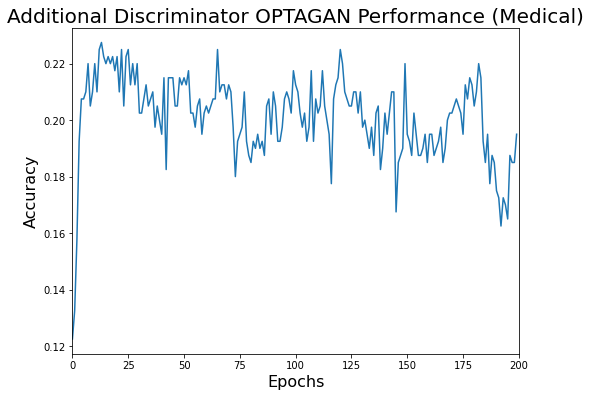

In [20]:
plt.figure(figsize=(8,6))
plt.plot(accuracy_array)
plt.title('Additional Discriminator OPTAGAN Performance (Medical)', fontsize=20)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.xlim(0,200)
plt.show

In [21]:
df_to_save = pd.DataFrame(accuracy_array)
df_to_save.to_csv('accuracy_array_optagan_drugs_cls_last.csv')

In [22]:
# #Generating Sentences
# from __future__ import absolute_import, division, print_function, unicode_literals
# import argparse

# import logging
# import torch
# import torch.nn as nn
# import numpy as np

# from modules.gan import Generator

# import glob
# import os
# import pickle
# import random

# import torch.nn.functional as F
# from tqdm import tqdm, trange

# from func import GPT2Config, OpenAIGPTConfig, XLNetConfig, TransfoXLConfig, BertConfig
# from func import GPT2LMHeadModel, GPT2Tokenizer, GPT2ForLatentConnector, GPT2ForLatentConnectorValueHead
# from func import OpenAIGPTLMHeadModel, OpenAIGPTTokenizer
# from func import XLNetLMHeadModel, XLNetTokenizer
# from func import TransfoXLLMHeadModel, TransfoXLTokenizer
# from func import BertForLatentConnector, BertTokenizer

# from collections import defaultdict
# import pdb
# from modules.utils import rollout_test

# MAX_LENGTH = int(10000)  # Hardcoded max length to avoid infinite loop

# ALL_MODELS = sum((tuple(conf.pretrained_config_archive_map.keys()) for conf in (GPT2Config, OpenAIGPTConfig, XLNetConfig, TransfoXLConfig)), ())

# logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
#                     datefmt = '%m/%d/%Y %H:%M:%S',
#                     level = logging.INFO)
# logger = logging.getLogger(__name__)

# MODEL_CLASSES = {
#     'gpt2': (GPT2Config, GPT2ForLatentConnector, GPT2Tokenizer),
#     'bert': (BertConfig, BertForLatentConnector, BertTokenizer),
#     'gpt2v': (GPT2Config, GPT2ForLatentConnectorValueHead, GPT2Tokenizer)
# }

# if __name__ == '__main__':
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--seed', type=int, default=0)
#     parser.add_argument('--new_sent', type=int, default=1, help="Number of sentences to generate")
#     parser.add_argument('--n_layers', type=int, default=20, help="Number of layers of generator")
#     parser.add_argument('--block_dim', type=int, default=100)
#     parser.add_argument('--interval', type=int, default=10)
#     parser.add_argument('--cuda', type=bool, default=torch.cuda.is_available())
#     parser.add_argument('--generator_dir', default=None, type=str, required=True, help="Directory of GAN model checkpoint")
#     parser.add_argument("--checkpoint_dir", default=None, type=str, required=True,
#                         help="The directory where checkpoints are saved.")
#     parser.add_argument("--output_dir", default=None, type=str, required=True,
#                         help="The output directory where the model predictions and checkpoints will be written.")
#     parser.add_argument("--save", default=False, type=bool, help="Save results to file.")
#     parser.add_argument("--latent_size", default=32, type=int, help="Latent space dimension.")
#     parser.add_argument("--output_name", default="results", type=str, help="File name of output")
#     parser.add_argument("--batch_size", default=100, type=int, help="Batch size to generate outputs")
#     ## Encoder options
#     parser.add_argument("--encoder_model_type", default="bert", type=str,
#                         help="The encoder model architecture to be fine-tuned.")
#     parser.add_argument("--encoder_model_name_or_path", default="bert-base-cased", type=str,
#                         help="The encoder model checkpoint for weights initialization.")
#     parser.add_argument("--encoder_config_name", default="", type=str,
#                         help="Optional pretrained config name or path if not the same as model_name_or_path")
#     parser.add_argument("--encoder_tokenizer_name", default="", type=str,
#                         help="Optional pretrained tokenizer name or path if not the same as model_name_or_path")
#     ## Decoder options
#     parser.add_argument("--decoder_model_type", default="gpt2", type=str,
#                         help="The decoder model architecture to be fine-tuned.")
#     parser.add_argument("--decoder_model_name_or_path", default="gpt2", type=str,
#                         help="The decoder model checkpoint for weights initialization.")
#     parser.add_argument("--decoder_config_name", default="", type=str,
#                         help="Optional pretrained config name or path if not the same as model_name_or_path")
#     parser.add_argument("--decoder_tokenizer_name", default="", type=str,
#                         help="Optional pretrained tokenizer name or path if not the same as model_name_or_path")
#     parser.add_argument("--max_seq_length", default=512, type=int,
#                         help="Optional input sequence length before tokenization. The sequence will be dropped if it is longer the max_seq_length")
#     parser.add_argument("--finetune_decoder", default=False, type=bool,
#                         help="Uses finetuned decoder in output dir if true.")

#     ## Variational auto-encoder(check this)
#     parser.add_argument("--top_k", type=int, default=0)
#     parser.add_argument("--top_p", type=float, default=1.0)
#     parser.add_argument("--prompt", type=str, default="")
#     parser.add_argument("--padding_text", type=str, default="")
#     parser.add_argument("--length", type=int, default=20)
#     parser.add_argument("--block_size", default=-1, type=int,
#                         help="Optional input sequence length after tokenization."
#                              "The training dataset will be truncated in block of this size for training."
#                              "Default to the model max input length for single sentence inputs (take into account special tokens).")
#     parser.add_argument("--do_lower_case", action='store_true',
#                         help="Set this flag if you are using an uncased model.")
#     parser.add_argument("--use_philly", action='store_true',
#                         help="Use Philly for computing.")
#     parser.add_argument('--gloabl_step_eval', type=int, default=508523,
#                         help="Evaluate the results at the given global step")

#     # Load a trained Encoder model and vocabulary that you have fine-tuned
#     args = parser.parse_args("--checkpoint_dir=output_dir_yahoo_768_0 \
#     --output_dir=output_dir_yahoo_768_0 \
#     --generator_dir=output_dir_yahoo_768_0 \
#     --block_size 100 \
#     --max_seq_length 60 \
#     --gloabl_step_eval 24000 \
#     --latent_size 32 \
#     --block_dim 100 \
#     --new_sent 100 \
#     --n_layers 10 \
#     --top_p 0.9 \
#     --output_name=results \
#     --save True".split())
#     global_step = args.gloabl_step_eval

#     np.random.seed(args.seed)
#     torch.manual_seed(args.seed)
#     torch.backends.cudnn.deterministic = True
#     args.device = torch.device("cuda" if args.cuda else "cpu")
#     args.n_gpu = torch.cuda.device_count()
#     if args.n_gpu > 0:
#         torch.cuda.manual_seed_all(args.seed)       
    
#     args.encoder_model_type = args.encoder_model_type.lower()
#     args.decoder_model_type = args.decoder_model_type.lower()

#     output_encoder_dir = os.path.join(args.checkpoint_dir, 'checkpoint-encoder-{}'.format(global_step))
#     output_decoder_dir = os.path.join(args.checkpoint_dir, 'checkpoint-decoder-{}'.format(global_step))
#     if not args.finetune_decoder:
#         output_decoder_dir = os.path.join(args.checkpoint_dir, 'checkpoint-decoder-{}'.format(global_step))
#     else:
#          output_decoder_dir = os.path.join(args.output_dir, 'checkpoint-decoder-{}'.format(global_step))
#     checkpoints = [ [output_encoder_dir, output_decoder_dir] ]

#     # Load a trained Encoder model and vocabulary that you have fine-tuned
#     encoder_config_class, encoder_model_class, encoder_tokenizer_class = MODEL_CLASSES[args.encoder_model_type]
#     model_encoder = encoder_model_class.from_pretrained(output_encoder_dir, latent_size=args.latent_size)
#     tokenizer_encoder = encoder_tokenizer_class.from_pretrained(args.encoder_tokenizer_name if args.encoder_tokenizer_name else args.encoder_model_name_or_path, do_lower_case=args.do_lower_case)

#     model_encoder.to(args.device)
#     if args.block_size <= 0:
#         args.block_size = tokenizer_encoder.max_len_single_sentence  # Our input block size will be the max possible for the model
#     args.block_size = min(args.block_size, tokenizer_encoder.max_len_single_sentence)

#     # Load a trained Decoder model and vocabulary that you have fine-tuned
#     if not args.finetune_decoder:
#         decoder_config_class, decoder_model_class, decoder_tokenizer_class = MODEL_CLASSES[args.decoder_model_type]
#     else:
#         decoder_config_class, decoder_model_class, decoder_tokenizer_class = MODEL_CLASSES["gpt2v"]
#     model_decoder = decoder_model_class.from_pretrained(output_decoder_dir, latent_size=args.latent_size)
#     tokenizer_decoder = decoder_tokenizer_class.from_pretrained(args.decoder_tokenizer_name if args.decoder_tokenizer_name else args.decoder_model_name_or_path, do_lower_case=args.do_lower_case)
#     model_decoder.to(args.device)
#     if args.block_size <= 0:
#         args.block_size = tokenizer_decoder.max_len_single_sentence  # Our input block size will be the max possible for the model
#     args.block_size = min(args.block_size, tokenizer_decoder.max_len_single_sentence)

#     # Chunyuan: Add Padding token to GPT2
#     special_tokens_dict = {'pad_token': '<PAD>', 'bos_token': '<BOS>', 'eos_token': '<EOS>'}
#     num_added_toks = tokenizer_decoder.add_special_tokens(special_tokens_dict)
#     logger.info('We have added {} tokens to GPT2'.format(num_added_toks))
#     model_decoder.resize_token_embeddings(len(tokenizer_decoder))  # Notice: resize_token_embeddings expect to receive the full size of the new vocabulary, i.e. the length of the tokenizer.
#     assert tokenizer_decoder.pad_token == '<PAD>'
    
#     generator = Generator(args.n_layers, args.block_dim, args.latent_size)

#     if args.cuda:
#         generator = generator.cuda()

#     generator.load_state_dict(torch.load(args.generator_dir+'/generator_'+str(args.gloabl_step_eval)+'.th'))
#     generator.eval()
#     model_decoder.eval()
#     model_encoder.eval()
#     if args.save:
#         if not os.path.exists(args.output_dir+"/{}.txt".format(args.output_name)):
#             with open(args.output_dir+"/{}.txt".format(args.output_name), 'w'): 
#                 pass

#     for i in range(int(args.new_sent/args.batch_size)):
#         # sample noise
#         noise = torch.Tensor(np.random.normal(0, 1, (args.batch_size, args.latent_size))).to(args.device)
#         new_z = generator(noise).data

#         # create new sent
#         sents = rollout_test(model_decoder, new_z, tokenizer_decoder, args.max_seq_length, args.batch_size, args.top_k, args.top_p)

#         if args.save:
#             with open(args.output_dir+"/{}.txt".format(args.output_name), 'a') as file:
#                 for i in sents:
#                     file.write(i+"\n")
#         else:
#             for i in sents:
#                 logger.info(i)
